# EXPLORATORY DATA ANALYSIS : PREDICTING CLIENTS LOAN REPAYMENT ABILITY

## OVERVIEW:
* This problem statement of predicting clients loan repayment ability is a Kaggle competition happened in year 2018. This competition was conducted by Home credit group. Home credit is an international consumer finance provider company founded in 1997 with operations in 9 countries. Home credit focus on responsible lending, primarily to people with little or no credit history. Home credit offer point-of-sale (POS) loans, cash loans and revolving loan products. Home credits aim is to provide innovative retail financial services with a focus on mass-retail lending and encouraging economic development through 
supporting domestic consumption, thereby improving living standards.

* Many people struggle to get loans due to insufficient or non-existent credit histories. Unfortunately, this population is often taken advantage of by untrustworthy lenders. Home credit accesses repayment ability of this unbanked population by using variety of data including telco and transactional information. Doing so will ensure that clients capable of repayment are not rejected and that loans are given

* In this case study we will use the data provided by home credit to predict client’s repayment capability. This data is as follows:

<table>
  <tr>
    <th>File Name</th>
    <th>Description</th>
    <th>Number of features</th>
  </tr>
  <tr>
    <td>Application_train.csv</td>
    <td> Information about loan and loan applicant when they submit the application</td>
    <td>121</td>
  </tr>
  <tr>
    <td>Bureau.csv</td>
    <td>Application data from previous loans that client got from other institutions reported to Credit Bureau</td>
    <td>17</td>
  </tr>
  <tr>
    <td>bureau balance.csv</td>
    <td>Monthly balance of credits in Credit Bureau</td>
    <td>3</td>
  </tr>
  <tr>
    <td>previous application.csv</td>
    <td>Information about the previous loan and client information at previous time</td>
    <td>37</td>
  </tr>
  <tr>
    <td>POS CASH balance.csv</td>
    <td>Monthly balance of client’s previous loans in Home Credit</td>
    <td>8</td>
  </tr>
  <tr>
    <td>instalments payments.csv</td>
    <td>Previous payment data related to loans</td>
    <td>8</td>
  </tr>
  <tr>
    <td>credit card balance.csv</td>
    <td>Monthly balance of client’s previous credit card loans</td>
    <td>23</td>
  </tr>
</table>

## Importing libraries, modules and data

In [1]:
# Importing the required libraries and modules
import os
import zipfile
! pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 14})
# Libraries for kmeans
from sklearn.cluster import KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 26.0 MB/s 


In [2]:
# step 1
"""
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. 
Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. 
This will trigger the download of kaggle.json, a file containing your API credentials.
# step 2 """
!pip install -q kaggle
# step 3
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swapnilransing","key":"c9f996bc05f41c5d07ad1f5793ebc1a6"}'}

In [3]:
# step 4 : creating a directory
!mkdir ~/.kaggle # !rm -rf ~/.kaggle is the command if the directory is already present
# step 5 :copy the file kaggle.json to created directory
!cp kaggle.json ~/.kaggle/
# step 6: permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# step 7 : downloading the particular files
! kaggle competitions download -c home-credit-default-risk

 99% 679M/688M [00:07<00:00, 86.3MB/s]
100% 688M/688M [00:07<00:00, 102MB/s] 


In [5]:
# step 8 : unzipping
source_dir = '/content/'
os.chdir(source_dir)

file_names = os.listdir(source_dir)
for item in file_names:
  if (item.endswith(".zip")):
    file_name = os.path.abspath(item) # get full path of files
    zip_ref = zipfile.ZipFile(file_name) # create zipfile object
    zip_ref.extractall(source_dir) # extract file to dir
    zip_ref.close() # close file
    os.remove(file_name) # delete zipped file

## Defining the functions

In [6]:
# Function for plotting category variable
def category_var_plot(dataframe,category_var):
  """ This function plots the categorical variables of dataframe.

  Inputs=
  dataframe= name of the dataframe
  category_var= name of the categorical variable

  Outputs=
  1. Computes the unique categories of a variable
  2. Computes the NaN sample percentage 
  3. percentage Count plot of variable categories
  4. Binary classification perentage plot of each category of categorical variable
  5.pie chart of percentage count of defaulters in dataframe variable
  
  """

  # 1. Computing the unique categories of a variable

  print("Number of unique category values of {} categorical variable are {}".format(category_var,dataframe[category_var].nunique()))
  nunique=dataframe[category_var].nunique()
  print('-'*185)

  # 2. Computing the NaN sample percentage 
  list_unique_cat=dataframe[category_var].unique().tolist()
  counter=0
  for i in list_unique_cat:
    if str(i)=='nan':
      print("Dataframe has NaN rows.")
      df=dataframe[dataframe[category_var].isna()]
      print("Percentage of NaN rows for {} categorical variable are {} %".format(category_var,round(df["SK_ID_CURR"].count()/dataframe["SK_ID_CURR"].count()*100,2)))

      print("Percentage of {} labels for NaN value row is {} %".format(df["TARGET"].value_counts().index.tolist()[0],round(df["TARGET"].value_counts()[0]/df["SK_ID_CURR"].count()*100,2)))
      print("Percentage of {} labels for NaN value row is {} %".format(df["TARGET"].value_counts().index.tolist()[1],round(df["TARGET"].value_counts()[1]/df["SK_ID_CURR"].count()*100,2)))
      print("Applicants labelled 1 are defaulters.")
      counter=1
      break 
  if counter==0:
    print("Dataframe does not have NaN rows.")    

  print('-'*185)

  # 3. percentage Count plot of variable categories
  df=dataframe.groupby(category_var)["SK_ID_CURR"].count()
  df = df.rename('percent').reset_index()
  df['percent'] = (df['percent'] / df['percent'].sum()) * 100
  ylim=df['percent'].max()+5

  g = sns.catplot(x=category_var,y='percent',kind='bar',data=df)
  g.ax.set_ylim(0,ylim)
  g.fig.set_figheight(4.5)
  g.fig.set_figwidth(29)
  g.set_xticklabels(rotation=90)

  for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() # controls the height
    txt_y = p.get_height() # controls the x axis position
    g.ax.text(txt_x,txt_y+0.5,txt)

  plt.title("Percentage distribution of each category in {} variable".format(category_var))
  plt.ylabel("Percentage(%)")
  plt.xlabel(category_var)
  plt.show()

  print('-'*185)

  # 4. Binary classification perentage plot of each category of categorical variable
  df=dataframe.groupby(category_var)["TARGET"].value_counts(normalize=True)
  df=df.mul(100)
  df = df.rename('percent').reset_index()
  df_non_defaulters=df[df["TARGET"]==0]
  df_defaulters=df.groupby(category_var)["TARGET"].sum()
  df_defaulters=df_defaulters.mul(100)
  df_defaulters=df_defaulters.rename('percent').reset_index()

        # set the figure size
  plt.figure(figsize=(24,4.5))

        # bar chart 1 -> top bars (group of 'Defaulters')
  bar1 = sns.barplot(x=category_var,  y="percent", data=df_defaulters, color='darkblue')

        # bar chart 2 -> bottom bars (group of 'Non-Defaulters')
  bar2 = sns.barplot(x=category_var, y="percent", data=df_non_defaulters, color='lightblue')

        # add legend
  top_bar = mpatches.Patch(color='darkblue', label='Defaulters')
  bottom_bar = mpatches.Patch(color='lightblue', label='Non-Defaulters')
  plt.legend(handles=[top_bar, bottom_bar])

        # show the graph
  plt.title("Binary classification perentage of each category for {} categorical variable".format(category_var))
  plt.ylabel("Percentage(%)")
  plt.xlabel(category_var)
  plt.ylim(0,130)
  plt.xticks(rotation=90)
  plt.show()

  print('-'*185)

  # 5.pie chart of percentage count of defaulters in dataframe variable
  # dataset preperation for pie chart
  df=dataframe.groupby(category_var)["TARGET"].value_counts()
  df = df.rename('count').reset_index()
  df_defaulters_pie=df[df["TARGET"]==1]

  # plotting
  plt.figure(figsize=(10, 10))

  #define Seaborn color palette to use
  colors = sns.color_palette('pastel')[0:nunique]

  #create pie chart
  plt.pie(df_defaulters_pie["count"], labels = df_defaulters_pie[category_var], colors = colors, autopct='%.0f%%')
  plt.title("Defaulters Perentage of Each Category For {} Categorical Variable".format(category_var))
  plt.show()

In [7]:
# Function for plotting continuous variable
def plot_continuous_variables(data, column_name, scale="No", scale_range=(0,5),box_scale=(0,5)):
  """ This function plots the continuous variables of dataframe.

  Inputs=
  data= name of the dataframe
  column_name= name of the continuous variable
  scale=If you want to set the scale for the output plots, please mention Yes
  scale_range= Range for probability density plot, default is (0,5) if scale!=No
  box_scale= Range of box plot, default is (0,5) if scale!=No

  Outputs=
  1. Computes the NaN sample percentage 
  2. Probability density plot
  3. Box plot  
  """


  # 1. Computes the NaN sample percentage 
  count=data[data[column_name].isna()].shape[0]
  if count!=0:
    print("Continuous variable {} has {} NaN rows.".format(column_name,count))
    df=data[data[column_name].isna()]

    print("Percentage of NaN rows for {} continuous variable are {} %".format(column_name,round(df["SK_ID_CURR"].count()/data["SK_ID_CURR"].count()*100,2)))

    if df["TARGET"].value_counts().shape[0]>1:
      print("Percentage of {} labels for NaN value row is {} %".format(df["TARGET"].value_counts().index.tolist()[0],round(df["TARGET"].value_counts()[0]/df["SK_ID_CURR"].count()*100,2)))
      print("Percentage of {} labels for NaN value row is {} %".format(df["TARGET"].value_counts().index.tolist()[1],round(df["TARGET"].value_counts()[1]/df["SK_ID_CURR"].count()*100,2)))
      print("Applicants labelled 1 are defaulters.")
    else:
      print("All the labels of NaN rows are ",df["TARGET"].value_counts().index.tolist()[0])

  else:
    print("Continuous variable {} does not have NaN rows.".format(column_name))    

  print('-'*185)

  sns.set_style('whitegrid')
  plt.figure(figsize=(20,8))
         
  # 2. Probability density plot
  plt.subplot(1, 2, 1)
  plt.subplots_adjust(wspace=0.25)

  sns.distplot(data[column_name][data['TARGET'] == 0].dropna(),label='Non-Defaulters', hist = False, color='red')
  sns.distplot(data[column_name][data['TARGET'] == 1].dropna(),label='Defaulters', hist = False, color='black')
  plt.xlabel(column_name)
  plt.ylabel('Probability Density')
  plt.legend(fontsize='medium')
  plt.title("Dist-Plot of {}".format(column_name))
  if scale !="No":
    plt.xlim(scale_range)


  # 3. Box plot 
  plt.subplot(1, 2, 2)
  plt.subplots_adjust(wspace=0.25)
  g =sns.boxplot(x='TARGET', y=column_name, data=data)
  plt.title("Box-Plot of {}".format(column_name))
  g.set_xticklabels(['Non-Defaulters','Defaulters'])
  if scale !="No":
    plt.ylim(box_scale)

  plt.show()

In [8]:
# Function for printing the percentile values of continuous variable
def print_percentiles(data, column_name, percentiles = None):
    
    '''
    Function to print percentile values for given column
    
    Inputs=
    data= DataFrame name
    column_name= Column's name whose percentiles are to be printed percentiles: list, default = None
                  The list of percentiles to print, if not given, default are printed

    Outputs=
    1. Prints percentile for the default or mentioned percentile values
    '''
    
    print('-'*185)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*185)

In [9]:
# Function to plot bar plot of percentage NaN values in a dataframe
def plot_nan_pct(dataframe,title):
  '''
  Function plots bar plot representing percentage of NaN values in a dataframe. 
  This function first computes all the variable/columns of dataframe consisting of NaN 
  values and then computes the corresponding percentage and plots that percentage values.
    
  Inputs=
  dataframe= DataFrame name
  title= data frame name entered as string (This will be used in bar plot title)

  Outputs=
  1. Bar plot ot percentage of NaN values in a dataframe
    '''

  nan_col_name=[]
  nan_val_count=[]
  nan_value_dict={}

  # prepering a dictionary of columns and correponding NaN percentage
  for i in range(dataframe.shape[1]):
    count=round(dataframe[dataframe[dataframe.columns[i]].isna()].shape[0]/dataframe.shape[0]*100,2)
    if count!=0:
      nan_value_dict[dataframe.columns[i]]=count
  # sorting the dict in reverse order and storing the column name and NaN percentage in lists
  for w in sorted(nan_value_dict, key=nan_value_dict.get, reverse=True):
    nan_val_count.append(nan_value_dict[w])
    nan_col_name.append(w)

  if len(nan_val_count)>0:
    print("Number of variables having NaN samples are ",len(nan_col_name))
    # generating the plot
    fig = plt.figure(figsize = (25, 5))
 
    # creating the bar plot
    plt.bar(nan_col_name, nan_val_count, color ='maroon')
 
    plt.xlabel("Variable Name")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage of NaN values in "+title)
    plt.xticks(rotation = 90)
    plt.show()

  else:
    print("Dataframe {} does not have any NaN variable".format(title))

In [10]:
def pairPlotFn(dataframe,NameString):
  g = sns.pairplot(df, hue="TARGET", markers=["o", "s"],size=4)
  #g.fig.set_figheight(15)
  #g.fig.set_figwidth(15)
  plt.suptitle("Pair Plot of {} Dataframes Top Continuous Variables".format(NameString), size = 22,y=1.02)
  plt.show()

# EDA

For data analysis of the provided data, we have followed the steps as follows:
1. Analyzed each data table/ dataframe one by one.
2. For each dataframe, understood the basic statistics consisting of shape of dataframe, number of variables etc.
3. For each dataframe found out the categorical and continuous variables.
4. If the table is a relational table and has a primary key which is foreign key of another table, understood the percentage of information explained by this dataframe wrt the main dataframe.
5. Plotted the NaN variables percentage in a dataframe.
6. Concatenated the dataframe with Target labels from the main dataframe for the dataframes not having Target labels.
7. Plotted and understood the correlation matrix:
  *   For categorical variables, Phi-k correlation matrix is used to get the correlation between variables.
  *   For continuous variables, Pearson correlation matrix is used to get the correlation between variables.
8. Plotted categorical variables of a dataframe which shows higher Phi-K correaltion coefficient. Following are the plots used for plotting categorical variable.
  *   Count Plot: Percentage Count plot of variable categories
  *   Stacked Bar Plot: Binary classification perentage plot of each category of categorical variable
  * Pie Chart: Percentage count of defaulters in dataframe variable
9. Plotted continuous variables of a dataframe which shows higher Pearson correaltion coefficient. Along with from plot sometimes understood percentile distribution of dataframe variable. Following are the plots used for plotting continuous variable.
  *   Density Plot
  *   Box Plot
  * Pair Plot
10. Observations and conclusions are written after each major step and plot.

* phik correaltion medium blog= https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7#:~:text=Phik%20(%F0%9D%9C%99k)%20is%20a%20new,a%20bivariate%20normal%20input%20distribution.





# Columns Description of Each Dataframes

In [11]:
columns=pd.read_csv("HomeCredit_columns_description.csv",encoding='latin1')
columns

Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

In [12]:
pd.options.display.max_colwidth = 200
print(columns["Description"][columns["Row"]=='TARGET'])

1    Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
Name: Description, dtype: object


HomeCredit_columns_description.csv has all columns information of all the tables.

# Target Variable

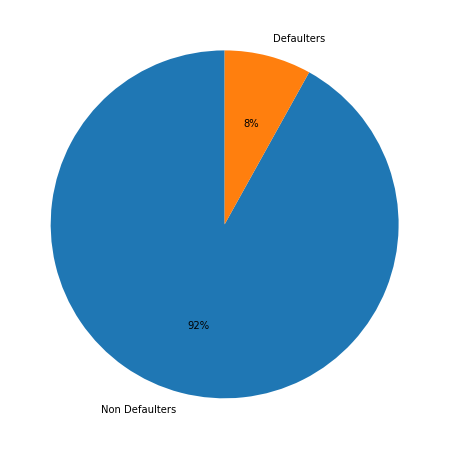

In [13]:
# Pie chart for Target Variable
application_train=pd.read_csv("application_train.csv")
y = np.array([application_train["TARGET"].value_counts()[0], application_train["TARGET"].value_counts()[1]])
mylabels = ["Non Defaulters", "Defaulters"]

plt.figure(figsize=(8,8))
plt.pie(y, labels = mylabels, startangle = 90,autopct='%.0f%%')
plt.show() 

**Observations and Conclusions:**
1. Out of the total labelled data in Application train, 92% are non defaulters while 8% are defaulters.
2. This is an imbalanced dataset. Sampling techniques should be tried out while modeling for better results.
**Choosing The Right Performance Metric:**
1. For analyzing the classification performance of model on imbalanced data set we have chossen an Area Under ROC Curve as performance metric. ROC curve does not have bias towards the majority class and performance well in case of imbalanced dataset. 
2. In this classification task, it is important to predict the defaulters. Defaulters being predicted as non defaulters will not be able to pay the loan. Also company will loose business if non defaulters are predicted as defaulters. Hence in this classification task both precision and recall are important. So F1 score is choosen as one of the performance metric.
3. For an imbalanced dataset, we would also be analyzing the confusion matrics, precision and recall matrics to understand the classification tasks performance.

# Application Train and Application Test Dataframes Statistics

In [14]:
application_train=pd.read_csv("application_train.csv")
application_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [ ]:
print("Shape of Application Train dataframe is ",application_train.shape)
print("Number of unique values of SK_ID_CURR in  Application Train dataframe are ",application_train["SK_ID_CURR"].nunique())
print("Target labels and corresponding counts are \n",application_train["TARGET"].value_counts())
print("Percentage of non defaulted loans are {}%".format(round(application_train["TARGET"].value_counts()[0]/application_train["SK_ID_CURR"].nunique()*100,2)))
print("Percentage of defaulted loans are {}%".format(round(application_train["TARGET"].value_counts()[1]/application_train["SK_ID_CURR"].nunique()*100,2)))

Shape of Application Train dataframe is  (307511, 122)
Number of unique values of SK_ID_CURR in  Application Train dataframe are  307511
Target labels and corresponding counts are 
 0    282686
1     24825
Name: TARGET, dtype: int64
Percentage of non defaulted loans are 91.93%
Percentage of defaulted loans are 8.07%


Number of variables having NaN samples are  64


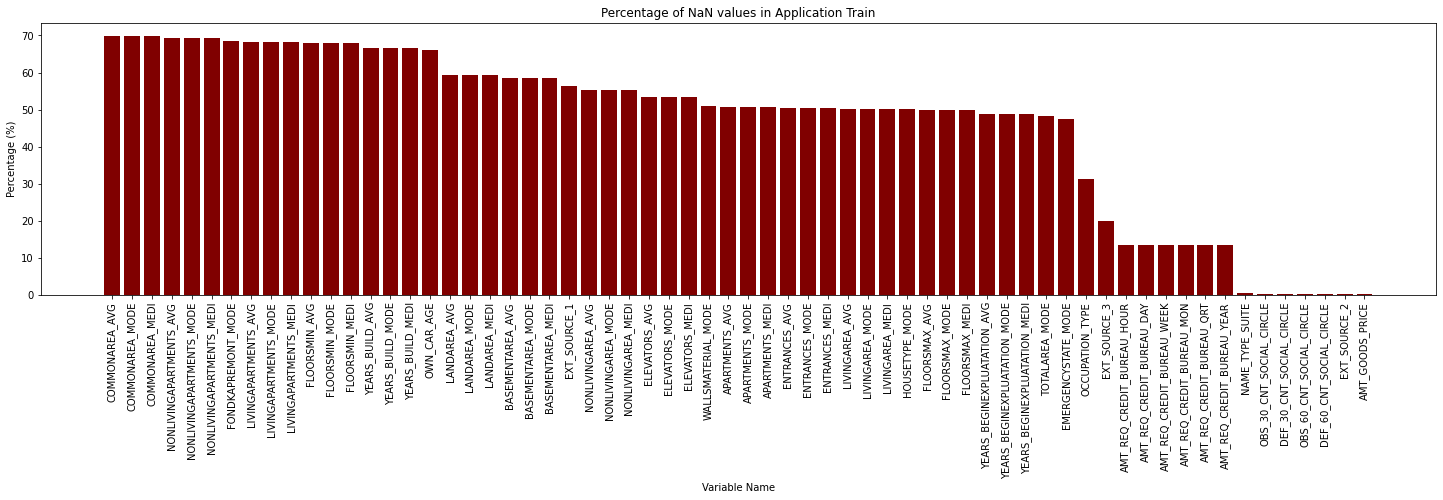

In [ ]:
#NaN variable percentatge in dataframe
plot_nan_pct(application_train,"Application Train")

**Observations and Conclusions:**
1. application_train.csv has 307511 unique values and 122 columns. 
2. SK_ID_CURR is a column name for each loan application.
3. Value of TARGET column defines the status of application. Target has binary values, either 0 or 1. 1 is assigned to client with payment difficulties (Defaulters). Payment difficulties is defined as late payment more than X days on at least one of the first Y installments. 0 is assigned to all other cases (Non defaulters).
4. Around 92% of applicant from the given application data are non defaulters while 8% are defaulters.
5. This is an imbalanced data. Sampling techniques will have to be carried out while modeling.
1. Total number of variables consisting of NaN values are 64.
2. Highest NaN percentage is observed for commonarea_avg variable while the lowest is observed for AMT_GOODS_PRICE.
3. While featurizing the data these NaN values needs to be imputed. Observations from the EDA study and literature study should help in NaN value imputation.

In [15]:
application_test=pd.read_csv("application_test.csv")
application_test

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0          100001         Cash loans           F            N               Y   
1          100005         Cash loans           M            N               Y   
2          100013         Cash loans           M            Y               Y   
3          100028         Cash loans           F            N               Y   
4          100038         Cash loans           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             450000.0  ...                0                0   
1             180000.0  ...                0                0   
2             630000.0  ...                0                0   
3            1575000.0  ...                0                0   
4             625500.0  ...                0                0   
...                ...  ...              ...              ...   
48739         270000.0  ...                0                0   
48740         495000.0  ...                0                0   
48741         315000.0  ...                0                0   
48742         450000.0  ...                0                0   
48743         270000.0  ...                0                0   

      FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                    0                0                        0.0   
1                    0                0                        0.0   
2                    0                0                        0.0   
3                    0                0                        0.0   
4                    0                0                        NaN   
...                ...              ...                        ...   
48739                0                0                        0.0   
48740                0                0                        NaN   
48741                0                0                        0.0   
48742                0                0                        0.0   
48743                0                0                        0.0   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            NaN                         NaN   
...                          ...                         ...   
48739                        0.0                         0.0   
48740                        NaN                         NaN   
48741                        0.0           

In [ ]:
print("Common id's between application_train.csv and application_test.csv",len(list(set(application_train["SK_ID_CURR"]) & set(application_test["SK_ID_CURR"]))))

Common id's between application_train.csv and application_test.csv 0


**Observations and Conclusions:**
1. Each row is unique in application_train.csv  and application_test.csv files.
2. There are no common rows/ id's between application_train.csv and application_test.csv files
3. Total number of id's in application_train.csv and application_test.csv are 356255
4. application_test.csv do not have TARGET label column.



## Application Train Variable Correalation

Lets understand the correaltion between application_train.csv columns and target label. For numerical variables we will use pearson correlation coefficient and for categorical variables we will use phi-k correlation coefficient.

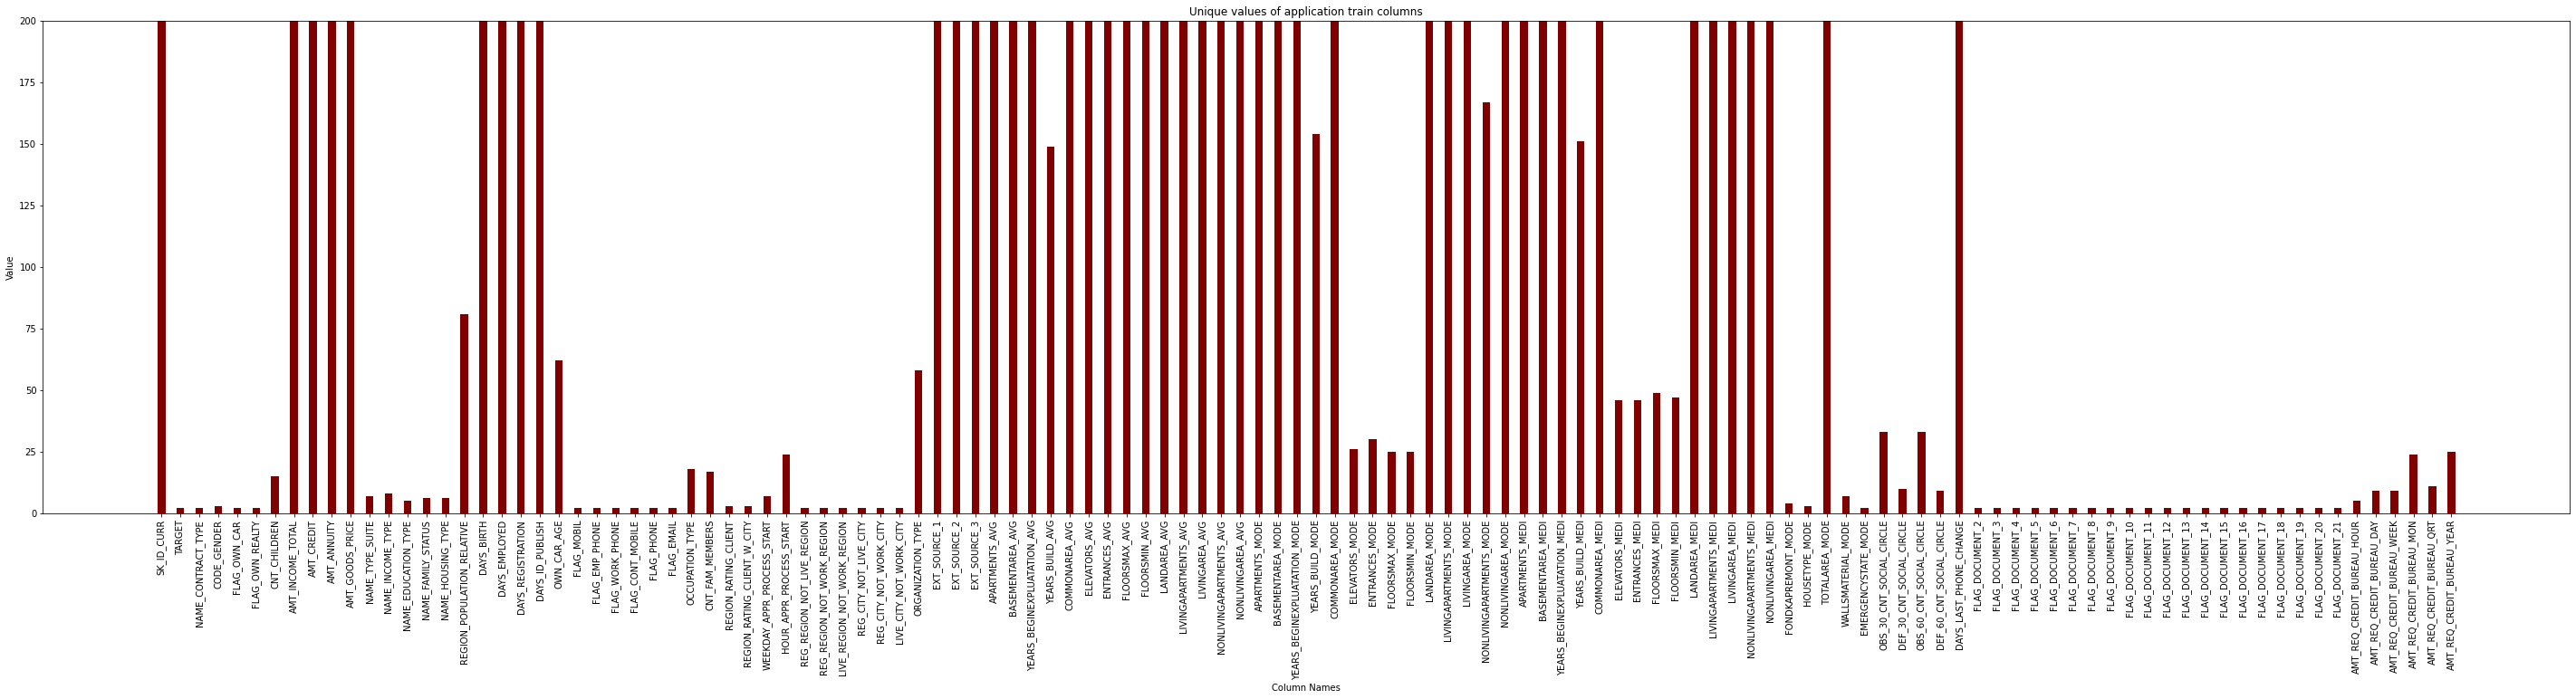

In [ ]:
# Getting the categorical data column names
# As number of data columns are high in application_train dataframe, we will plot the number of unique values
# in each dataframe and use threshold from the observations to seperate the categorical and continuous variables

application_train_columns=list(application_train.columns)
application_train_columns_nunique=[]
for i in application_train_columns:
  application_train_columns_nunique.append(application_train[i].nunique())

# bar plot of application train columns and corresponding unique values
fig = plt.figure(figsize = (50, 10))
 
# creating the bar plot
plt.bar(application_train_columns, application_train_columns_nunique, color ='maroon',
        width = 0.4)
 
plt.xlabel("Column Names")
plt.ylabel("Value")
plt.title("Unique values of application train columns")
plt.ylim(0,200)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# using a threshold value of unique values per column to categorize the column as categorical column
application_train_categorical_col=[]
for i in range(len(application_train_columns_nunique)):
  if application_train_columns_nunique[i]<100:  # 100 is a threshold value used
    application_train_categorical_col.append(application_train_columns[i])
print("Total number of categorical variables in the application columns are ",len(application_train_categorical_col))
print('These columns are ',application_train_categorical_col)

Total number of categorical variables in the application columns are  74
These columns are  ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTA

**Observations and Conclusions:**
* As the number of data columns are high, it is difficult to visualize the column names. However, it can be clearly seen that, columns with unique values lesser than 100 can be called as categorical columns. 

*   After manual checking of values of each column, it is observed that following are not the categorical columns:
 'REGION_POPULATION_RELATIVE',  'OWN_CAR_AGE',  'HOUR_APPR_PROCESS_START',  'ELEVATORS_MODE',  'ENTRANCES_MODE',  'FLOORSMAX_MODE',  'FLOORSMIN_MODE',  'ELEVATORS_MEDI',  'ENTRANCES_MEDI',  'FLOORSMAX_MEDI',  'FLOORSMIN_MEDI'.

* Lets refine the categorical column variables and use the correlation matrix to understand the relation of categorical variables wrt target variable.

In [ ]:
# Selecting the categorical columns
not_cat_col=[ 'REGION_POPULATION_RELATIVE',  'OWN_CAR_AGE',   'HOUR_APPR_PROCESS_START',  'ELEVATORS_MODE', \
              'ENTRANCES_MODE',  'FLOORSMAX_MODE',  'FLOORSMIN_MODE',  'ELEVATORS_MEDI',  'ENTRANCES_MEDI',  'FLOORSMAX_MEDI',  'FLOORSMIN_MEDI']
application_train_categorical_col=[x for x in application_train_categorical_col if not x in not_cat_col]
print("Total number of categorical variables in the application columns are ",len(application_train_categorical_col))
print('These columns are ',application_train_categorical_col)

# Categorical Application Train dataframe
application_train_cat=application_train[application_train_categorical_col]

Total number of categorical variables in the application columns are  63
These columns are  ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', '

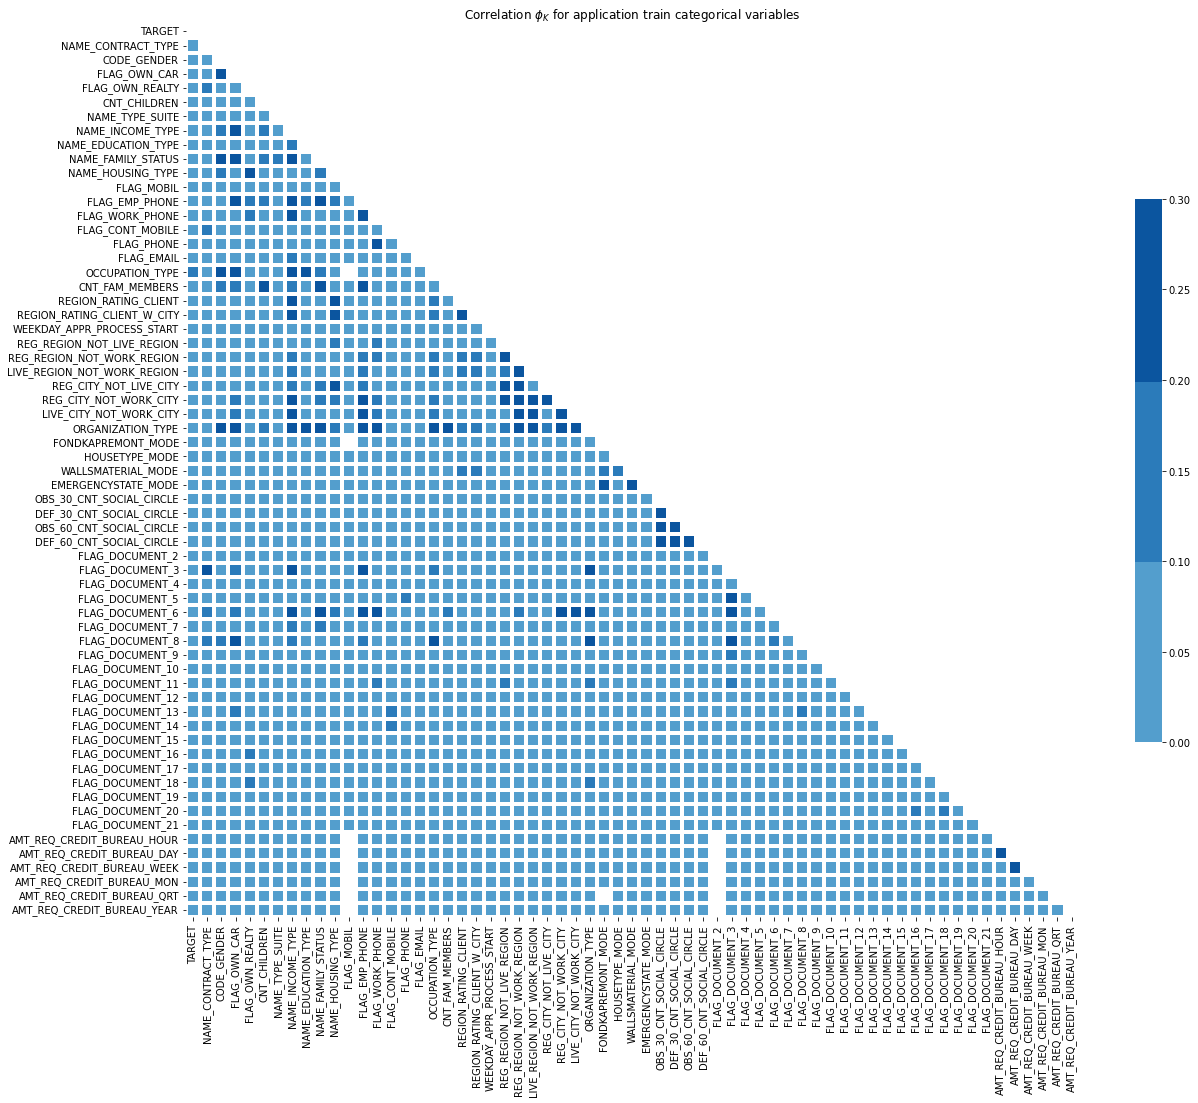

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Correlation between categorical variable and Target variable sorted in descending order are :



TARGET                     1.000000
OCCUPATION_TYPE            0.102846
ORGANIZATION_TYPE          0.089164
NAME_INCOME_TYPE           0.084831
REG_CITY_NOT_WORK_CITY     0.079946
FLAG_EMP_PHONE             0.072087
REG_CITY_NOT_LIVE_CITY     0.069588
FLAG_DOCUMENT_3            0.069525
NAME_FAMILY_STATUS         0.056043
NAME_HOUSING_TYPE          0.051107
LIVE_CITY_NOT_WORK_CITY    0.050956
Name: TARGET, dtype: float64

In [ ]:
# Computing phi-k correlation for categorical variables
phik_overview = application_train_cat.phik_matrix()
phik_overview.round(2)

# Plotting phi-k correlation
mask_array = np.ones(phik_overview.shape)
mask_array = np.triu(mask_array)
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("Blues")

sns.heatmap(phik_overview, 
            mask=mask_array,
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation $\phi_K$ for application train categorical variables")
plt.show()

print("-"*185)
application_top_categorical_var_lst=phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between categorical variable and Target variable sorted in descending order are :\n")
phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

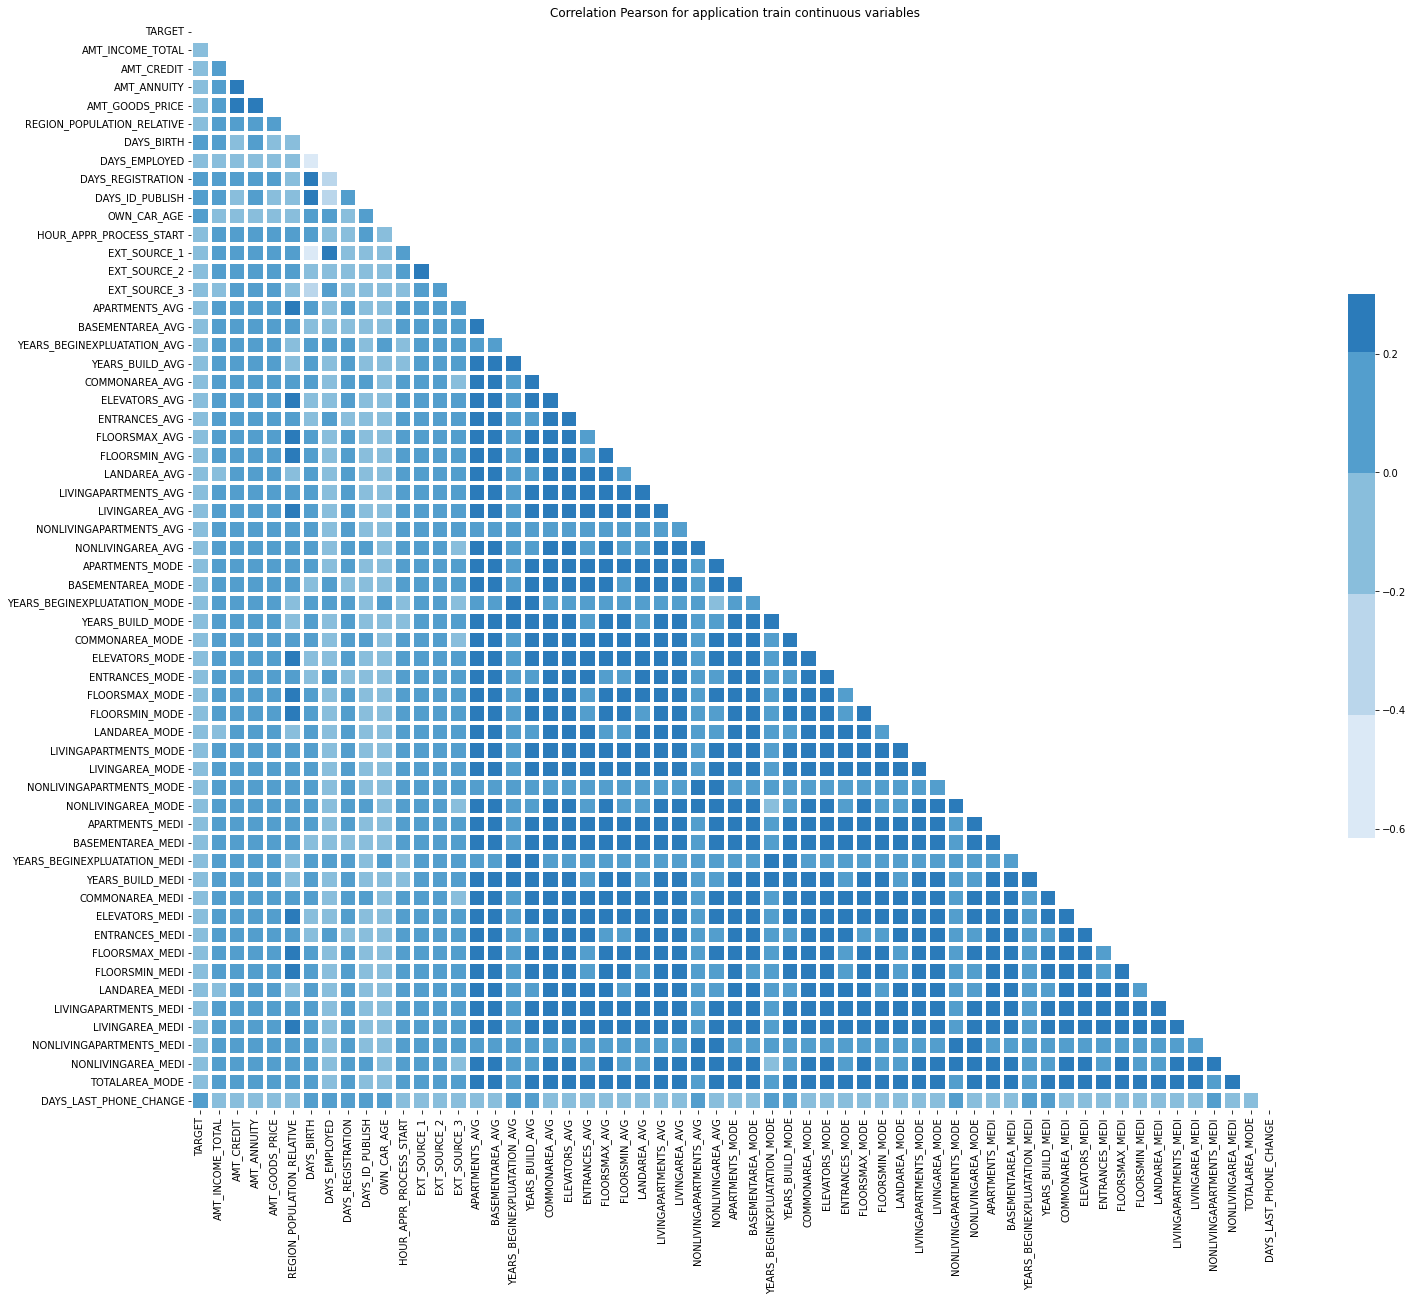

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Correlation between continuous variable and Target variable sorted in descending order are :



TARGET                    1.000000
EXT_SOURCE_3              0.178919
EXT_SOURCE_2              0.160472
EXT_SOURCE_1              0.155317
DAYS_BIRTH                0.078239
DAYS_LAST_PHONE_CHANGE    0.055218
DAYS_ID_PUBLISH           0.051457
DAYS_EMPLOYED             0.044932
FLOORSMAX_AVG             0.044003
FLOORSMAX_MEDI            0.043768
FLOORSMAX_MODE            0.043226
Name: TARGET, dtype: float64

In [ ]:
# Lets similarly observe the correlation between continuous variables and Target variable using Pearson correlatino coefficient
application_train_categorical_col.remove('TARGET')
application_train_continuous=application_train.drop(application_train_categorical_col,axis=1)
application_train_continuous=application_train_continuous.drop(["SK_ID_CURR"],axis=1)

# correlation and plotting
corr=application_train_continuous.corr()

mask_array = np.ones(corr.shape)
mask_array = np.triu(mask_array)

f, ax = plt.subplots(figsize=(25, 20))
cmap = sns.color_palette("Blues")

sns.heatmap(corr, 
            mask=mask_array, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation Pearson for application train continuous variables")
plt.show()

print("-"*185)
application_top_continuous_var_lst=corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between continuous variable and Target variable sorted in descending order are :\n")
corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

**Observations and Conclusions:**
1. There is not much a correaltion observed between TARGET variable and other categorical variables. This shows that the categorical variable and Target label are not linearly correlated.
2. Occupation type and Target variable has maximum correlation with a phi-k value equal to 0.10286
3. Few of the categorical variables show correlation with each other.
4. Lets dive deep into the first 10 categorical variables which show a high correlation wrt Target variable amongst the set of all categorical variables.
1. As Pearson correlation matrix for continuous variable have positive and negative values, to get the top correlated variable we tooke the absolute value of these variables and then choose the top variables.
1. There is not much a correaltion observed between TARGET variable and other continuous variables. This shows that the categorical variable and Target label are not linearly correlated.
2. Days birth and Target variable has maximum correlation with a pearson correlation value equal to 0.078239
3. Few of the continous variables show correlation with each other.
4. Negative Pearson correlation coefficient represents the invesrse linear correlation.
5. Lets dive deep into the first 10 continuous variables which show a high correlation wrt Target variable amongst the set of all continuous variables.

## Application Train Categorical Variable Plots

We will analyze plots of the top 10 categorical features of Application Train dataframe, which are highly correlated with target variable

### Categorical Variable 1: OCCUPATION_TYPE

Number of unique category values of OCCUPATION_TYPE categorical variable are 18
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for OCCUPATION_TYPE categorical variable are 31.35 %
Percentage of 0 labels for NaN value row is 93.49 %
Percentage of 1 labels for NaN value row is 6.51 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


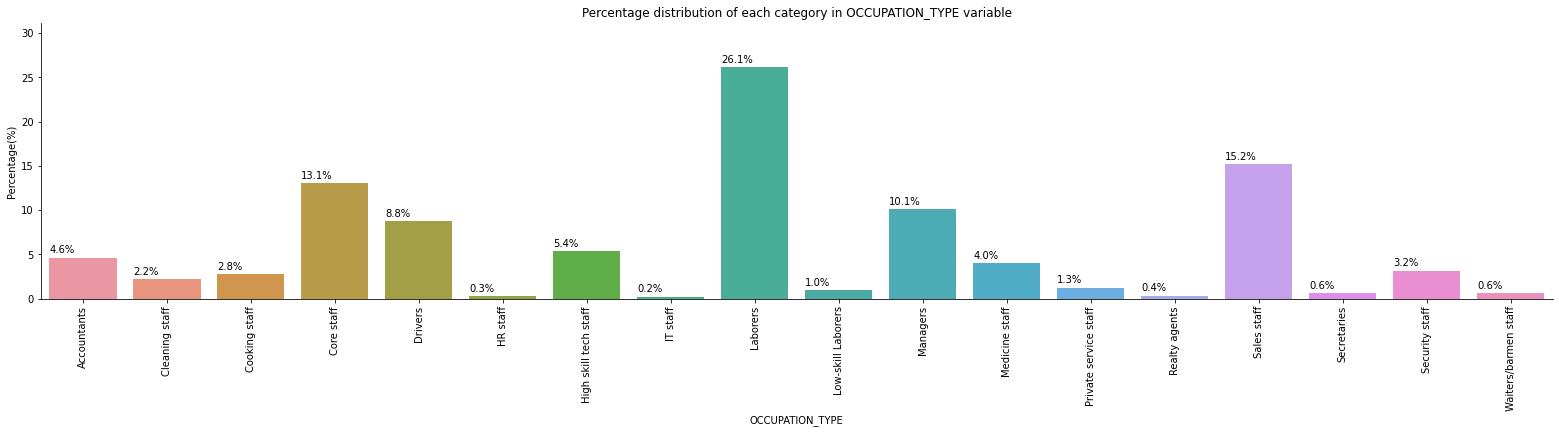

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


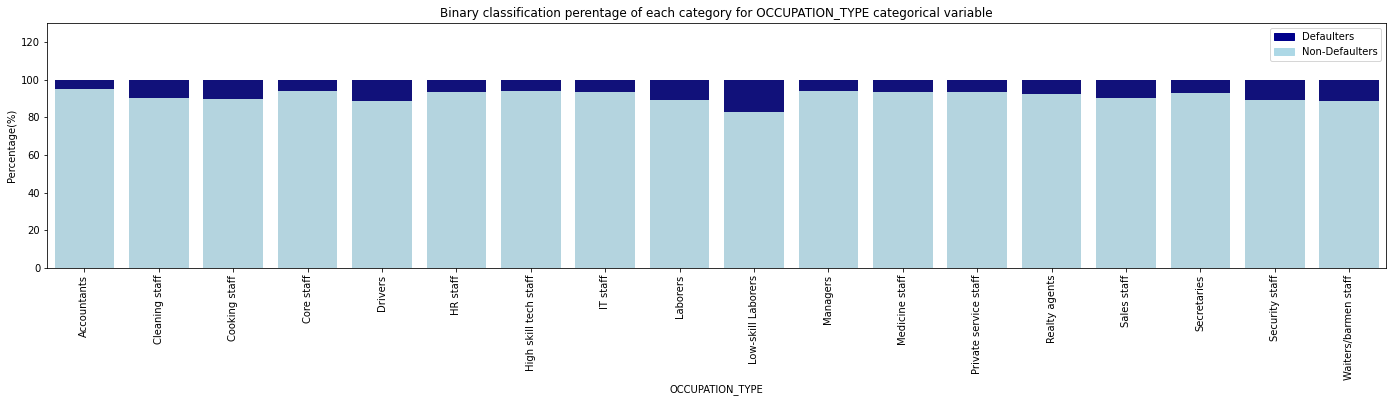

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


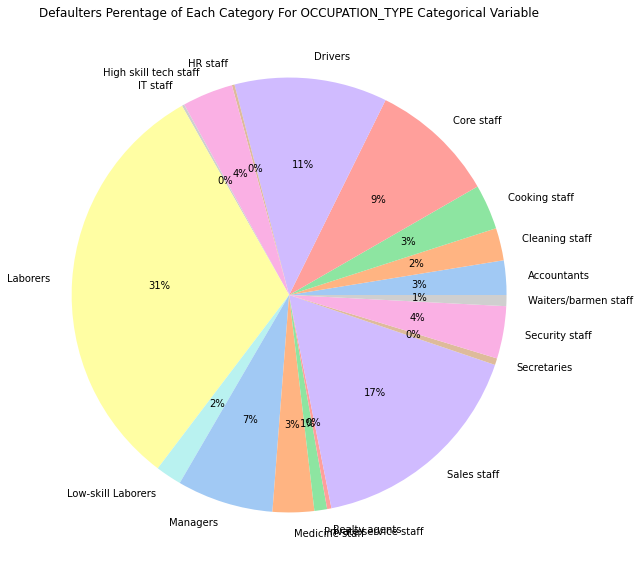

In [ ]:
# Occupation type
category_var_plot(application_train,application_top_categorical_var_lst[1])

**Observations and conclusions :**
1. For around 31% of samples, occupation type is not defined and these are greater than any other defined occupation type. Amongst these NaN values, 6.5% are defaulters.
2. For the defined categories, laborers constitute around 26% of samples and is the largest occupation type of the application followed by sales staff, core staff, managers, drivers and so on.
3. Total application percentage of low skill labores is only 1%, however this categorical applicants have the most defaulters percentage amongst all occupations when we look for percentage of defaulters in each occupation. This is followed by waiters/barmen staff, cooking staff and so on.
4. Pie chart shows the defaulters percentage in an entire data follows the similar distribution as observed in the count percentage bar plot. 
5. Laborers occupation has the largest count in the data and also has the overall largest defaulter percentage. Percentage of defaulters for laborers, sales staff, drivers is higher than their percentage count in the data. Managers, core staff shows an exactly opoosite behavior.

### Categorical Variable 2: ORGANIZATION_TYPE

Number of unique category values of ORGANIZATION_TYPE categorical variable are 58
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


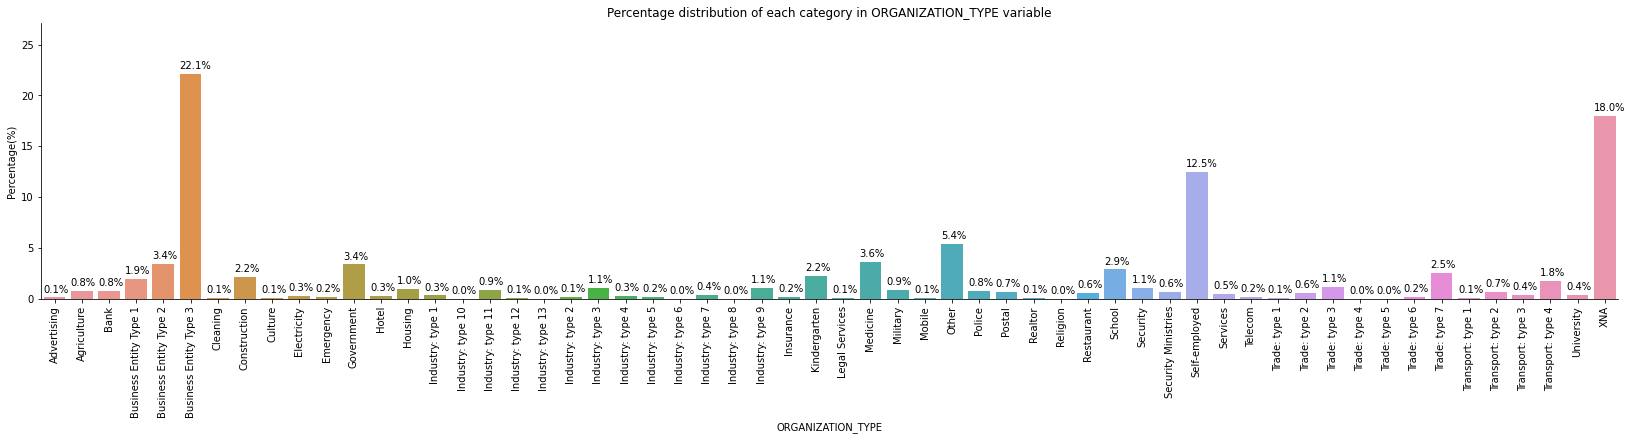

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


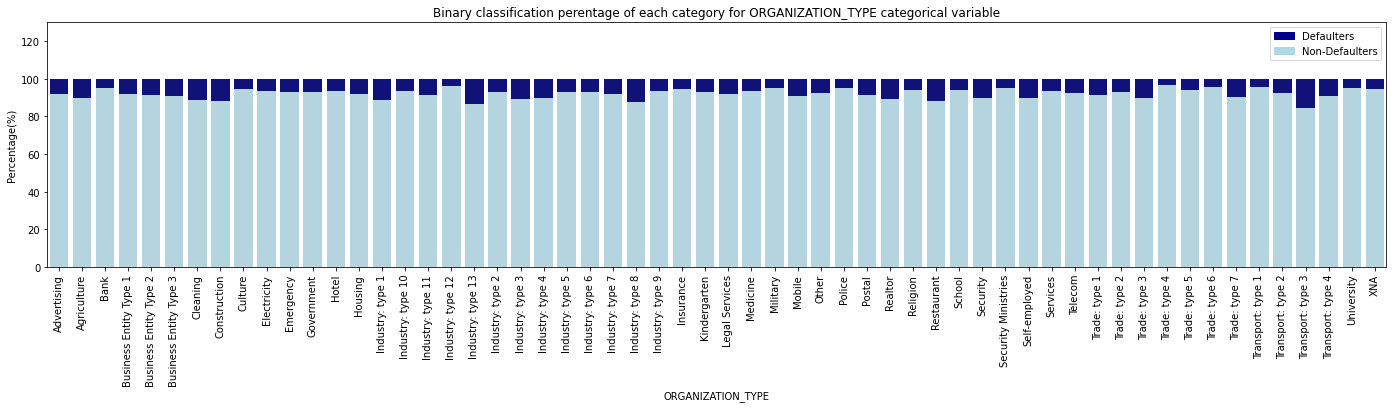

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


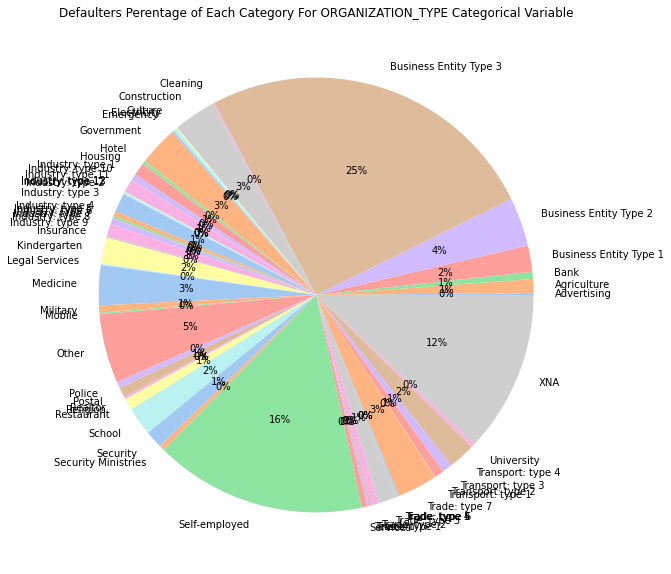

In [ ]:
# ORGANIZATION_TYPE
category_var_plot(application_train,application_top_categorical_var_lst[2])

**Observations and conclusions :**
1. For organization_type categorical variable total categories are 58 and all the samples are categorized i.e. none of the sample have NaN value.
2. Business entity type 3 is the largest organization type (22.1%) of apllicant followed by XNA (18%) , self employed (12.5%) and so on.
3. Similar distribution of defaulters is also observed from the pie chart as observed in the count bar plot. Business entity type 3 constitute 25% of total defaulted applicant. For self employed this number is 16% and for XNA it is 12%.
4. If we look for percentage of defaulters for each category, transport type 3, industry type 7, industry type 13, construction, restaurant are the high defaulted categories.

### Categorical Variable 3: NAME_INCOME_TYPE

Number of unique category values of NAME_INCOME_TYPE categorical variable are 8
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


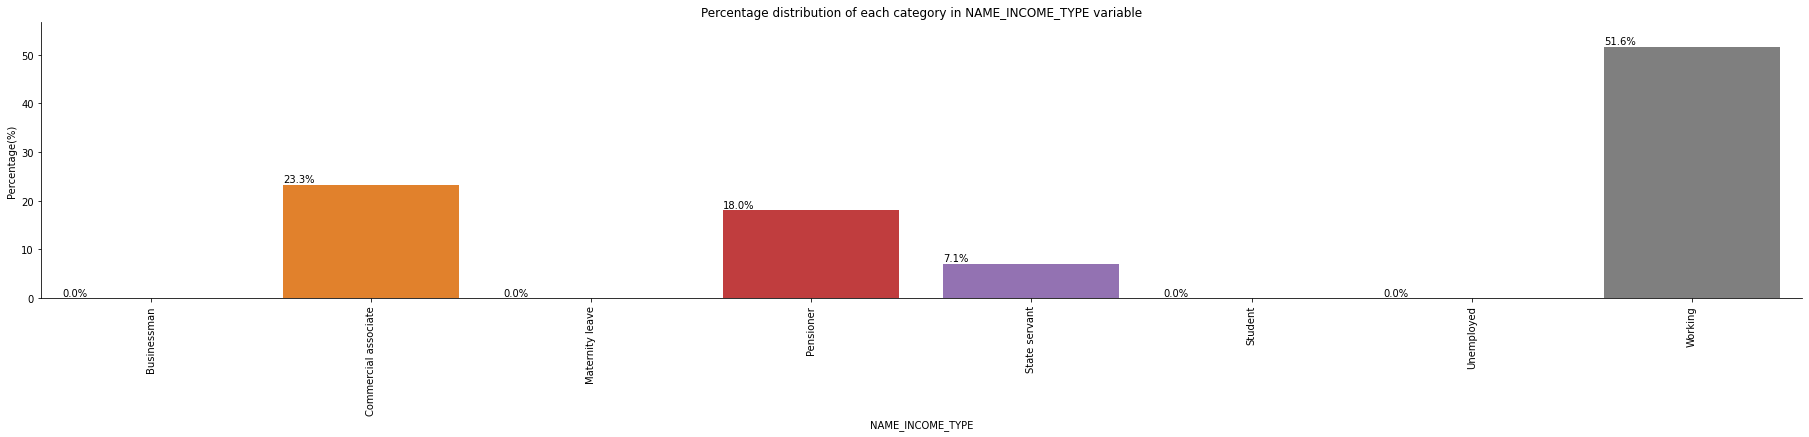

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


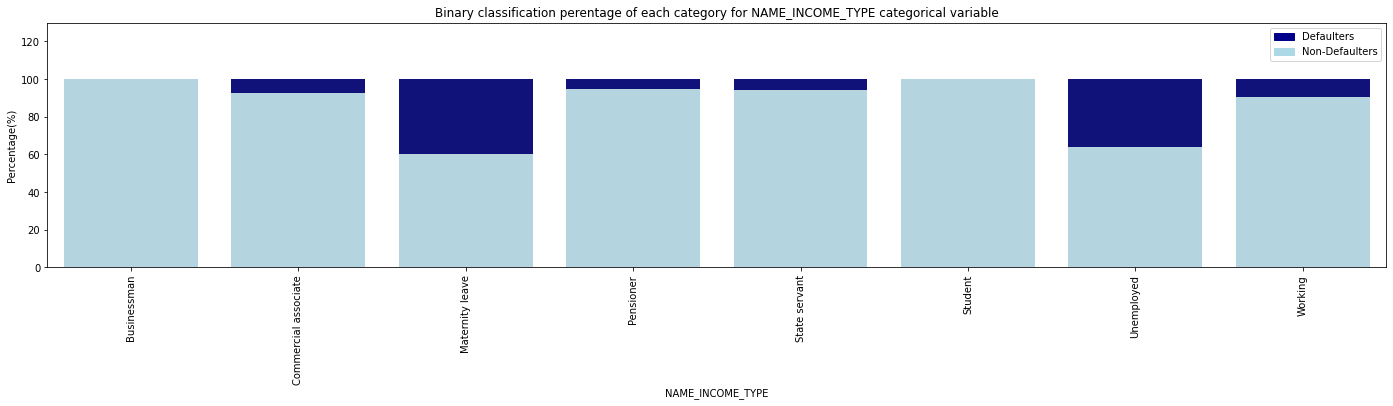

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


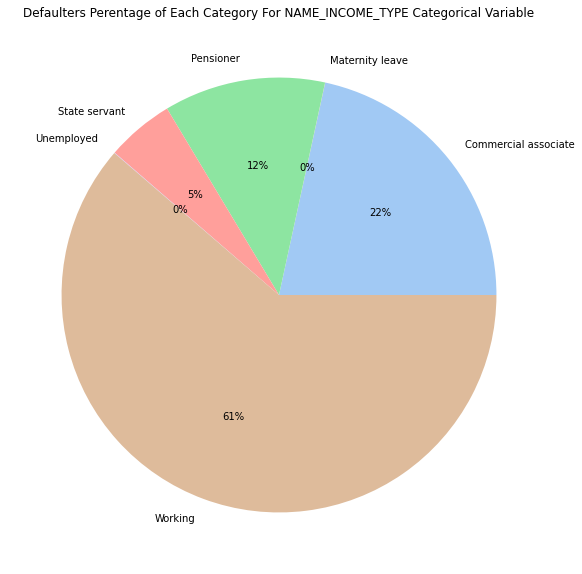

In [ ]:
# NAME_INCOME_TYPE
category_var_plot(application_train,application_top_categorical_var_lst[3])

** Observations and conclusions :**
1. For income type categorical variable total categories are 8 and all the samples are categorized i.e. none of the sample have NaN value.
2. Working is the largest income type (51.6%) of apllicant followed by comercial associate (23.3%) , pensioners (18%) and so on.
3. Similar distribution of defaulters is also observed from the pie chart as observed in the count bar plot. Working constitute 61% of total defaulted applicant. For commercial associate this number is 22% and for pensioners it is 12%.
4. If we look for percentage of defaulters for each category, maternity leave and unemployed income type shows the highest defaulters. However for this categories count of applicant is almost 0. For students, there is not a single defaulters and applicant are almot 0%.
5. For smalller count, decision can be taken to combine these categories while featurizing.

### Categorical Variable 4,5 and 6: REG_CITY_NOT_WORK_CITY, REG_CITY_NOT_LIVE_CITY, LIVE_CITY_NOT_WORK_CITY

Number of unique category values of REG_CITY_NOT_WORK_CITY categorical variable are 2
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


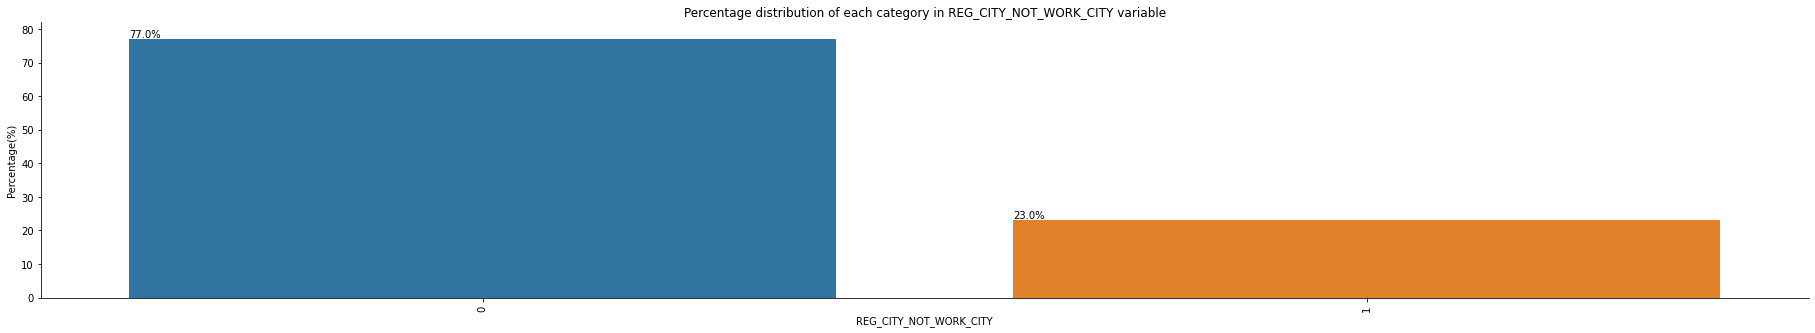

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


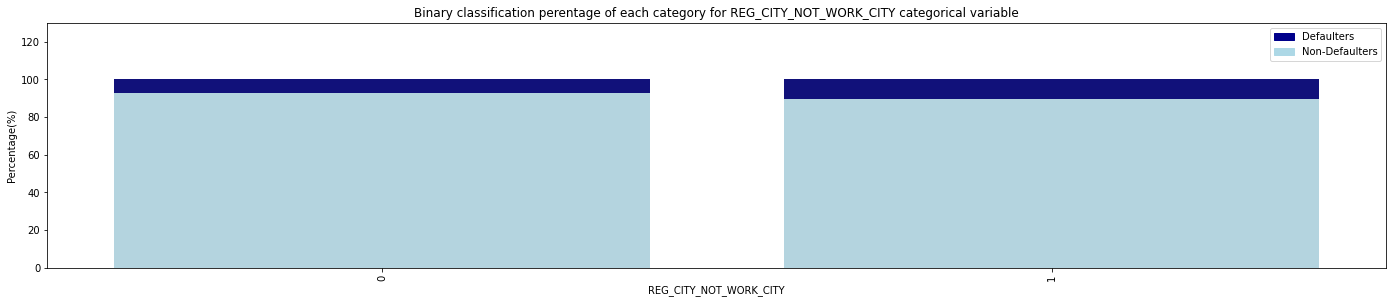

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


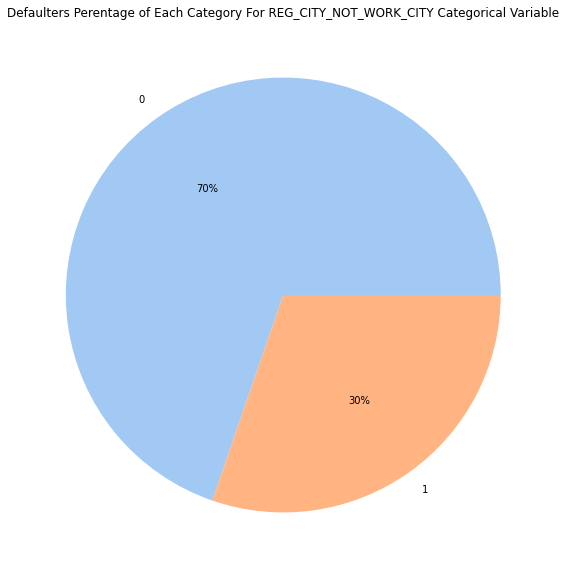

Number of unique category values of REG_CITY_NOT_LIVE_CITY categorical variable are 2
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


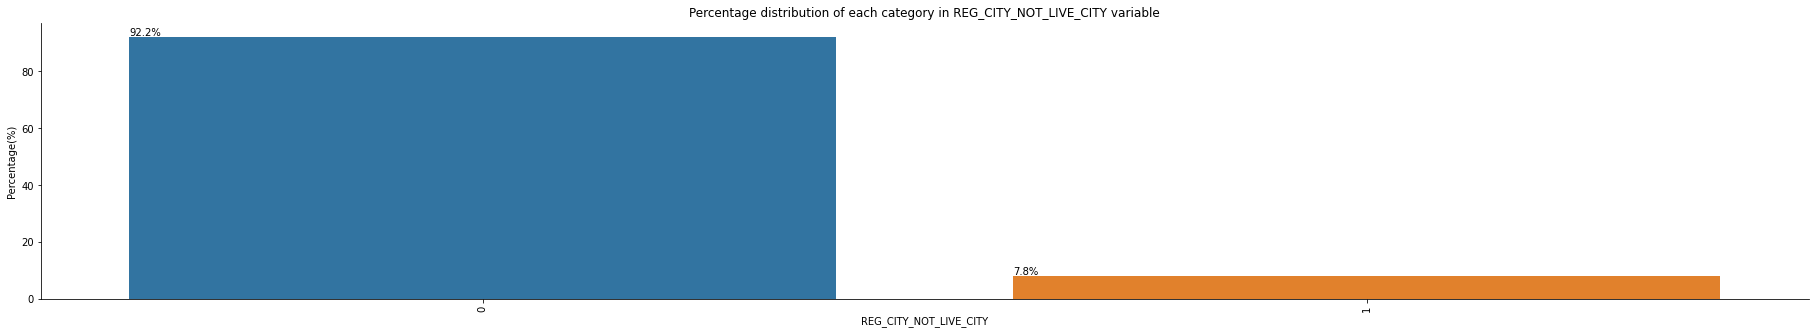

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


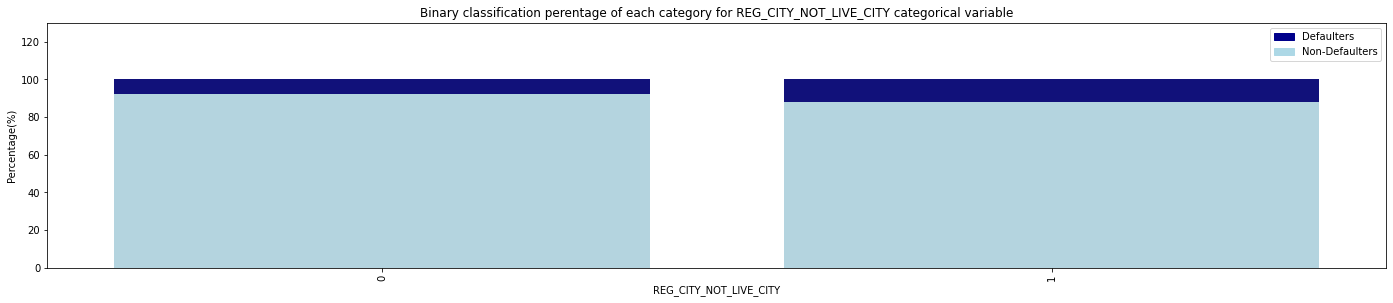

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


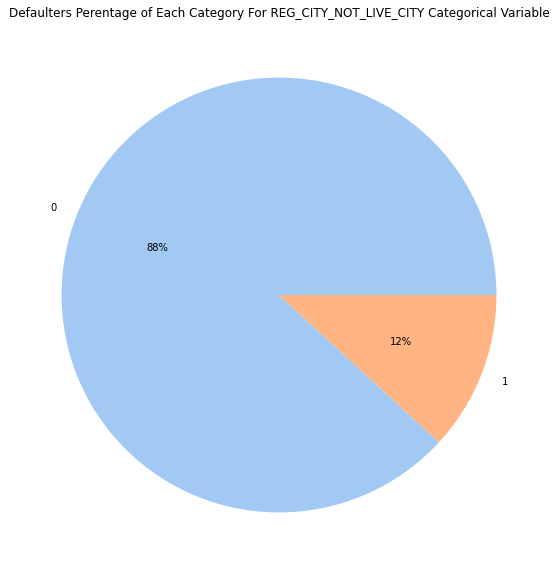

Number of unique category values of LIVE_CITY_NOT_WORK_CITY categorical variable are 2
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


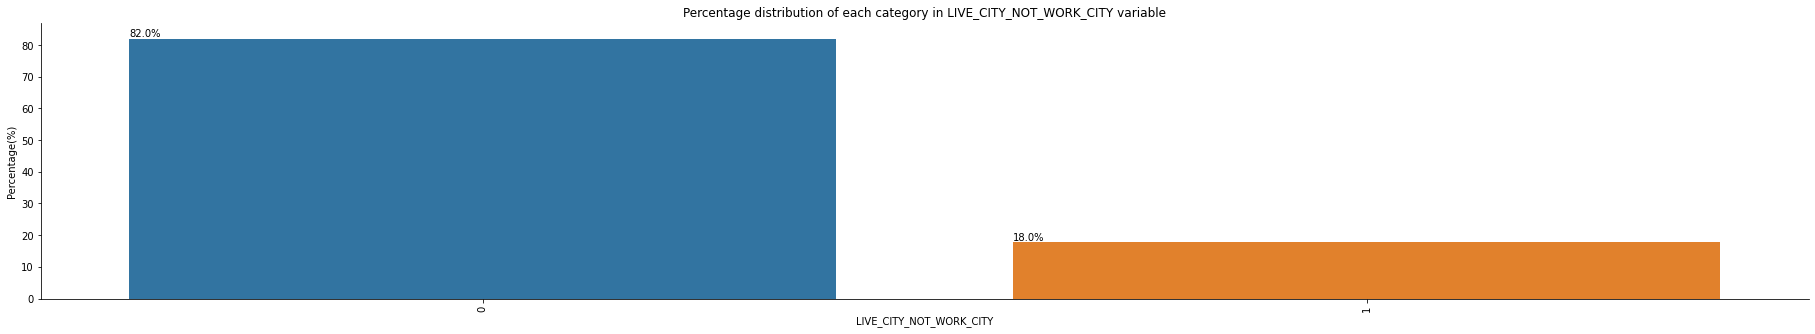

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


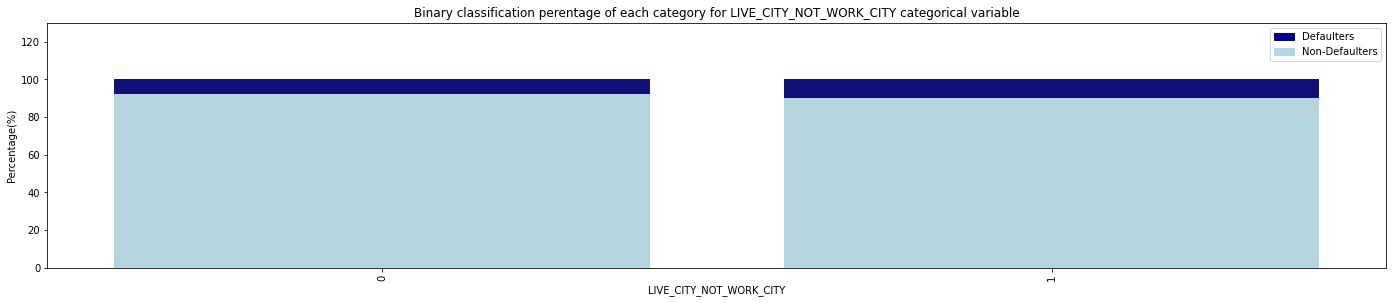

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


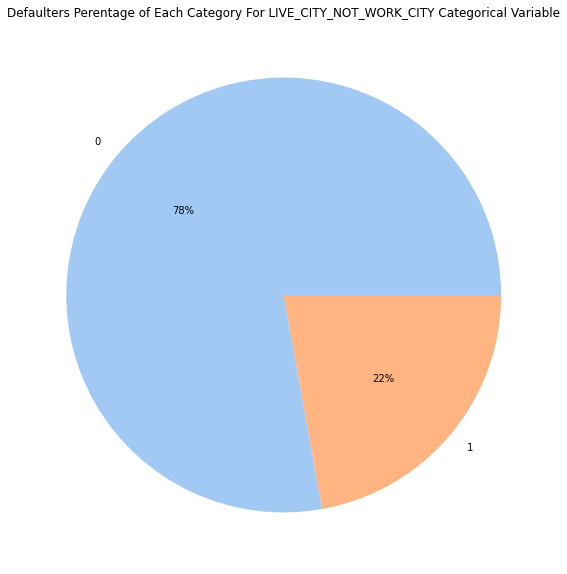

In [ ]:
# REG_CITY_NOT_WORK_CITY
category_var_plot(application_train,application_top_categorical_var_lst[4])
# REG_CITY_NOT_LIVE_CITY
category_var_plot(application_train,application_top_categorical_var_lst[6])
# LIVE_CITY_NOT_WORK_CITY
category_var_plot(application_train,application_top_categorical_var_lst[10])

**Observations and conclusions :**
1. Three categorical variables REG_CITY_NOT_WORK_CITY, REG_CITY_NOT_LIVE_CITY, LIVE_CITY_NOT_WORK_CITY have binary values either 0 or 1.
2. All the samples in these categories are categorized in the binary classes.
3. REG_CITY_NOT_WORK_CITY has value equal to 1 when applicants permenant address is different than the work address otherwise has 0 value. 
4. REG_CITY_NOT_LIVE_CITY has value equal to 1 when applicants permenant address is different than the contact address otherwise has 0 value. 
5. LIVE_CITY_NOT_WORK_CITY has value equal to 1 when applicants contact address is different than the work address otherwise has 0 value.
6. Most of the applicants for these 3 variables have different addresses in these categorical variables.
7. Percentage count of defaulters are also high for different address applicant as observed from the pie chart.
8. However when we look at each categories percentage defaulters for these 3 variables, applicants having these addresses same are defaulting more than the applicants with different addresses as observed in the stacked bar plot. 


### Categorical Variable 7: FLAG_EMP_PHONE

Number of unique category values of FLAG_EMP_PHONE categorical variable are 2
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


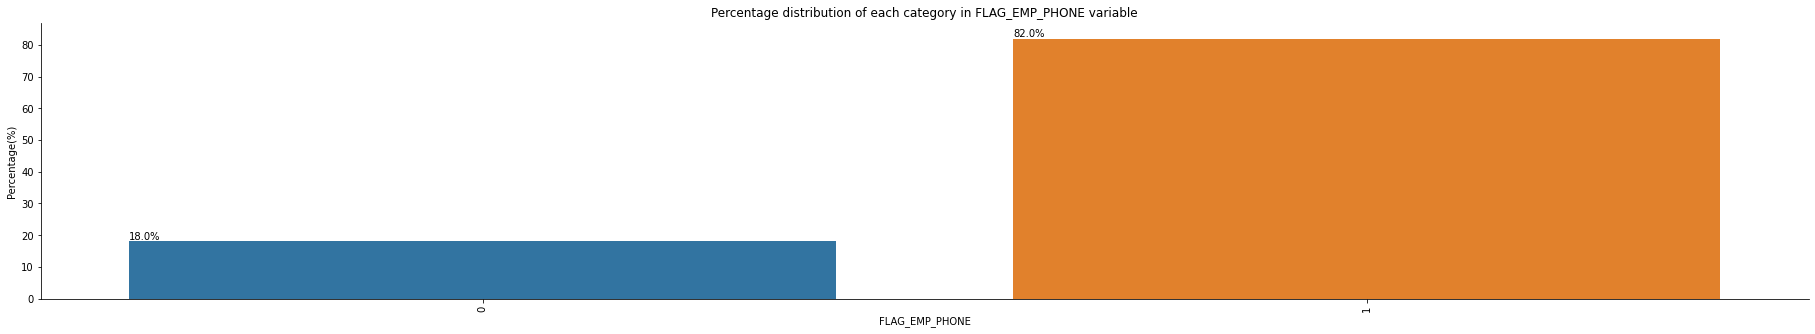

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


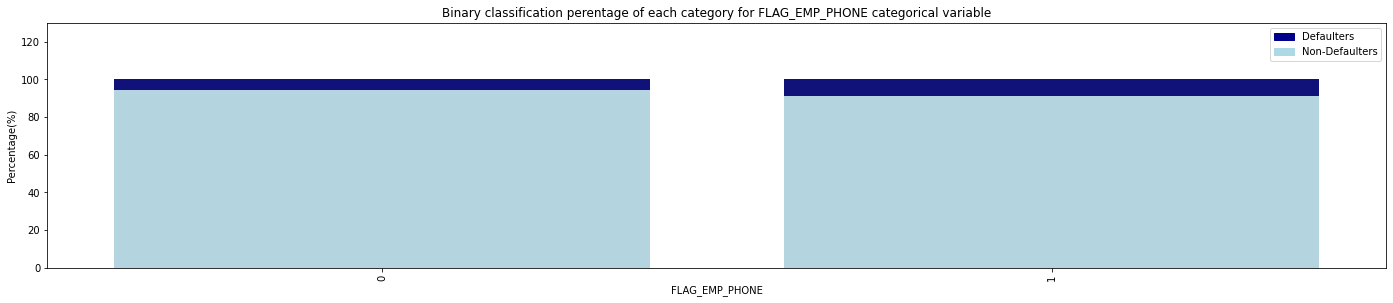

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


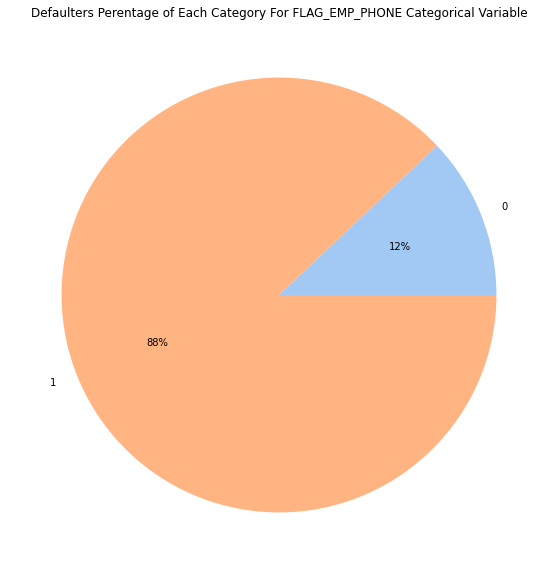

In [ ]:
# FLAG_EMP_PHONE
category_var_plot(application_train,application_top_categorical_var_lst[5])

**Observations and conclusions :**
1. For FLAG_EMP_PHONE categorical variable total categories are 2 and all the samples are categorized i.e. none of the sample have NaN value.
2. These binary categories are 0 or 1.
3. FLAG_EMP_PHONE states - does client provided work phone and assigns value 1 to yes and 0 to no
4. 82% of applicant have provided the work phone while 28% have not provided the work phone.
5. Out of the total defaulters 88% defaulters have provided the work phone.
6. If we look for percentage of defaulters for each category, type 1 (applicant who have provided work phone) has higher percentage defaulters than the type 0.

### Categorical Variable 8: FLAG_DOCUMENT_3

Number of unique category values of FLAG_DOCUMENT_3 categorical variable are 2
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


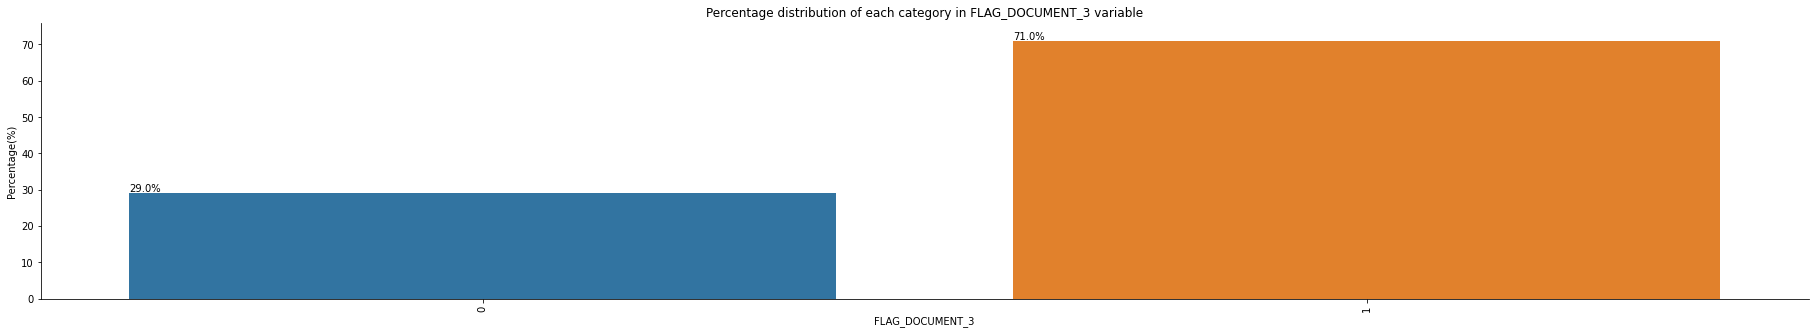

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


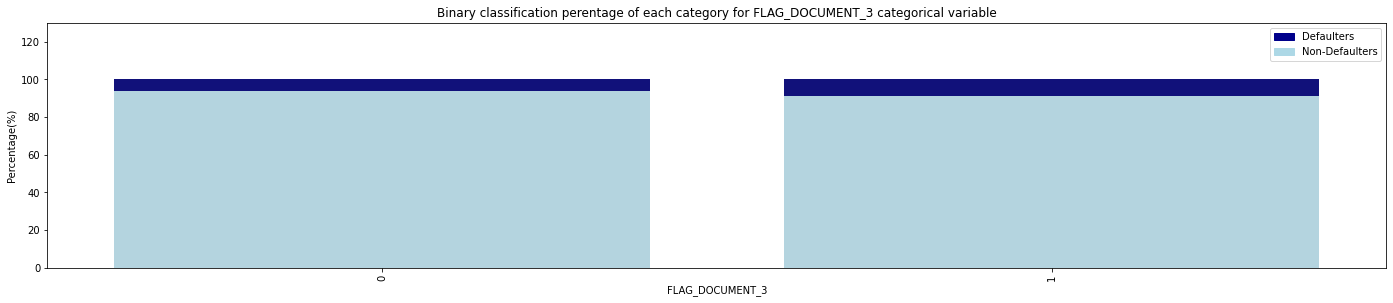

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


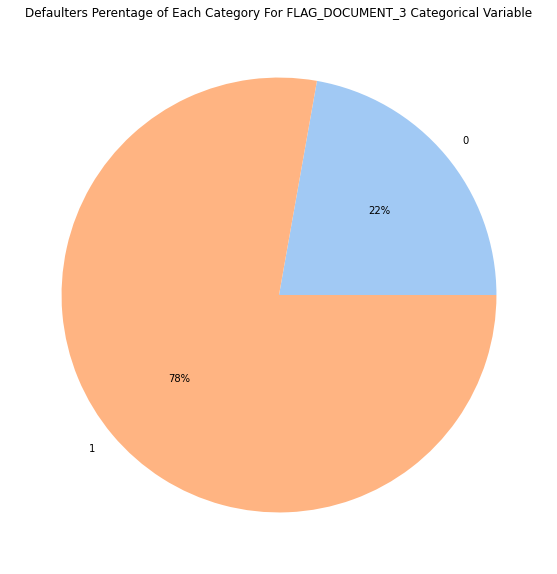

In [ ]:
# FLAG_DOCUMENT_3
category_var_plot(application_train,application_top_categorical_var_lst[7])

**Observations and conclusions :**
1. For FLAG_DOCUMENT_3 categorical variable total categories are 2 and all the samples are categorized i.e. none of the sample have NaN value.
2. These binary categories are 0 or 1.
3. FLAG_DOCUMENT_3 states - does client provided document 3 and assigns value 1 to yes and 0 to no
4. Largest population of applicant has provided document 3 (71%) and also has the largest defaulters population (78%)
5. It is observed from stacked bar plot that the percentage of defaulted categories is higher for applicant who have provided document 3.

### Categorical Variable 9: NAME_FAMILY_STATUS

Number of unique category values of NAME_FAMILY_STATUS categorical variable are 6
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


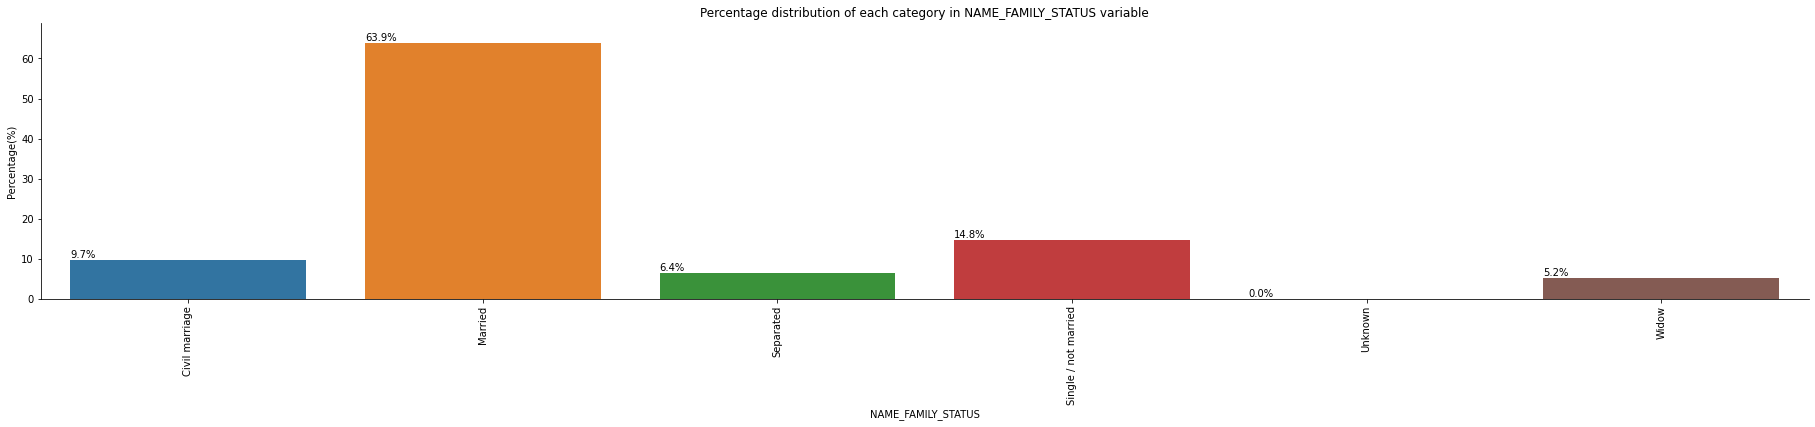

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


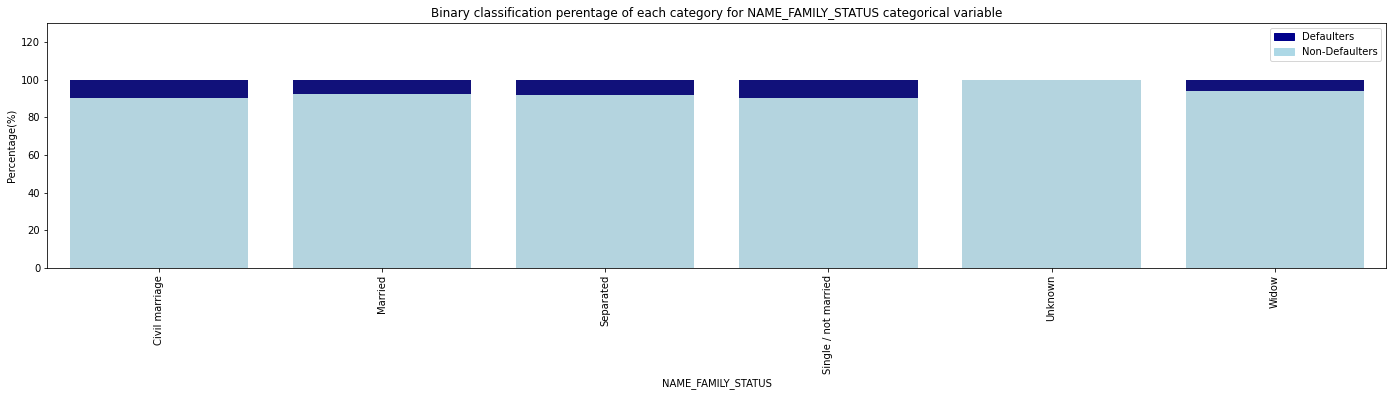

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


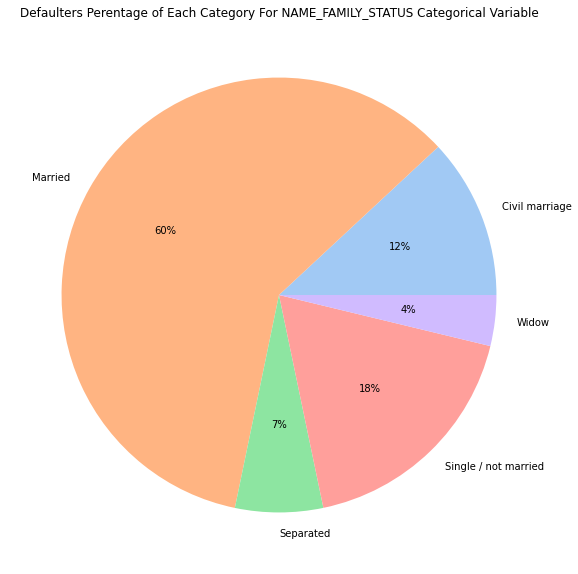

In [ ]:
# NAME_FAMILY_STATUS
category_var_plot(application_train,application_top_categorical_var_lst[8])

**Observations and conclusions :**
1. For family status type categorical variable total categories are 6 and all the samples are categorized i.e. none of the sample have NaN value.
2. Married is the largest income type (63.9%) of apllicant followed by single/not married (14.8%) , civil marriage (9.7%) and so on. Unknown family status count is almost 0 and does not have any defaulters.
3. Similar distribution of defaulters is also observed from the pie chart as observed in the count bar plot. Married constitute 60% of total defaulted applicant. For single or not married this number is 18% and for civil marriage, it is 12%.
4. If we look for percentage of defaulters for each category, civil marriage and single/not married have defaulted more than the married category.

### Categorical Variable 10: NAME_HOUSING_TYPE

Number of unique category values of NAME_HOUSING_TYPE categorical variable are 6
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


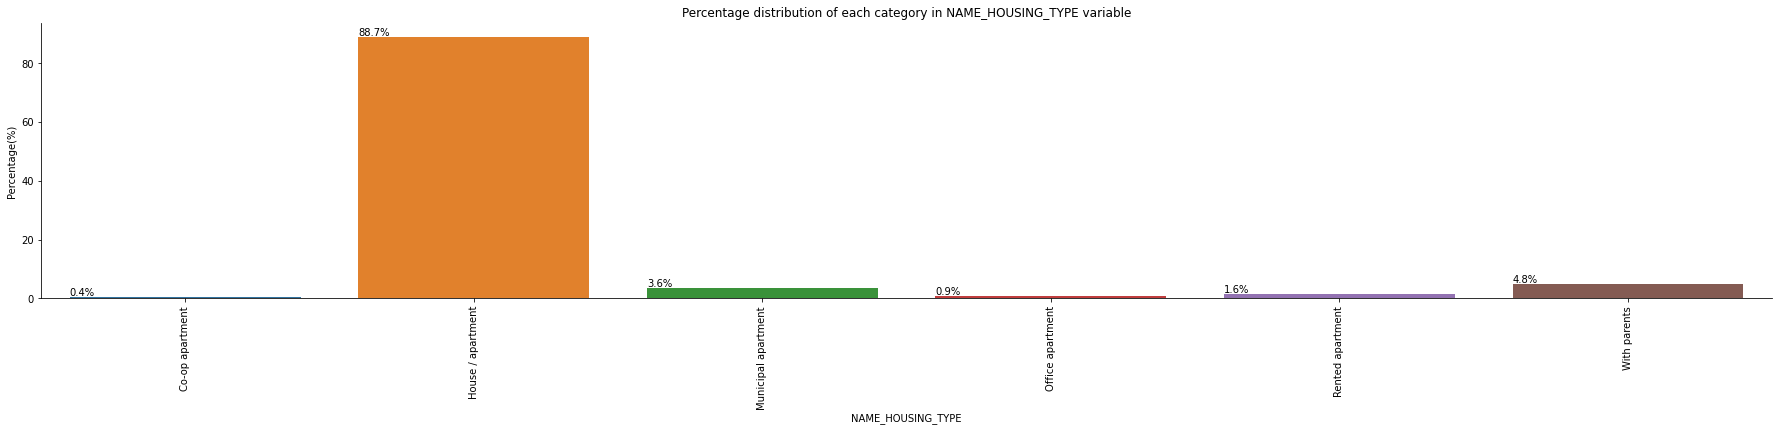

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


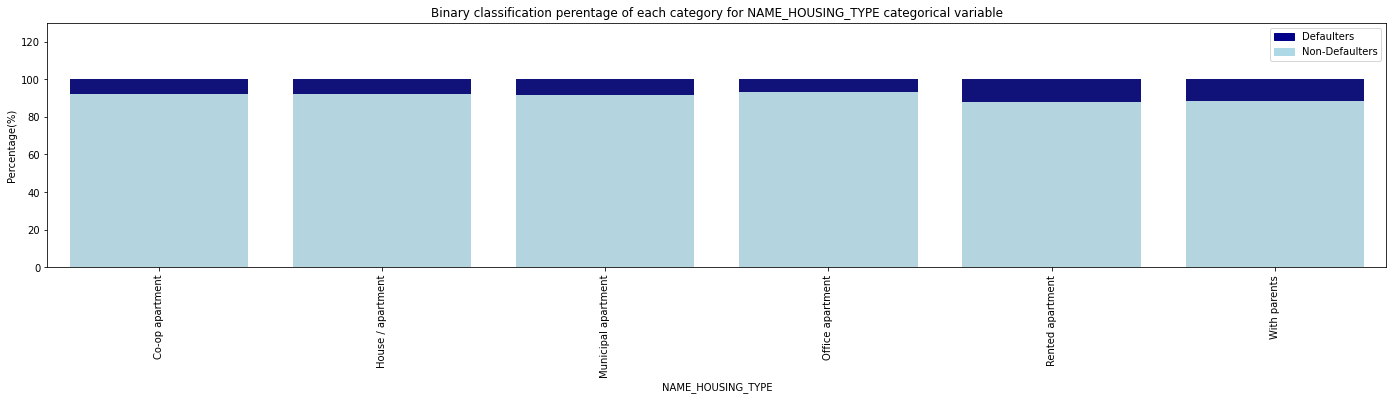

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


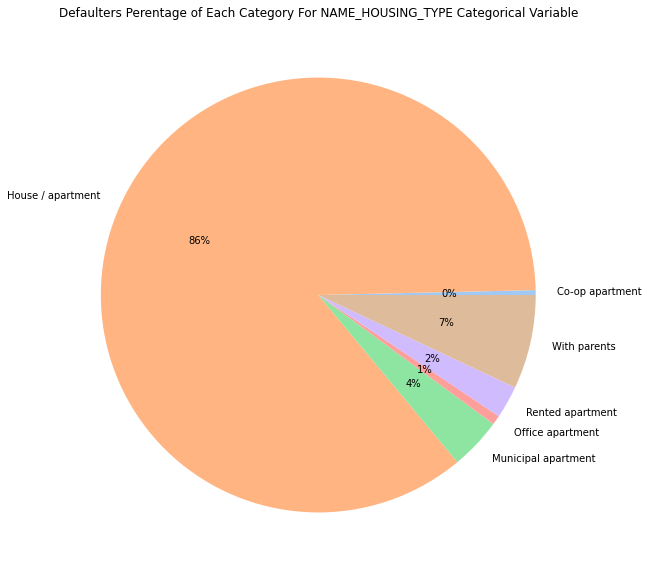

In [ ]:
# NAME_HOUSING_TYPE
category_var_plot(application_train,application_top_categorical_var_lst[9])

**Observations and conclusions :**
1. For housing type categorical variable total categories are 6 and all the samples are categorized i.e. none of the sample have NaN value.
2. House/apartment is the largest housing type (88.7%) of apllicant followed by with parents (4.8%), muncipal apartment (3.6%). Rest of the categories have very small count (< 1%)
3. Similar distribution of defaulters is also observed from the pie chart as observed in the count bar plot. House / apratment constitute 86% of total defaulted applicant. For with parents this number is 7% and for muncipal apartment, it is 4%.
4. If we look for percentage of defaulters for each category, muncipal apartment, rented apartment and with parents have defaulted more than the house/apartment category.

## Application Train Continuous Variable Plots

### Continuous Variable 1: EXT_SOURCE_3

Continuous variable EXT_SOURCE_3 has 60965 NaN rows.
Percentage of NaN rows for EXT_SOURCE_3 continuous variable are 19.83 %
Percentage of 0 labels for NaN value row is 90.69 %
Percentage of 1 labels for NaN value row is 9.31 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


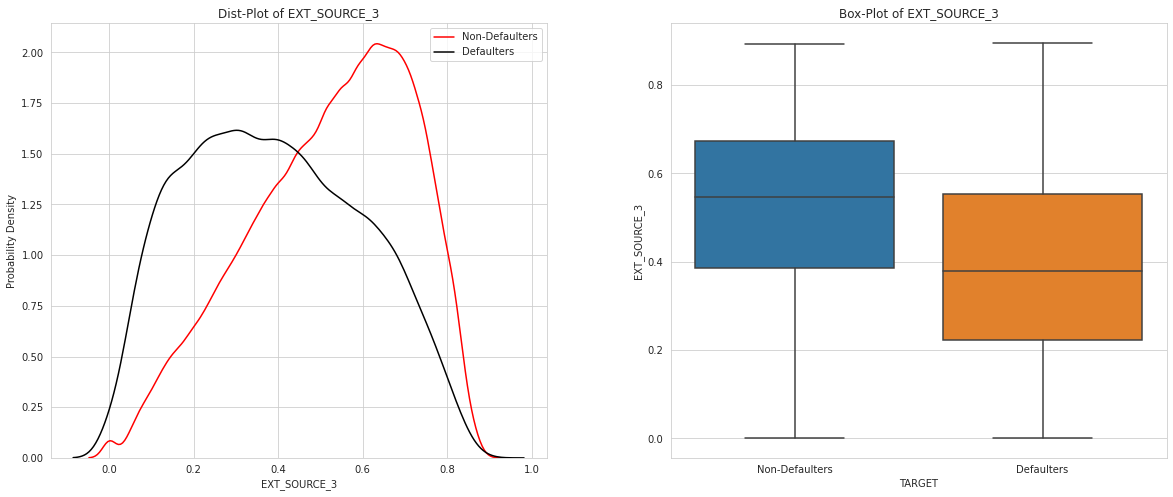

In [ ]:
# EXT_SOURCE_3 
plot_continuous_variables(application_train,application_top_continuous_var_lst[1])

**Observations and Conclusions :**  
1. This variable represents the normalized score of application from external data source.
2. Row samples of EXT_SOURCE_3  continuous variable have 19.83% have NaN values. Out of these NaN valued row samples, around 90.69% are non defaulters while 9.31% are defaulters.
3. Probability density plot of non defaulters is left skewed while that of defaulters is right skewed.Range of values for both of these categories lies between 0 to 0.9 .
4. Intequertile range of non defaulters box plot is from 0.39 to 0.68 while that of defaulters is from 0.22 to 0.52. This is an evident that for smaller values of this variable, there are more chances of defaulting the loan.
5. Median values of non defaulters is higher than the defaulter. This value can be used for imputing the NaN samples. 

### Continuous Variable 2: EXT_SOURCE_2 

Continuous variable EXT_SOURCE_2 has 660 NaN rows.
Percentage of NaN rows for EXT_SOURCE_2 continuous variable are 0.21 %
Percentage of 0 labels for NaN value row is 92.12 %
Percentage of 1 labels for NaN value row is 7.88 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


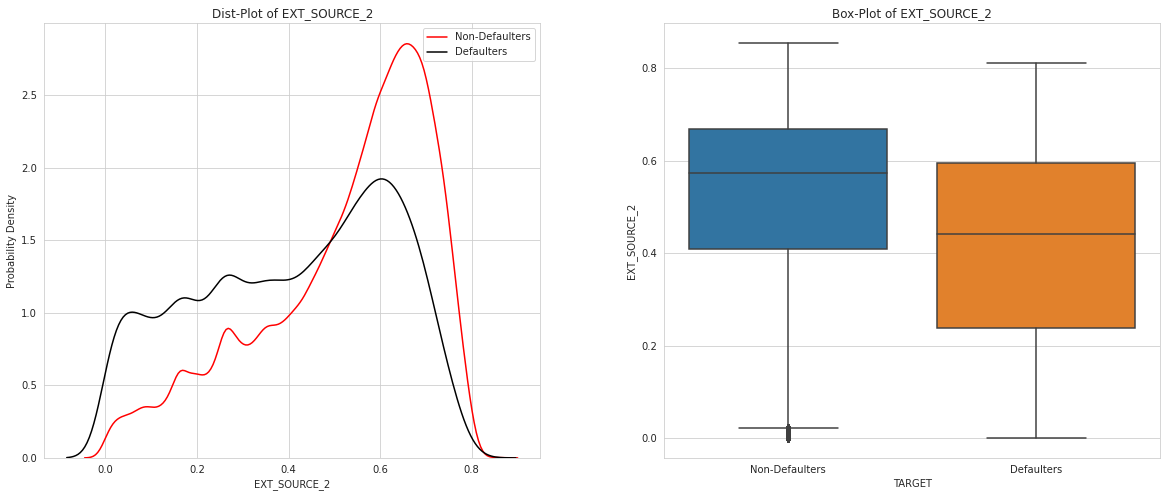

In [ ]:
# EXT_SOURCE_2  
plot_continuous_variables(application_train,application_top_continuous_var_lst[2])

**Observations and Conclusions :**  
1. This variable represents the normalized score of application from external data source.
2. Row samples of EXT_SOURCE_2   continuous variable have 0.21% have NaN values. Out of these NaN valued row samples, around 92.12% are non defaulters while 7.88% are defaulters.
3. Probability density plot of non defaulters and defaulters is left skewed. Range of values for both of these categories lies between 0 to 0.9 . Non defaulters shows higher density within the range 0.6 to 0.8 than defaulters.
4. Intequertile range of non defaulters box plot is from 0.41 to 0.68 while that of defaulters is from 0.24 to 0.6. This is an evident that for smaller values of this variable, there are more chances of defaulting the loan.
5. Median values of non defaulters is higher than the defaulter. This value can be used for imputing the NaN samples. 

### Continuous Variable 3: EXT_SOURCE_1  

Continuous variable EXT_SOURCE_1 has 173378 NaN rows.
Percentage of NaN rows for EXT_SOURCE_1 continuous variable are 56.38 %
Percentage of 0 labels for NaN value row is 91.48 %
Percentage of 1 labels for NaN value row is 8.52 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


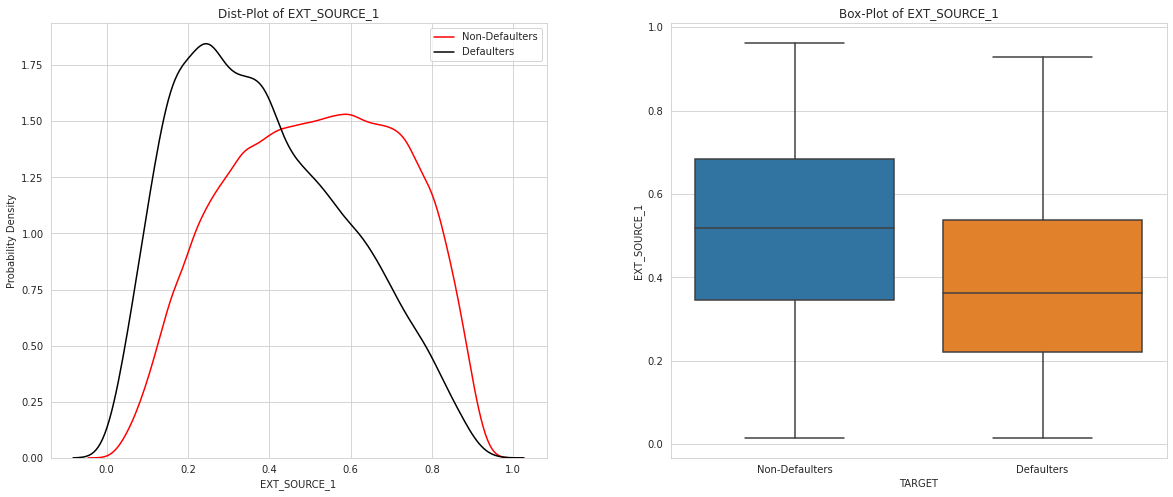

In [ ]:
# EXT_SOURCE_1   
plot_continuous_variables(application_train,application_top_continuous_var_lst[3])

**Observations and Conclusions :**  
1. This variable represents the normalized score of application from external data source.
2. Row samples of EXT_SOURCE_2   continuous variable have 56.38% have NaN values. Out of these NaN valued row samples, around 91.48% are non defaulters while 8.52% are defaulters.
3. Probability density plot of non defaulters is right skewed while that of defaulters is uniformally distributed. Range of values for both of these categories lies between 0 to 0.9 . Non defaulters shows higher density around the 0.2 value.
4. Intequertile range of non defaulters box plot is from 0.36 to 0.68 while that of defaulters is from 0.22 to 0.56. This is an evident that for smaller values of this variable, there are more chances of defaulting the loan.
5. Median values of non defaulters is higher than the defaulter. This value can be used for imputing the NaN samples. 

### Continuous Variable 4: DAYS_BIRTH converted to age_birth
This variable represents the clients age in days at the time of application. THese days are relative to the application and are negative values. 

Clients age in days = birth data - application date

For interpretation of results we will convert the clients age in positive year values.

Continuous variable age_birth does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


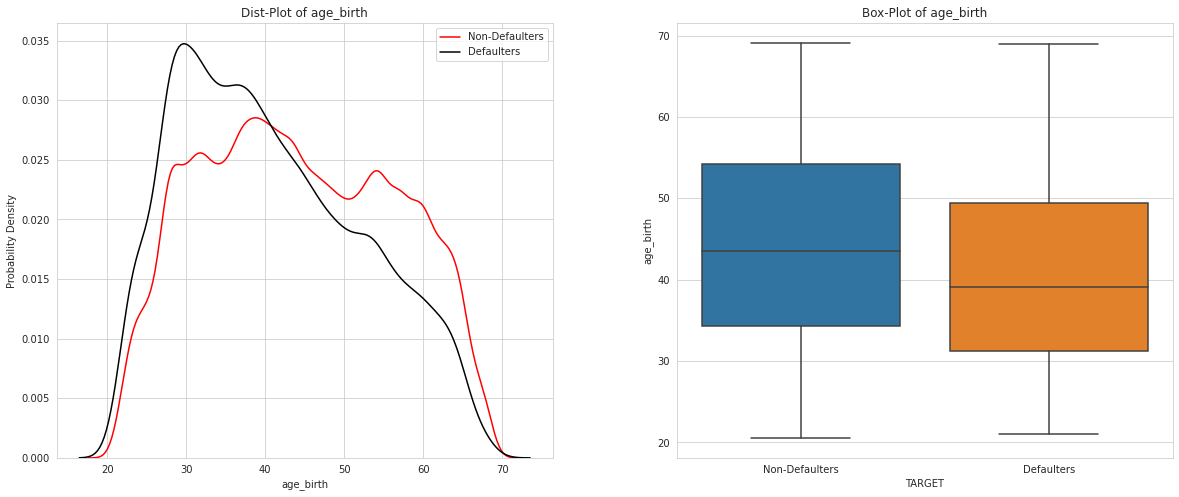

In [ ]:
# DAYS_BIRTH converted to age_birth
application_train["age_birth"]=application_train[application_top_continuous_var_lst[4]].abs()/365
plot_continuous_variables(application_train,"age_birth")
application_train=application_train.drop(["age_birth"],axis=1)

**Observations and Conclusions :**  
1. Row samples of age_birth continuous variable do not have any NaN values.
2. Probability density plot of non defaulters is uniformaly distributed while defaulters plot is right skewed. Also is is shows peak at around age 30.
3. Intequertile range of non defaulters box plot is from 35 to 53 age while that of defaulters is from 32 to 49. This is an evident that younger applicant are higher probable to be defaulter than non defaulter.
4. Minimum and maximum values of both the categories of applicants are same. 

### Continuous Variable 5: DAYS_LAST_PHONE_CHANGE to years last phone change 
This variable tells how many days before the application did client changed the phone.

DAYS_LAST_PHONE_CHANGE = phone change data - application date

For interpretation of results we will convert the DAYS_LAST_PHONE_CHANGE in positive year values.

Continuous variable Year_LAST_PHONE_CHANGE has 1 NaN rows.
Percentage of NaN rows for Year_LAST_PHONE_CHANGE continuous variable are 0.0 %
All the labels of NaN rows are  0
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


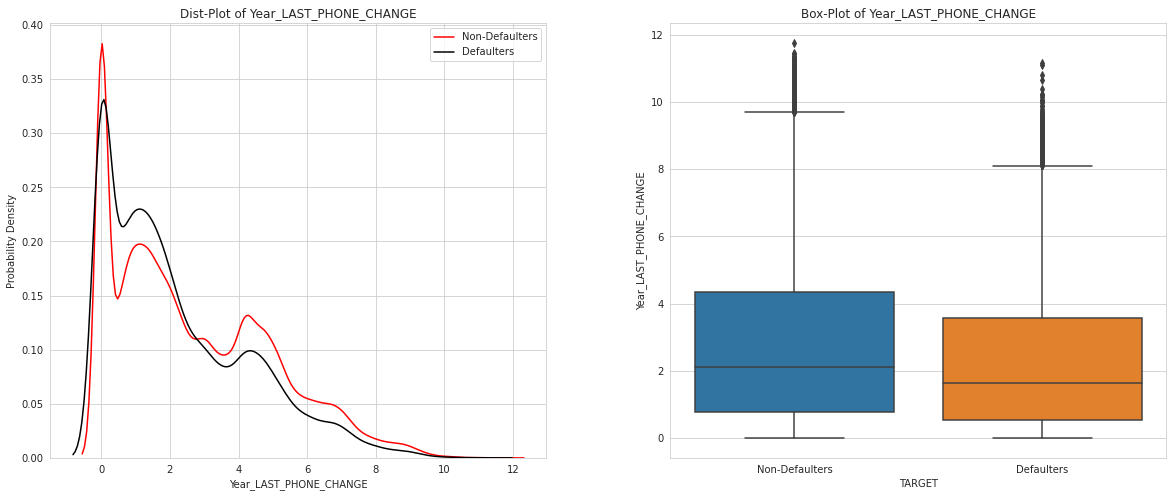

In [ ]:
# DAYS_LAST_PHONE_CHANGE to years last phone change
application_train["Year_LAST_PHONE_CHANGE"]=application_train[application_top_continuous_var_lst[5]].abs()/365
plot_continuous_variables(application_train,"Year_LAST_PHONE_CHANGE")
application_train=application_train.drop(["Year_LAST_PHONE_CHANGE"],axis=1)

**Observations and Conclusions :**  
1. Row samples of Year_LAST_PHONE_CHANGE continuous variable have a single NaN value row which is labeled as non defaulter.
2. Probability density plot of non defaulters and defaulter is right skewed with higher peak of non defaulter aroung 0 year.
3. Intequertile range of non defaulters box plot is from 0.8 to 4.5 years while that of defaulters is from 0.5 to 3.7 years. Clients with recent phone changes are more probable to default thatn the others.
4. Non defaulters have extreme max values of years since last phone changed which can be observed through values outside the box plot interquartile range. 

### Continuous Variable 6: DAYS_ID_PUBLISH to Year_ID_PUBLISH 
This variable tells how many days before the application did client changed identity document.

DAYS_ID_PUBLISH = ID change date - application date

For interpretation of results we will convert the DAYS_ID_PUBLISH in positive year values.

Continuous variable Year_ID_PUBLISH does not have NaN rows.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


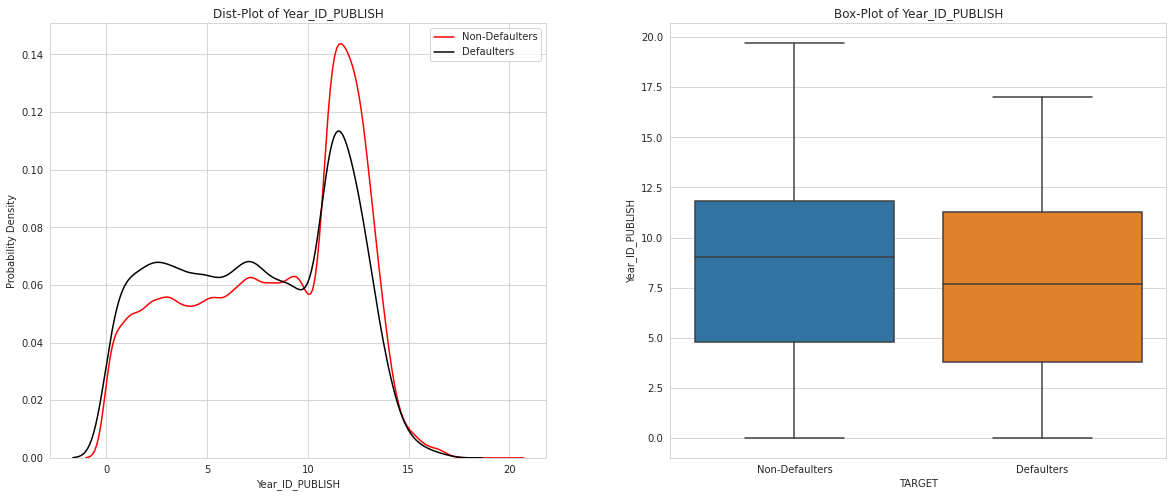

In [ ]:
# DAYS_ID_PUBLISH to Year_ID_PUBLISH
application_train["Year_ID_PUBLISH"]=application_train[application_top_continuous_var_lst[6]].abs()/365
plot_continuous_variables(application_train,"Year_ID_PUBLISH")
application_train=application_train.drop(["Year_ID_PUBLISH"],axis=1)

**Observations and Conclusions :**  
1. Row samples of Year_ID_PUBLISH continuous variable does not have any NaN value row.
2. Observations for this variable and year last phone change variable are similar.
2. Probability density plot of non defaulters shows a higher peak in values between 10 to 15 years than the defaulters.
3. We can observ a small difference in interquartile age range values of non defaulters and defaulters.
4. Non defaulters have extreme max values of years since last ID changed which can be observed through values outside the box plot interquartile range. 

### Continuous Variable 7: DAYS_EMPLOYED  to YEARS_EMPLOYED 
This variable tells how many days before the application did client started the current employment.

DAYS_EMPLOYED = Current employment start date - application date

For interpretation of results we will convert the DAYS_EMPLOYED in positive year values.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The 0th percentile value of YEARS_EMPLOYED is 0.0
The 25th percentile value of YEARS_EMPLOYED is 2.5561643835616437
The 50th percentile value of YEARS_EMPLOYED is 6.079452054794521
The 75th percentile value of YEARS_EMPLOYED is 15.635616438356164
The 80th percentile value of YEARS_EMPLOYED is 25.172602739726027
The 85th percentile value of YEARS_EMPLOYED is 1000.6657534246575
The 90th percentile value of YEARS_EMPLOYED is 1000.6657534246575
The 100th percentile value of YEARS_EMPLOYED is 1000.6657534246575
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Continuous variable YEARS_EMPLOYED does not have NaN rows.
---------------------------------------------------------

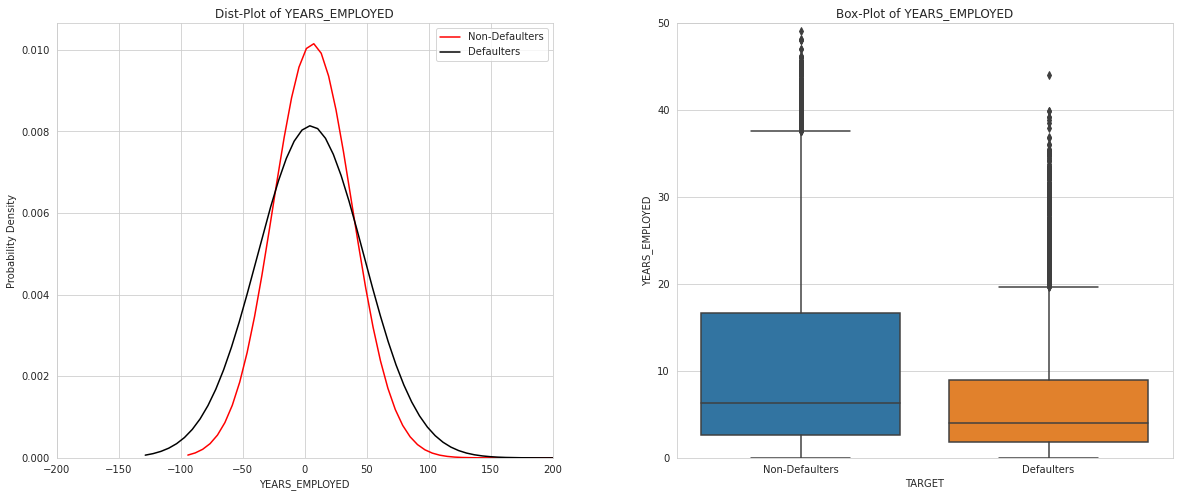

In [ ]:
# DAYS_EMPLOYED  to YEARS_EMPLOYED 
application_train["YEARS_EMPLOYED"]=application_train[application_top_continuous_var_lst[7]].abs()/365
print_percentiles(application_train,"YEARS_EMPLOYED",percentiles=[0,25,50,75,80,85,90,100])
plot_continuous_variables(application_train,"YEARS_EMPLOYED","Yes",(-200,200),(0,50))
application_train=application_train.drop(["YEARS_EMPLOYED"],axis=1)

**Observations and Conclusions :**  
1. Row samples of YEARS_EMPLOYED  continuous variable does not have any NaN value row.
2. 80th percentile covers the applicants from 0 years to 20.17 years. Most of the applicants have the current employment years between 0 to 50 years. Few of the outliers with high values such as 1000 years are also observed. These values constitute around 10 percentiles and are clearly the wrong data. This needs to be addressed while doing featurization. One way is to saturate to max 50 years.
2. Probability density plot of non defaulters and defaulters shows a bell shaped curve..
3. Interquartile range of non defaulters varies from 4 to 18 years while that of defaulters range from 3 to 9 years. This is an evident that, chances of newly emplyed applicant defaulting loan is higher. 

### Continuous Variable 8,9,10: FLOORSMAX_AVG, FLOORSMAX_MEDI, FLOORSMAX_MODE 

Continuous variable FLOORSMAX_AVG has 153020 NaN rows.
Percentage of NaN rows for FLOORSMAX_AVG continuous variable are 49.76 %
Percentage of 0 labels for NaN value row is 90.81 %
Percentage of 1 labels for NaN value row is 9.19 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


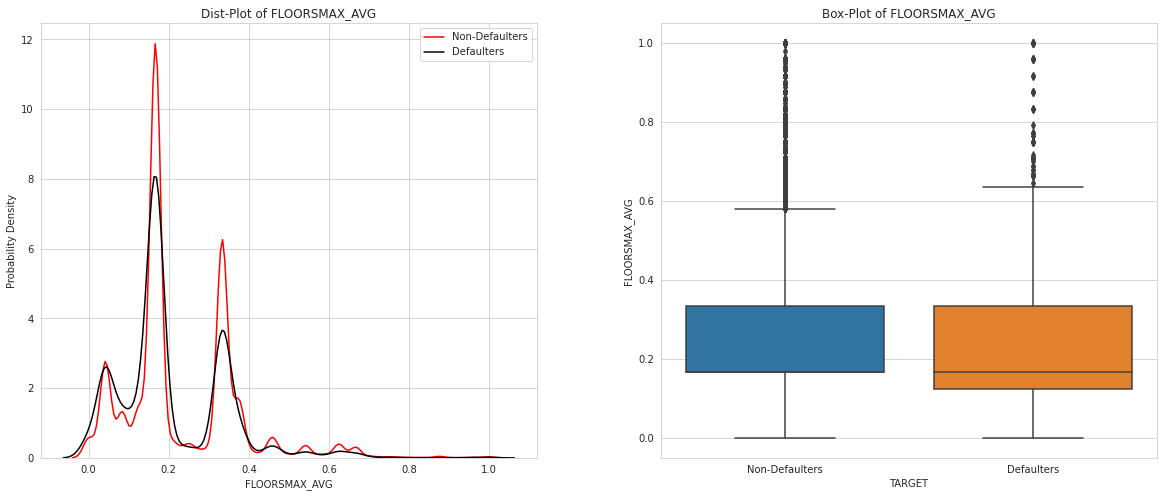

Continuous variable FLOORSMAX_MEDI has 153020 NaN rows.
Percentage of NaN rows for FLOORSMAX_MEDI continuous variable are 49.76 %
Percentage of 0 labels for NaN value row is 90.81 %
Percentage of 1 labels for NaN value row is 9.19 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


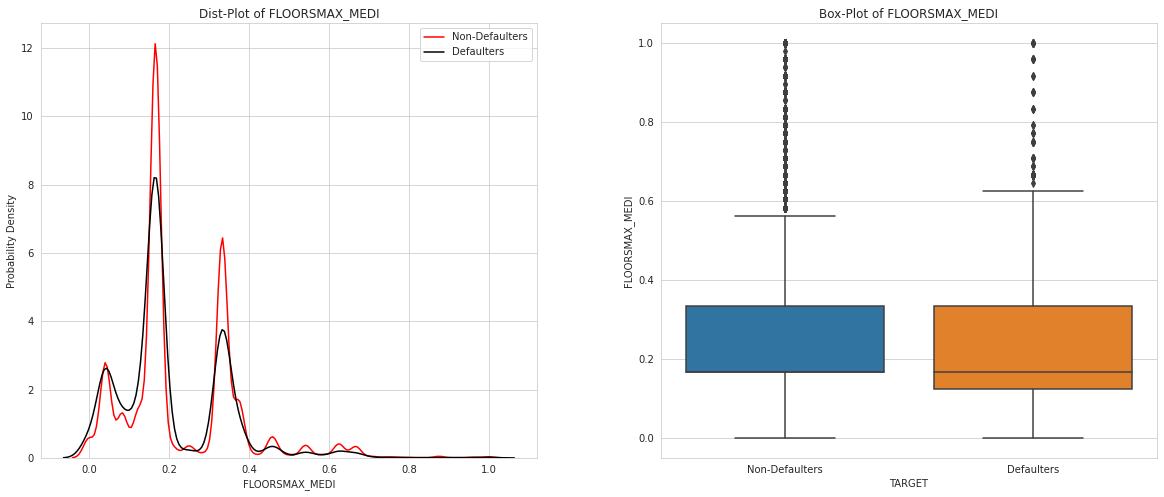

Continuous variable FLOORSMAX_MODE has 153020 NaN rows.
Percentage of NaN rows for FLOORSMAX_MODE continuous variable are 49.76 %
Percentage of 0 labels for NaN value row is 90.81 %
Percentage of 1 labels for NaN value row is 9.19 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


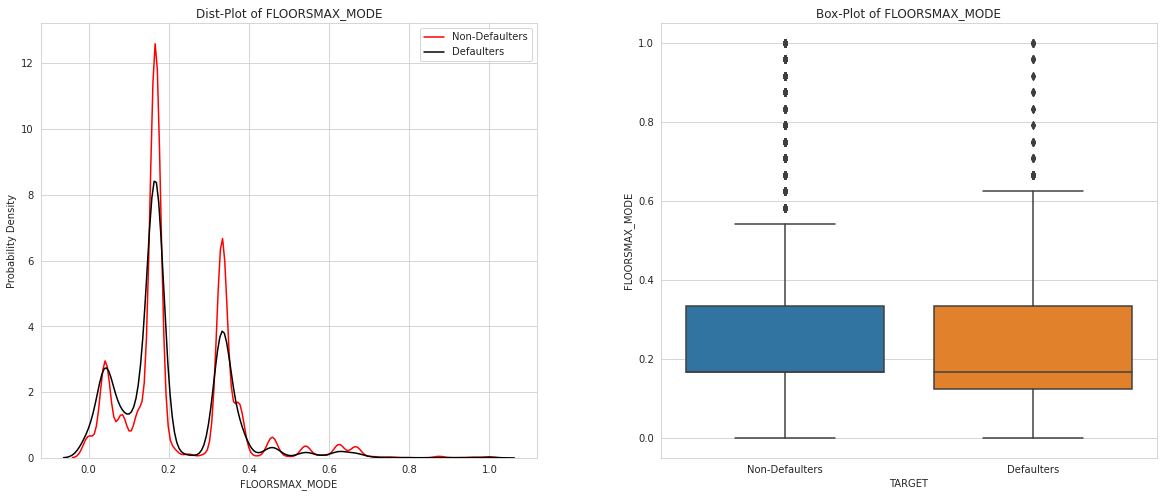

In [ ]:
# FLOORSMAX_AVG, FLOORSMAX_MEDI, FLOORSMAX_MODE 
plot_continuous_variables(application_train,application_top_continuous_var_lst[8])
plot_continuous_variables(application_train,application_top_continuous_var_lst[9])
plot_continuous_variables(application_train,application_top_continuous_var_lst[10])

**Observations and Conclusions:** 
1. These variables tells the normalized average, median and mode values of clients building consisting of apartment size, common area, living area atc.
2. FLOORSMAX_AVG,FLOORSMAX_MEDI and FLOORSMAX_MODE  has 49% of NaN samples out of which 91% are non defaulters and 9% are defaulters.
3. These variables values range from 0 to 1.
4. For non defaulters interquartile range varies from 0.18 to 0.36 while for defaulters it varies from 0.15 to 0.36.
5. For non defaulters 25th and 50th percentile are very close as seen in the box plot. This also can be observed in density plot that non defaulters density plot shows peak at around 0.2 value.

### Top Continuous Variables Pair Plot

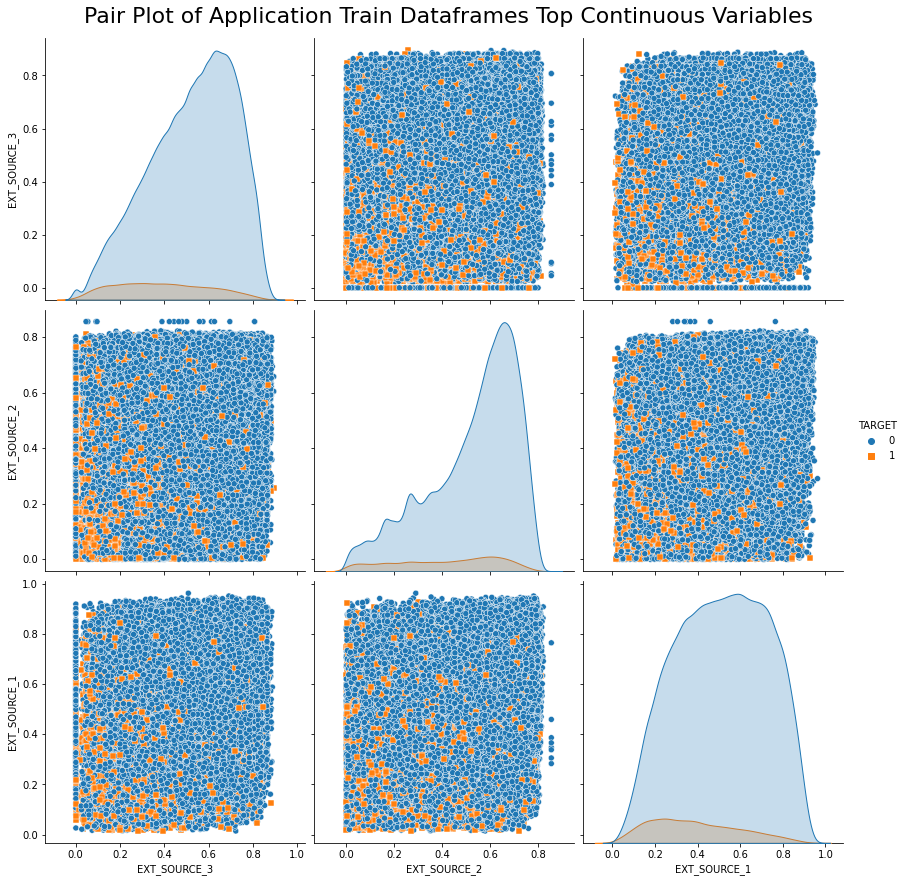

In [ ]:
df=application_train[["TARGET","EXT_SOURCE_3","EXT_SOURCE_2","EXT_SOURCE_1"]]
pairPlotFn(df,"Application Train")

**Observations and Conclusions:** 
1. In this pair plot Application Train dataframes top 3 continuous variables correlated with Targer variable are plotted.
2. 0 represents the non defaulters while 1 represents the defaulters.
3. None of the subplots of this pair plot shows a clear linear seperation between the Target variables defaulters and non defaulters categoris.
4. Pair plot shows that, defaulters have smaller values of all the 3 variables compared to the non defaulters. However there are small percentage of defaulter values which do not follows this.

# Bureau Dataframe Statistics
This dataframe consists of client's previous credits provided by other financial institutions that were reported to Credit Bureau.
For every loan in sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [16]:
bureau=pd.read_csv("bureau.csv")
bureau

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                           NaN                   0        91323.00   
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                        0.0                   NaN                     0.0   
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

In [17]:
# lets understand the common id's between application_train.csv and bureau
com_len_train=len(list(set(application_train["SK_ID_CURR"]) & set(bureau["SK_ID_CURR"])))
print("Common id's between application_train and bureau are ",com_len_train)
print("Corresponding percentage is ",round(com_len_train/len(set(application_train["SK_ID_CURR"]))*100,2))

Common id's between application_train and bureau are  263491
Corresponding percentage is  85.69


Number of variables having NaN samples are  6


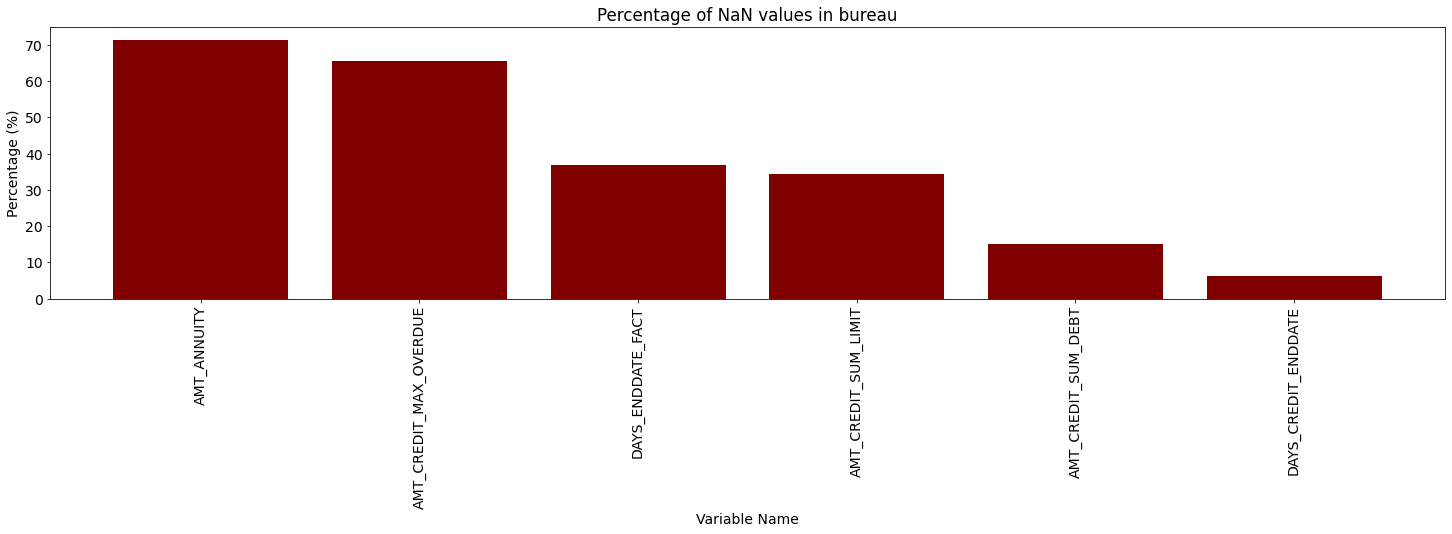

In [ ]:
#NaN variable percentatge in dataframe
plot_nan_pct(bureau,"bureau")

**Observations and Conclusions:**
1. Around 85.69% applications information of application_train is captured in bureau file
2. For a single application ID (SK_ID_CURR) there are multiple bureau ids (SK_ID_BUREAU).
3. Total number of columns in bureau dataframe are 17.
4. Bureau ID's are unique.
1. Total number of variables consisting of NaN values are 6 out of total 15 variables.
2. Highest NaN percentage is observed for AMT_ANNUITY variable while the lowest is observed for DAYS_CREDIT_ENDDATE.
3. While featurizing the data these NaN values needs to be imputed. Observations from the EDA study and literature study should help in NaN value imputation.

In [ ]:
# K mean clustering on the dataframe


### Bureau dataframes variable correlation
Lets assign the "TARGET"variable to each bureau sample. We will use application_train and bureaus common ID to assign the Target label. We will remove the dataframe samples for which target label is not assigned.

After merging we will undesrstand the correlation betwein target variable and categorical variables and between target variable and continuous variables.

In [ ]:
print("Merging TARGET with bureau dataframe")
bureau_merged = application_train.iloc[:,:2].merge(bureau, on = 'SK_ID_CURR', how = 'left')
print("Percentage of {} labeled rows is {} %".format(bureau_merged["TARGET"].value_counts().index.tolist()[0],round(bureau_merged["TARGET"].value_counts()[0]/bureau_merged.shape[0]*100,2)))
print("Percentage of {} labeled rows is {} %".format(bureau_merged["TARGET"].value_counts().index.tolist()[1],round(bureau_merged["TARGET"].value_counts()[1]/bureau_merged.shape[0]*100,2)))
print("Applicants labelled 1 are defaulters.")
print("-"*100)
bureau_merged.head()

Merging TARGET with bureau dataframe
Percentage of 0 labeled rows is 92.12 %
Percentage of 1 labeled rows is 7.88 %
Applicants labelled 1 are defaulters.
----------------------------------------------------------------------------------------------------


SK_ID_CURR  TARGET  ...  DAYS_CREDIT_UPDATE AMT_ANNUITY
0      100002       1  ...             -1038.0         0.0
1      100002       1  ...               -47.0         NaN
2      100002       1  ...             -1185.0         0.0
3      100002       1  ...              -906.0         0.0
4      100002       1  ...               -34.0         0.0

[5 rows x 18 columns]

interval columns not set, guessing: ['TARGET', 'CNT_CREDIT_PROLONG']


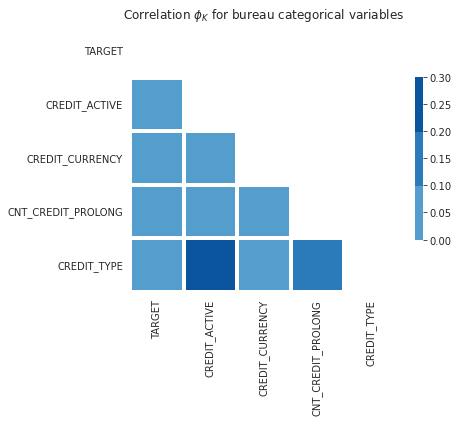

----------------------------------------------------------------------------------------------------
Correlation between categorical variable and Target variable sorted in descending order are :



TARGET                1.000000
CREDIT_ACTIVE         0.064481
CREDIT_TYPE           0.049954
CREDIT_CURRENCY       0.004993
CNT_CREDIT_PROLONG    0.003862
Name: TARGET, dtype: float64

In [ ]:
# Generating bureau merged categorical dataframe
bureau_categorical_col=["TARGET","CREDIT_ACTIVE","CREDIT_CURRENCY","CNT_CREDIT_PROLONG","CREDIT_TYPE"]
bureau_merged_cat=bureau_merged[bureau_categorical_col]

# Phi-k correaltion matrix between categorical variables and target label
phik_overview = bureau_merged_cat.phik_matrix()
phik_overview.round(2)

# Plotting Phi-k correlation matrix
mask_array = np.ones(phik_overview.shape)
mask_array = np.triu(mask_array)
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.color_palette("Blues")

sns.heatmap(phik_overview, 
            mask=mask_array,
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation $\phi_K$ for bureau categorical variables")
plt.show()

print("-"*100)
bureau_top_categorical_var_lst=phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between categorical variable and Target variable sorted in descending order are :\n")
phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

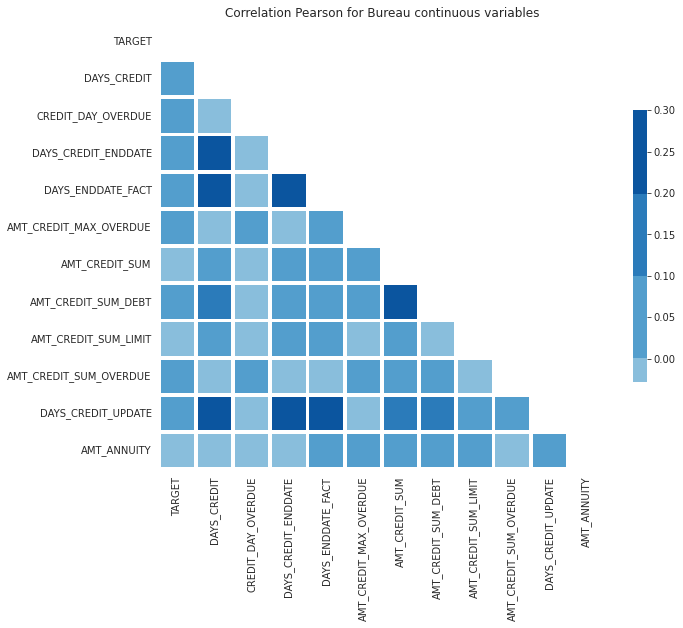

----------------------------------------------------------------------------------------------------
Correlation between continuous variable and Target variable sorted in descending order are :



TARGET                    1.000000
DAYS_CREDIT               0.061556
DAYS_CREDIT_UPDATE        0.041076
DAYS_ENDDATE_FACT         0.039057
DAYS_CREDIT_ENDDATE       0.026497
AMT_CREDIT_SUM            0.010606
AMT_CREDIT_SUM_OVERDUE    0.006253
AMT_CREDIT_SUM_LIMIT      0.005990
CREDIT_DAY_OVERDUE        0.002652
AMT_CREDIT_SUM_DEBT       0.002539
AMT_CREDIT_MAX_OVERDUE    0.001587
Name: TARGET, dtype: float64

In [ ]:
# Lets similarly observe the correlation between continuous variables and Target variable using Pearson correlatino coefficient
bureau_categorical_col.remove('TARGET')
bureau_continuous=bureau_merged.drop(bureau_categorical_col,axis=1)
bureau_continuous=bureau_continuous.drop(["SK_ID_CURR","SK_ID_BUREAU"],axis=1)

# Computing the Pearson correlation coefficients
corr=bureau_continuous.corr()

# Plotting the correlation matrix
mask_array = np.ones(corr.shape)
mask_array = np.triu(mask_array)

f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("Blues")

sns.heatmap(corr, 
            mask=mask_array, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation Pearson for Bureau continuous variables")
plt.show()

print("-"*100)
bureau_top_continuous_var_lst=corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between continuous variable and Target variable sorted in descending order are :\n")
corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

**Observations and Conclusions:**
1. Bureau dataframe is left merged on the application datafeame for a common SK_ID_CURR to get the Target variable from application dataframe for each row of Bureau. Bureau dataframe rows gets removed for which Target is not present. 
2. In the merged dataframe, 92.12% are non defaulters while 7.88% are defaulters.
3. A week correaltion between the variables and Target label is observed from the  categorical and continuous variables correaltions matrix. This describes that there is no linear correaltion amongst the variables and Target label. 
4. Amongst all continuous variables, DAYS_CREDIT shows a high correlation wrt Target label.
5. We will plot first 4 categorical and continuous variables plot wrt Target variable.

## Bureau Categorical Variable Plots

### Categorical Variable 1: CREDIT_ACTIVE 

Number of unique category values of CREDIT_ACTIVE categorical variable are 4
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for CREDIT_ACTIVE categorical variable are 2.92 %
Percentage of 0 labels for NaN value row is 89.88 %
Percentage of 1 labels for NaN value row is 10.12 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


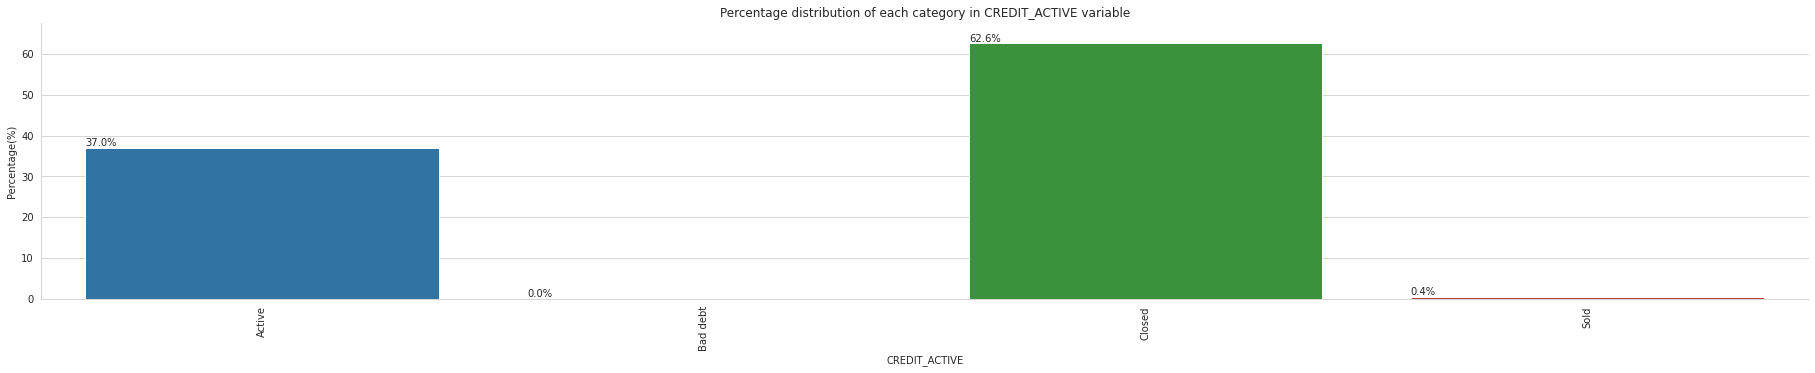

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


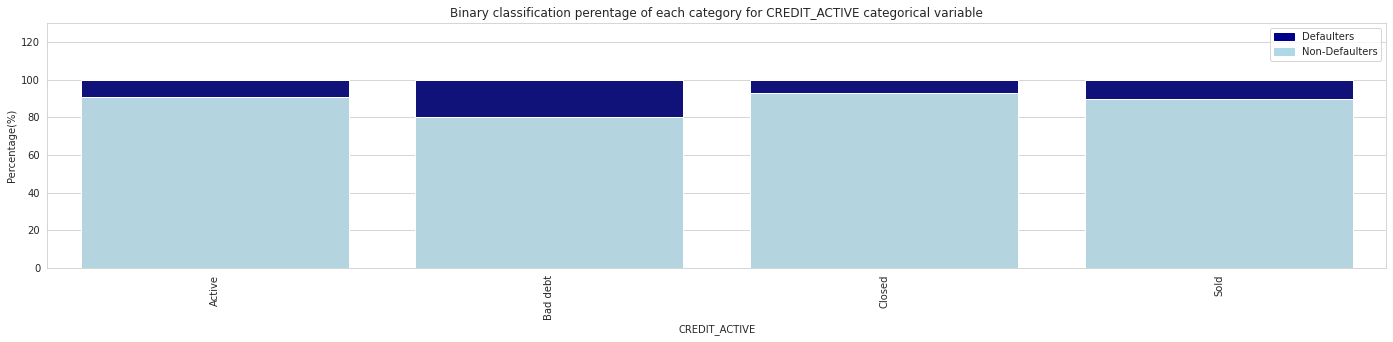

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


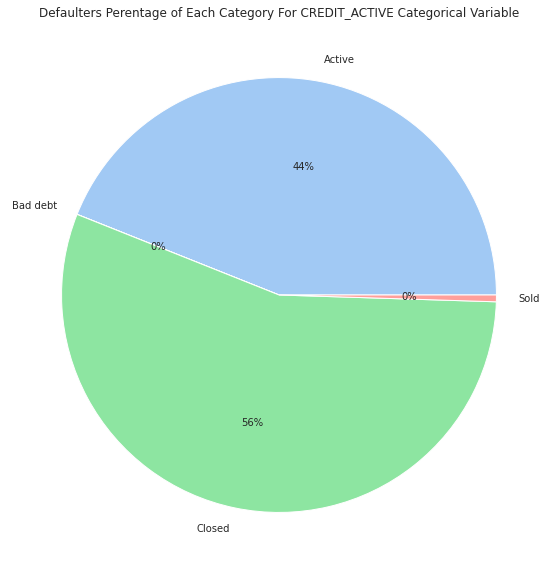

In [ ]:
# CREDIT_ACTIVE 
category_var_plot(bureau_merged,bureau_top_categorical_var_lst[1])

**Observations and conclusions :**
1. CREDIT_ACTIVE represents the status of the credit reported by credit bureau.
2. For around 3% of samples, CREDIT_ACTIVE  is not defined. Amongst these NaN values, 90% are non defaulters.
3. For the defined categories, closed constitute around 62.6% of samples and is the largest credit status type of the application followed by active credit status. Bad debt and sold categories count is almost 0.
4. Active credit type has most percentage of defaulters than closed if we observe the categoriwise defaulters percentage represented by stacked bar plot.
5. Pie chart shows the defaulters percentage in an entire data follows the similar distribution as observed in the count percentage bar plot. 
6. Close credit status type has the largest count in the data and also has the overall largest defaulter percentage. Count of Active credit type in the data is 37% however their defaulters are 44% amongst the entire defaulters data.

### Categorical Variable 2: CREDIT_TYPE  

Number of unique category values of CREDIT_TYPE categorical variable are 15
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for CREDIT_TYPE categorical variable are 2.92 %
Percentage of 0 labels for NaN value row is 89.88 %
Percentage of 1 labels for NaN value row is 10.12 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


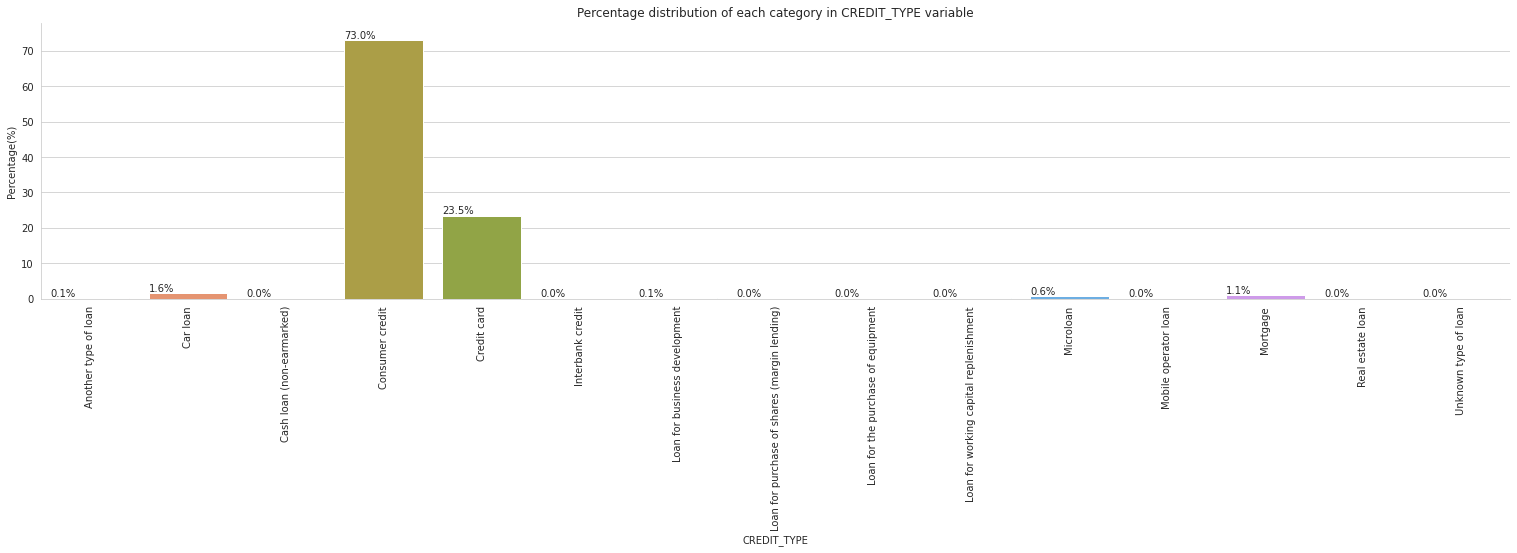

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


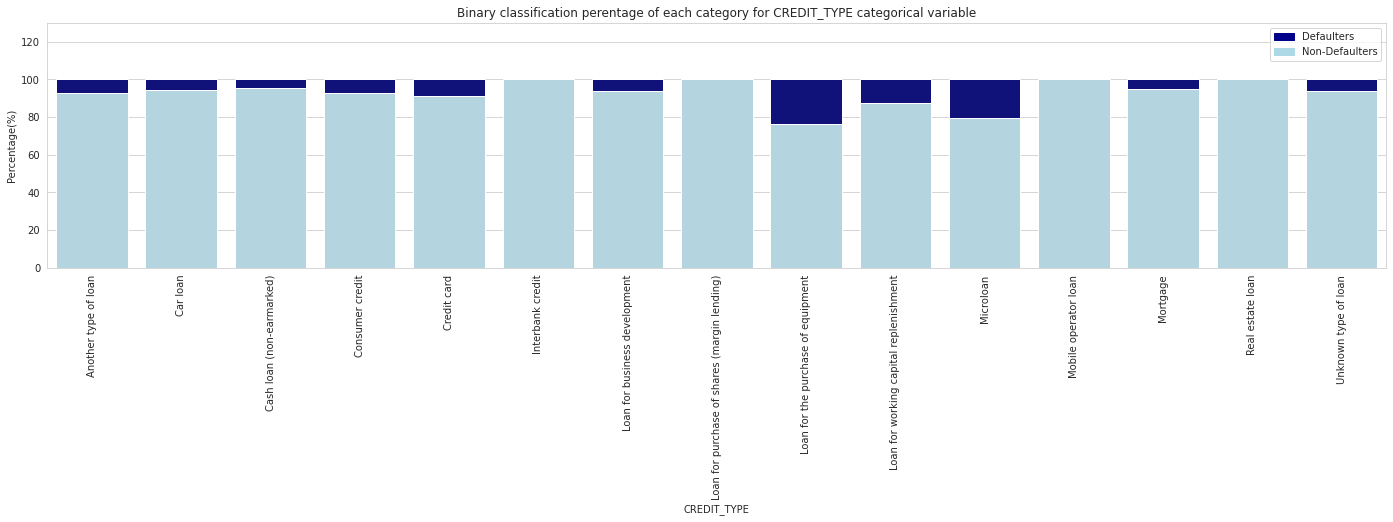

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


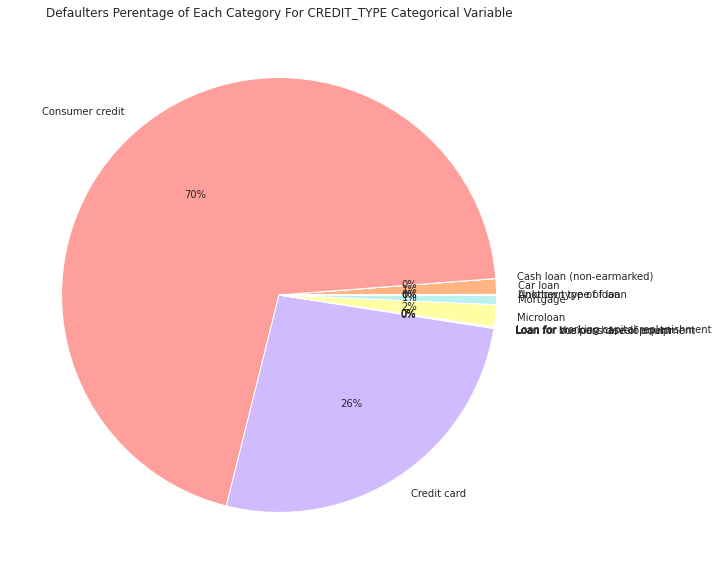

In [ ]:
# CREDIT_TYPE  
category_var_plot(bureau_merged,bureau_top_categorical_var_lst[2])

**Observations and conclusions :**
1. CREDIT_TYPE  represents the type of the credit reported by credit bureau.
2. For around 3% of samples, CREDIT_TYPE   is not defined. Amongst these NaN values, 90% are non defaulters.
3. For the defined categories, consumer credit constitute around 73% of samples and is the largest credit type of the application followed by credit card, card loan, car loan, mortgage credit types.Other categories count is almost 0.
4. credit card type has most percentage of defaulters than consumer credit type if we observe the categoriwise defaulters percentage represented by stacked bar plot.
5. Pie chart shows the defaulters percentage in an entire data follows the similar distribution as observed in the count percentage bar plot. 
6. Consumer credit type has the largest count in the data and also has the overall largest defaulter percentage.
7. Categories with almost 0 count can be represented by a single type while doing featurization.

### Categorical Variable 3 and 4: CREDIT_CURRENCY, CNT_CREDIT_PROLONG

Number of unique category values of CREDIT_CURRENCY categorical variable are 4
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for CREDIT_CURRENCY categorical variable are 2.92 %
Percentage of 0 labels for NaN value row is 89.88 %
Percentage of 1 labels for NaN value row is 10.12 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


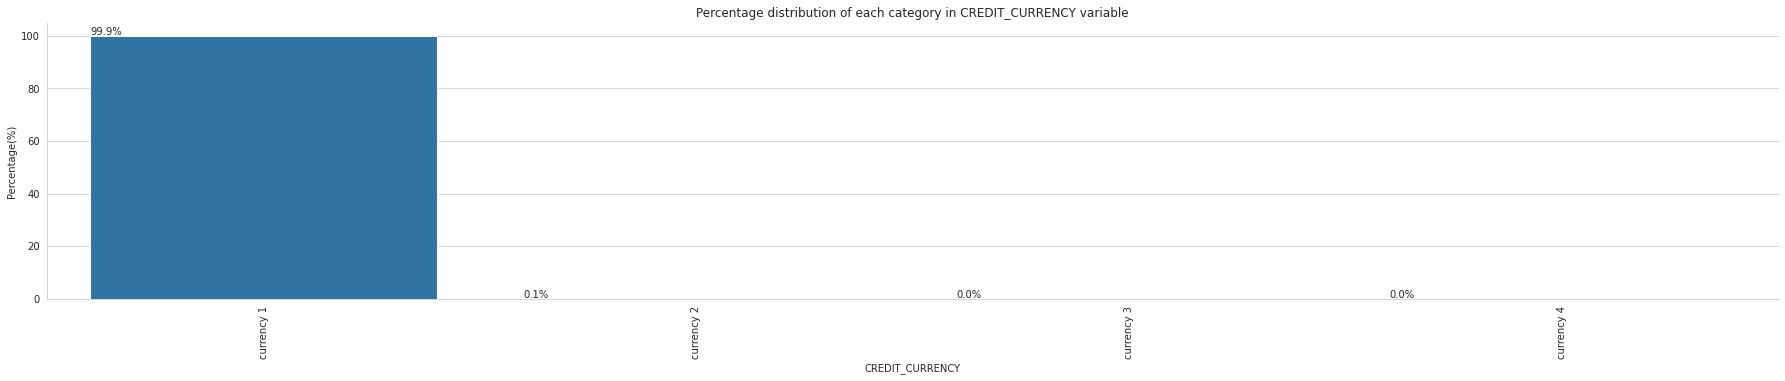

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


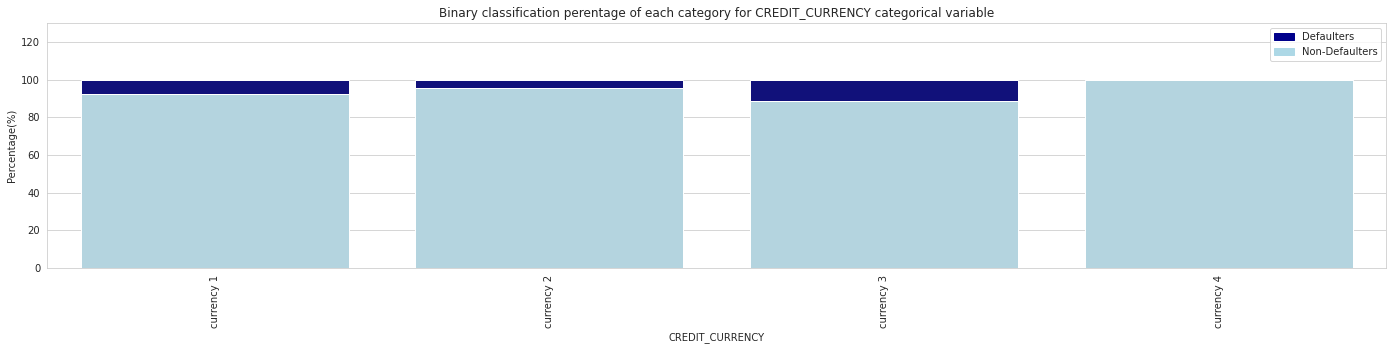

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


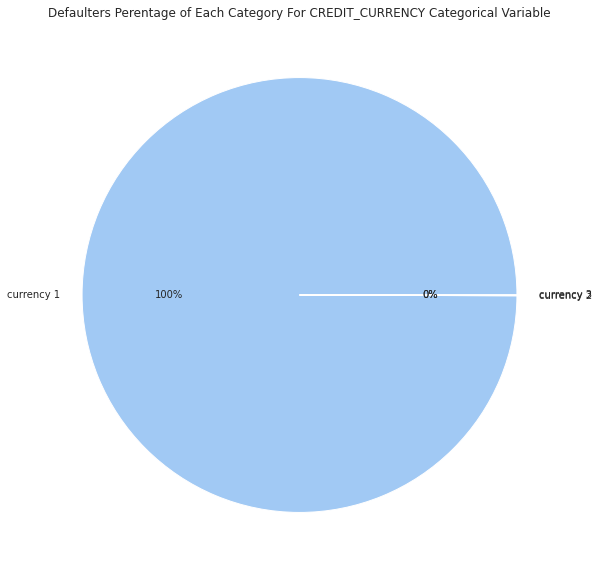

Number of unique category values of CNT_CREDIT_PROLONG categorical variable are 10
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for CNT_CREDIT_PROLONG categorical variable are 2.92 %
Percentage of 0 labels for NaN value row is 89.88 %
Percentage of 1 labels for NaN value row is 10.12 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


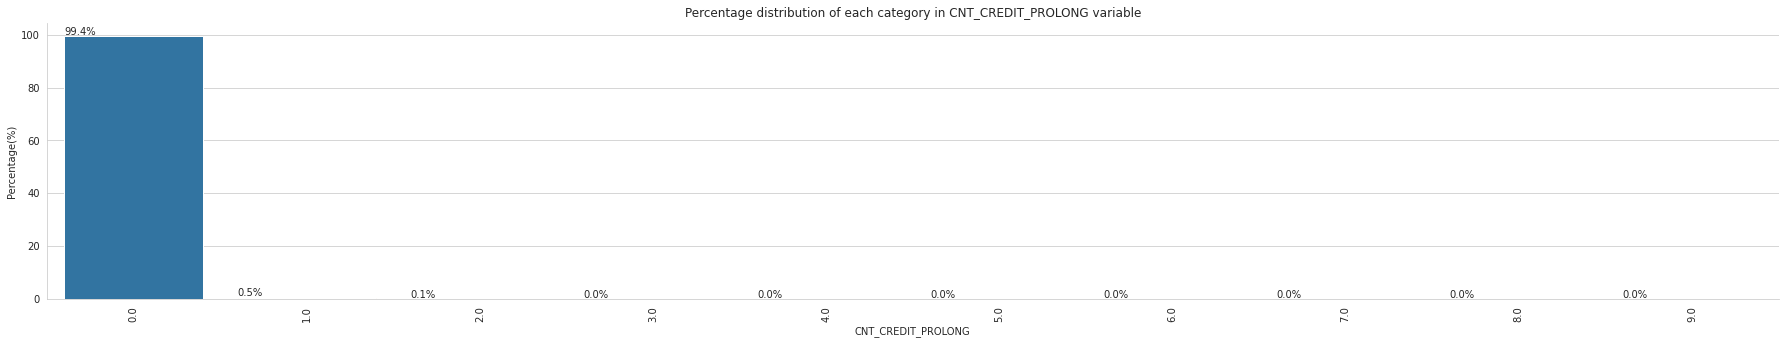

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


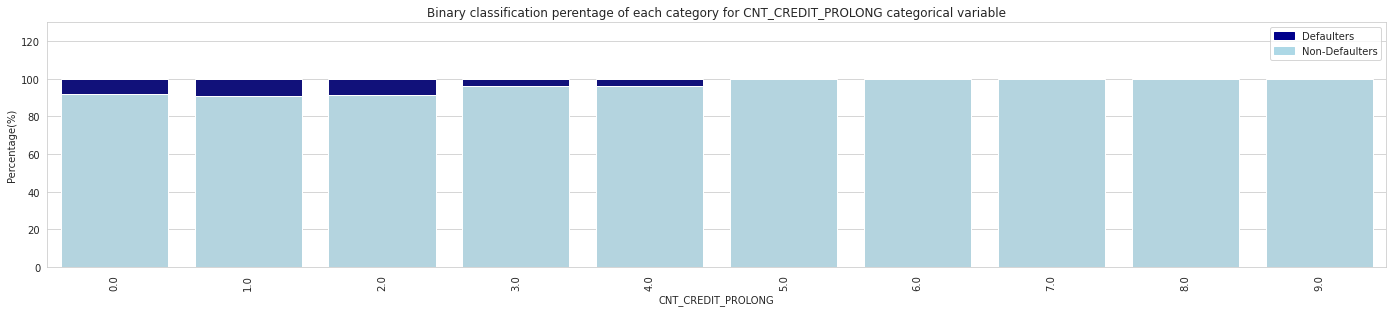

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


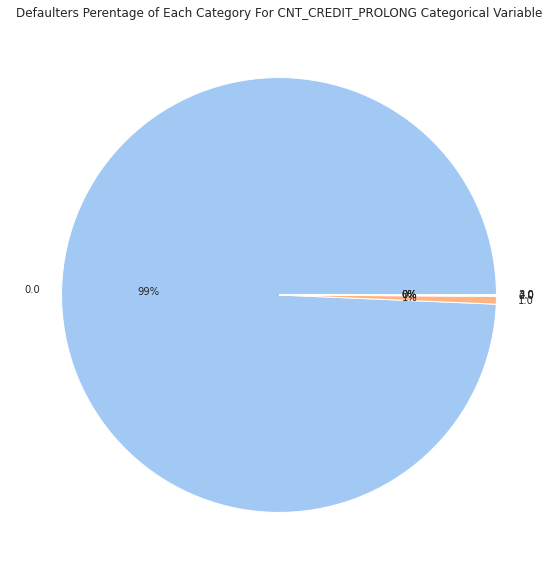

In [ ]:
# CREDIT_CURRENCY   
category_var_plot(bureau_merged,bureau_top_categorical_var_lst[3])
# CNT_CREDIT_PROLONG    
category_var_plot(bureau_merged,bureau_top_categorical_var_lst[4])

**Observations and conclusions :**
1. CREDIT_CURRENCY   represents the type of the currency reported by credit bureau.
2. For around 3% of samples, CREDIT_TYPE   is not defined. Amongst these NaN values, 90% are non defaulters.
3. For the defined categories, currency 1 constitute around 99.9% of samples while other categories count is almost 0.
4. Similar obsevations are for CNT_CREDIT_PROLONG where only 1 type is dominant.
5. Categories with almost 0 count can be represented by a single type while doing featurization.

## Bureau Continuous Variable Plots


### Continuous Variable 1: DAYS_CREDIT to  YEARS_CREDIT
This variable represents the how many days before application did client applied for credit bureau credit.

DAYS_CREDIT = credit bureau application date - application date

For interpretation of results we will convert the data in positive year values.

Continuous variable YEARS_CREDIT has 44020 NaN rows.
Percentage of NaN rows for YEARS_CREDIT continuous variable are 2.92 %
Percentage of 0 labels for NaN value row is 89.88 %
Percentage of 1 labels for NaN value row is 10.12 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


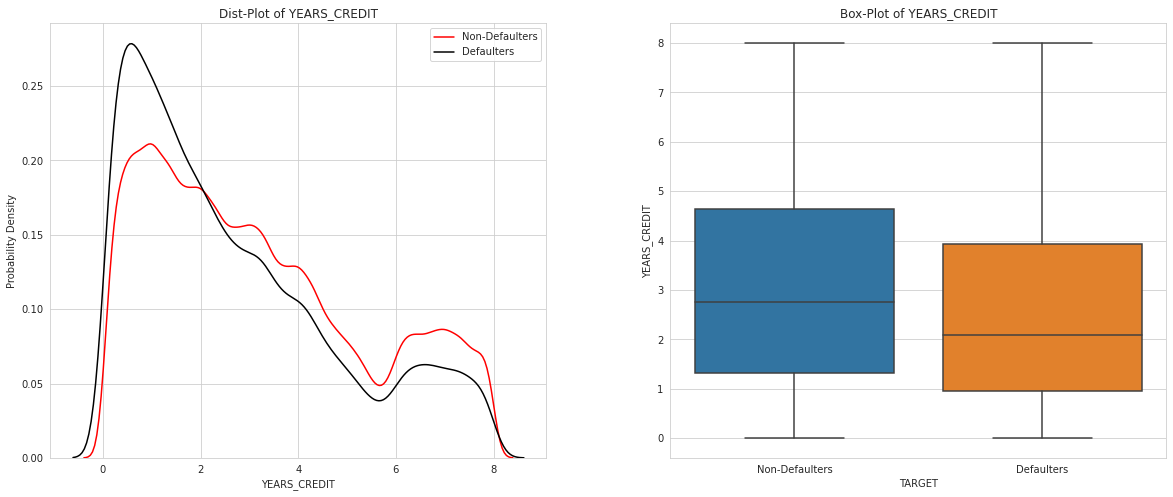

In [ ]:
# DAYS_CREDIT to  YEARS_CREDIT
bureau_merged["YEARS_CREDIT"]=bureau_merged[bureau_top_continuous_var_lst[1]]*-1/365
plot_continuous_variables(bureau_merged,"YEARS_CREDIT")
bureau_merged=bureau_merged.drop(["YEARS_CREDIT"],axis=1)

**Observations and Conclusions :**  
1. For around 3% of samples, YEARS_CREDIT values is not defined. Amongst these NaN values, 90% are non defaulters.
2. Probability density plot of non defaulters and defaulters are right skewed. Defaulter density plot shows peak at lesser year credit value.
3. Intequertile range of non defaulters box plot is from 1.3 to 4.8 years while that of defaulters is from 1 to 4. This is an evident that clients who have applied recently for credit in credit bureau tend to be more defaulter than non defaulter.
4. Minimum and maximum values of both the categories of client are same. 

### Continuous Variable 2: DAYS_CREDIT_UPDATE to Months_CREDIT_UPDATE 
This variable represents the how many days before application did last information about the credit bureau credit received.

For interpretation of results we will convert the data in positive month values.

Continuous variable Months_CREDIT_UPDATE has 44020 NaN rows.
Percentage of NaN rows for Months_CREDIT_UPDATE continuous variable are 2.92 %
Percentage of 0 labels for NaN value row is 89.88 %
Percentage of 1 labels for NaN value row is 10.12 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


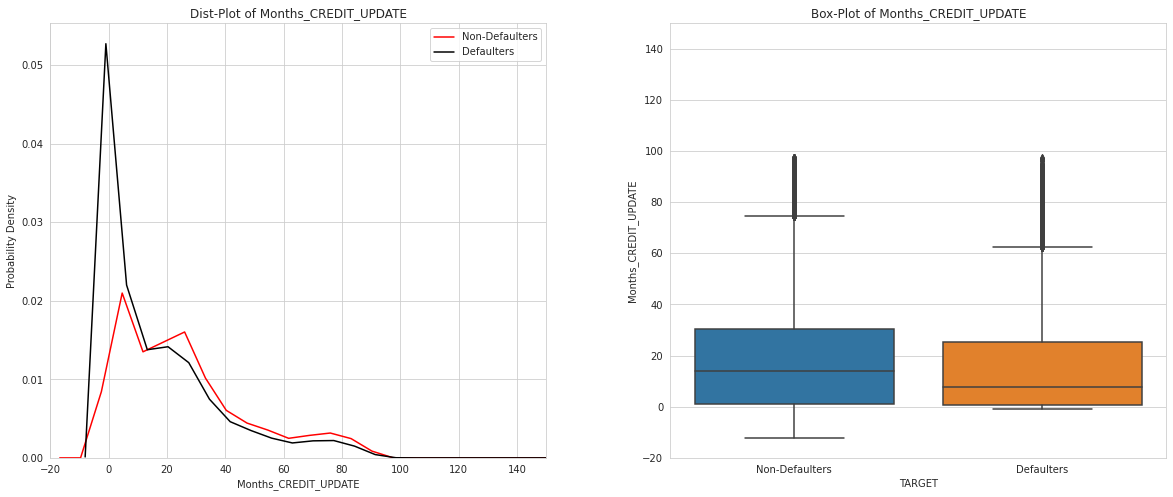

In [ ]:
# DAYS_CREDIT_UPDATE to Months_CREDIT_UPDATE      
bureau_merged["Months_CREDIT_UPDATE"]=bureau_merged[bureau_top_continuous_var_lst[2]]*-1/30
plot_continuous_variables(bureau_merged,"Months_CREDIT_UPDATE","Yes",(-20,150),(-20,150))
bureau_merged=bureau_merged.drop(["Months_CREDIT_UPDATE"],axis=1)

**Observations and Conclusions :**  
1. For around 3% of samples, Months_CREDIT_UPDATE  values is not defined. Amongst these NaN values, 90% are non defaulters.
2. Probability density plot of non defaulters and defaulters are right skewed. Defaulter density plot shows peak at lesser month value.
3. Intequertile range of non defaulters box plot is from 2 to 30 months while that of defaulters is from 1 to 26.
4. Median month value of dafaulters is lesser than non defaulters.

### Continuous Variable 3: DAYS_ENDDATE_FACT  to Months_ENDDATE_FACT   
This variable represents the how many days before application did credit ended in credit bureau.

For interpretation of results we will convert the data in positive month values.

Continuous variable Months_ENDDATE_FACT has 588693 NaN rows.
Percentage of NaN rows for Months_ENDDATE_FACT continuous variable are 39.0 %
Percentage of 0 labels for NaN value row is 90.64 %
Percentage of 1 labels for NaN value row is 9.36 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


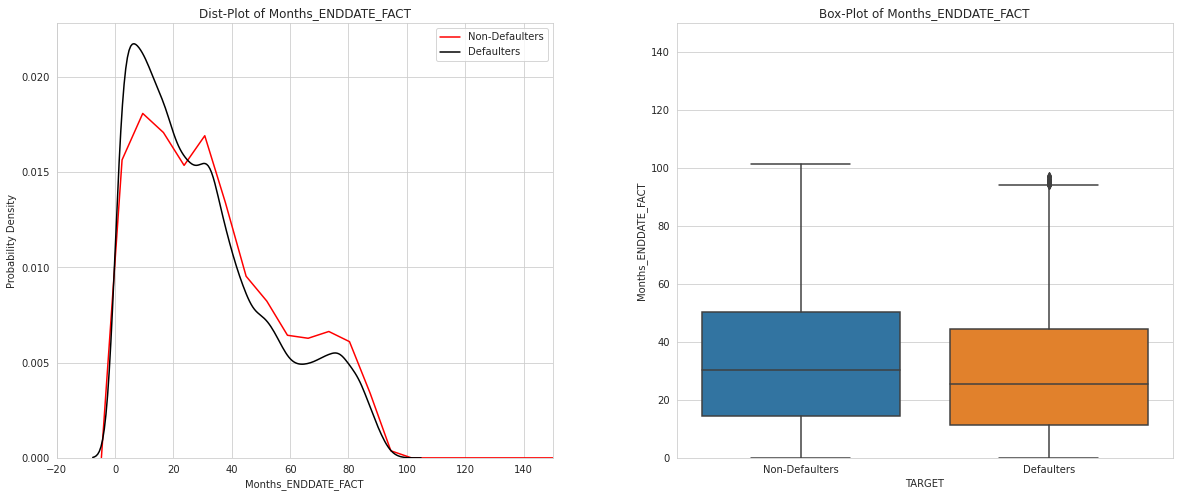

In [ ]:
# DAYS_ENDDATE_FACT  to Months_ENDDATE_FACT       
bureau_merged["Months_ENDDATE_FACT"]=bureau_merged[bureau_top_continuous_var_lst[3]]*-1/30
plot_continuous_variables(bureau_merged,"Months_ENDDATE_FACT","Yes",(-20,150),(0,150))
bureau_merged=bureau_merged.drop(["Months_ENDDATE_FACT"],axis=1)

**Observations and Conclusions :**  
1. For around 39% of samples, Months_ENDDATE_FACT   values is not defined. Amongst these NaN values, 90.6% are non defaulters.
2. Probability density plot of non defaulters and defaulters are right skewed. Defaulter density plot shows peak at lesser month value.
3. Intequertile range of non defaulters box plot is from 16 to 52 months while that of defaulters is from 12 to 44.
4. Median month value of dafaulters is lesser than non defaulters. 

### Continuous Variable 4: DAYS_CREDIT_ENDDATE to MONTHS_CREDIT_ENDDATE   
This variable represents the how many days are remaining for credit bureau credit at the time of application.

For interpretation of results we will convert the data in positive month values.

Continuous variable MONTHS_CREDIT_ENDDATE has 133118 NaN rows.
Percentage of NaN rows for MONTHS_CREDIT_ENDDATE continuous variable are 8.82 %
Percentage of 0 labels for NaN value row is 89.66 %
Percentage of 1 labels for NaN value row is 10.34 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


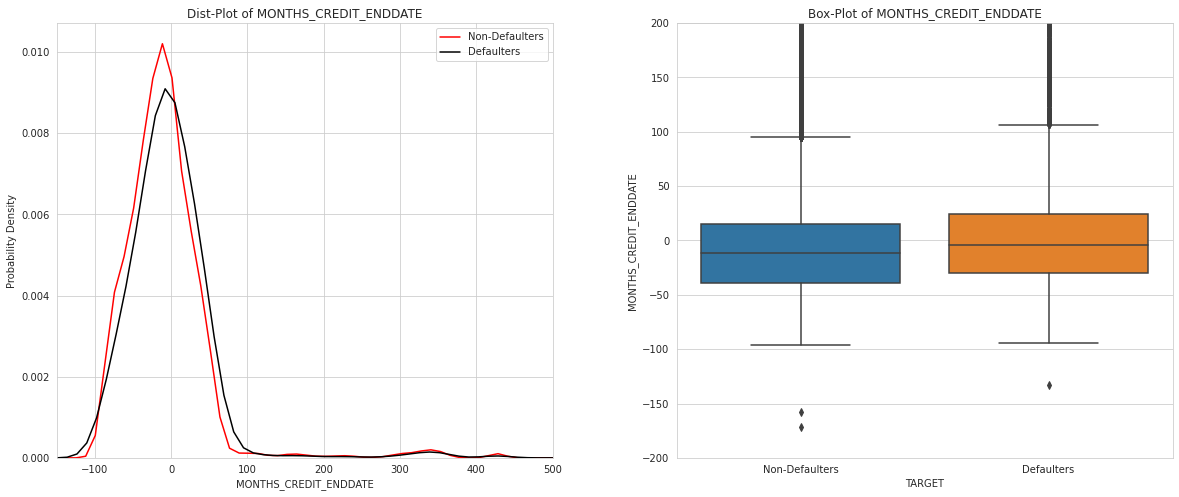

In [ ]:
# DAYS_CREDIT_ENDDATE to MONTHS_CREDIT_ENDDATE      
bureau_merged["MONTHS_CREDIT_ENDDATE"]=bureau_merged[bureau_top_continuous_var_lst[4]]/30
plot_continuous_variables(bureau_merged,"MONTHS_CREDIT_ENDDATE","Yes",(-150,500),(-200,200))
bureau_merged=bureau_merged.drop(["MONTHS_CREDIT_ENDDATE"],axis=1)

**Observations and Conclusions :**  
1. For around 8.82% of samples, MONTHS_CREDIT_ENDDATE    values is not defined. Amongst these NaN values, 89.66% are non defaulters.
2. Probability density plot of non defaulters and defaulters shows a bell shaped curve with neagative month value median.
3. Intequertile range of non defaulters box plot is from -40 to 15 months while that of defaulters is from -30 to 30. This is an evident that, non defaulters have already completed their credits in the credit bureau.
4. Median month value of dafaulters is higher than non defaulters. 

### Top Continuous Variables Pair Plot

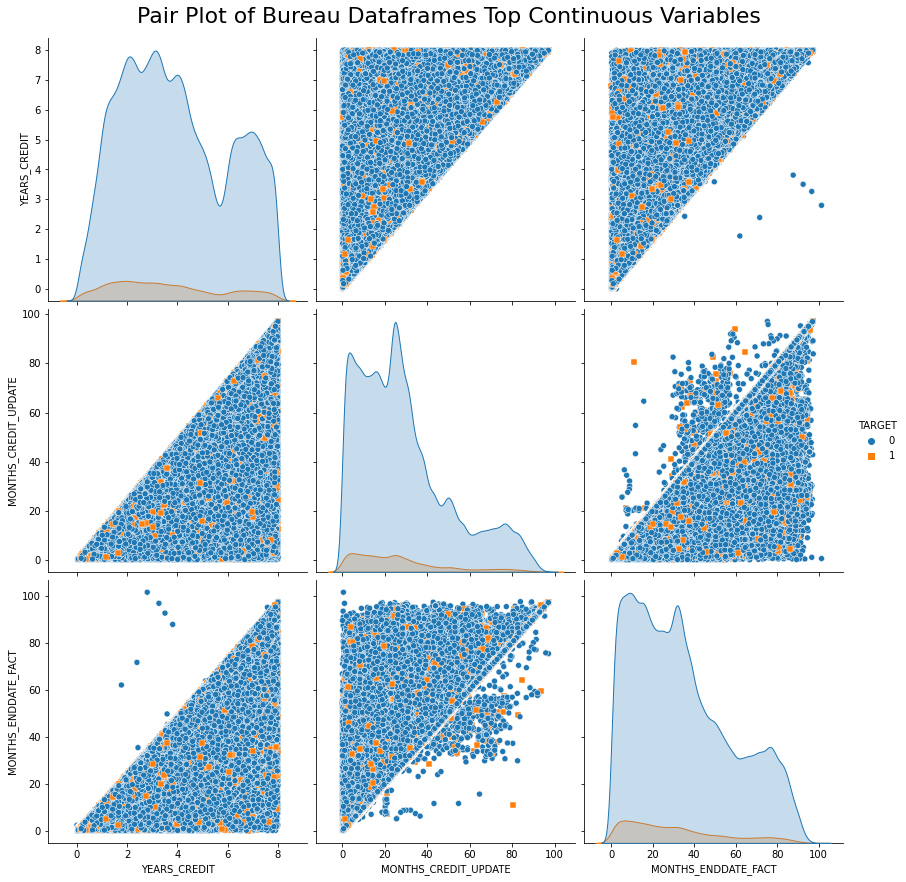

In [ ]:
df=bureau_merged[["TARGET","DAYS_CREDIT","DAYS_CREDIT_UPDATE","DAYS_ENDDATE_FACT"]]
df["YEARS_CREDIT"]=df["DAYS_CREDIT"]*-1/365
df["MONTHS_CREDIT_UPDATE"]=df["DAYS_CREDIT_UPDATE"]*-1/30
df["MONTHS_ENDDATE_FACT"]=df["DAYS_ENDDATE_FACT"]*-1/30
df=df.drop(["DAYS_CREDIT","DAYS_CREDIT_UPDATE","DAYS_ENDDATE_FACT"],axis=1)
df = df[df['MONTHS_CREDIT_UPDATE'] >= -20]
df = df[df['MONTHS_CREDIT_UPDATE'] <= 150]
df = df[df['MONTHS_ENDDATE_FACT'] >= 0]
df = df[df['MONTHS_ENDDATE_FACT'] <= 150]

pairPlotFn(df,"Bureau")

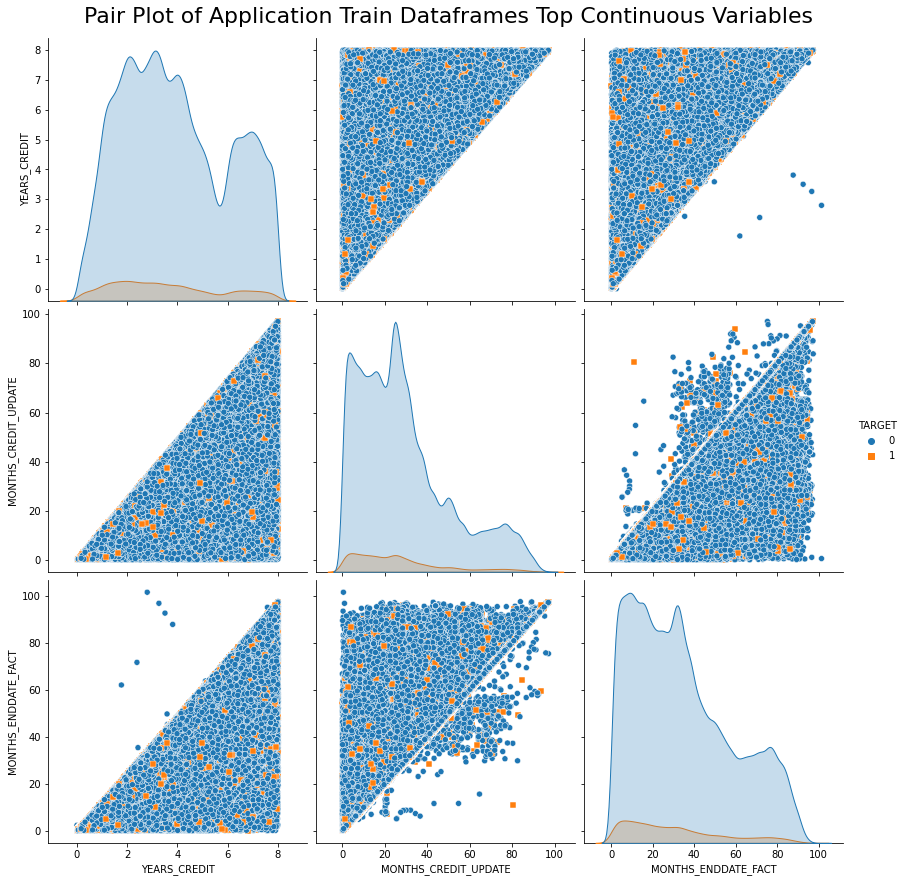

In [ ]:
df=bureau_merged[["TARGET","DAYS_CREDIT","DAYS_CREDIT_UPDATE","DAYS_ENDDATE_FACT"]]
df["YEARS_CREDIT"]=df["DAYS_CREDIT"]*-1/365
df["MONTHS_CREDIT_UPDATE"]=df["DAYS_CREDIT_UPDATE"]*-1/30
df["MONTHS_ENDDATE_FACT"]=df["DAYS_ENDDATE_FACT"]*-1/30
df=df.drop(["DAYS_CREDIT","DAYS_CREDIT_UPDATE","DAYS_ENDDATE_FACT"],axis=1)
df = df[df['MONTHS_CREDIT_UPDATE'] >= -20]
df = df[df['MONTHS_CREDIT_UPDATE'] <= 150]
df = df[df['MONTHS_ENDDATE_FACT'] >= 0]
df = df[df['MONTHS_ENDDATE_FACT'] <= 150]

pairPlotFn(df,"Bureau Merged")

**Observations and Conclusions:** 
1. In this pair plot Bureau dataframes top 3 continuous variables correlated with Targer variable are plotted.
2. 0 represents the non defaulters while 1 represents the defaulters.
3. Outliers are removed before plotting a pairplot from few of the variables for better visualization. THese outlier values are derived from box plot.
4. None of the subplots of this pair plot shows a clear linear seperation between the Target variables defaulters and non defaulters categoris.


# Bureau Balance Dataframe Stattistics

In [ ]:
bureau_balance=pd.read_csv("bureau_balance.csv")
bureau_balance

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

In [ ]:
print("Number of unique values of SK_ID_BUREAU in bureau balance are ",bureau_balance["SK_ID_BUREAU"].nunique())
com_len=len(list(set(bureau_balance["SK_ID_BUREAU"]) & set(bureau["SK_ID_BUREAU"])))
print("Common id's between bureau and bureau balance are ",com_len)
print("Corresponding percentage is ",round(com_len/len(set(bureau["SK_ID_BUREAU"]))*100,2))
print("-"*100)
print("Number of unique values of STATUS variable are \n",bureau_balance["STATUS"].value_counts().index.tolist())

Number of unique values of SK_ID_BUREAU in bureau balance are  817395
Common id's between bureau and bureau balance are  774354
Corresponding percentage is  45.11
----------------------------------------------------------------------------------------------------
Number of unique values of STATUS variable are 
 ['C', '0', 'X', '1', '5', '2', '3', '4']


In [ ]:
plot_nan_pct(bureau_balance,"Bureau Balance")

Dataframe Bureau Balance does not have any NaN variable


**Observations and Conclusions:**
1. This dataframe tells the status of credit in credit cureau. The status is mentioned relative to the application date, -1 month balance represent the latest month.
2. Bureau balance dataframe covers the information of around 45% credits in credit bureau.
3. Status has 8 unique values. C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,5 means DPD 120+ or sold or written off.

# Previous Application Dataframe Statistics

This dataframe have all previous applications for Home Credit loans of clients who have applied for loan.

In [ ]:
previous_application=pd.read_csv("previous_application.csv")
previous_application

SK_ID_PREV  SK_ID_CURR  ... DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL
0           2030495      271877  ...            -37.0                        0.0
1           2802425      108129  ...         365243.0                        1.0
2           2523466      122040  ...         365243.0                        1.0
3           2819243      176158  ...           -177.0                        1.0
4           1784265      202054  ...              NaN                        NaN
...             ...         ...  ...              ...                        ...
1670209     2300464      352015  ...           -351.0                        0.0
1670210     2357031      334635  ...          -1297.0                        0.0
1670211     2659632      249544  ...          -1181.0                        0.0
1670212     2785582      400317  ...           -817.0                        1.0
1670213     2418762      261212  ...           -423.0                        0.0

[1670214 rows x 37 columns]

In [ ]:
print("Shape of previous application dataframe is ",previous_application.shape)
print("Number of unique values of SK_ID_PREV in previous application are ",previous_application["SK_ID_PREV"].nunique())
# lets understand the common id's between application_train.csv and previous_application
com_len_train=len(list(set(application_train["SK_ID_CURR"]) & set(previous_application["SK_ID_CURR"])))
print("Common id's between application_train and previous_application are ",com_len_train)
print("Corresponding percentage is ",round(com_len_train/len(set(application_train["SK_ID_CURR"]))*100,2))

Shape of previous application dataframe is  (1670214, 37)
Number of unique values of SK_ID_PREV in previous application are  1670214
Common id's between application_train and previous_application are  291057
Corresponding percentage is  94.65


Number of variables having NaN samples are  15


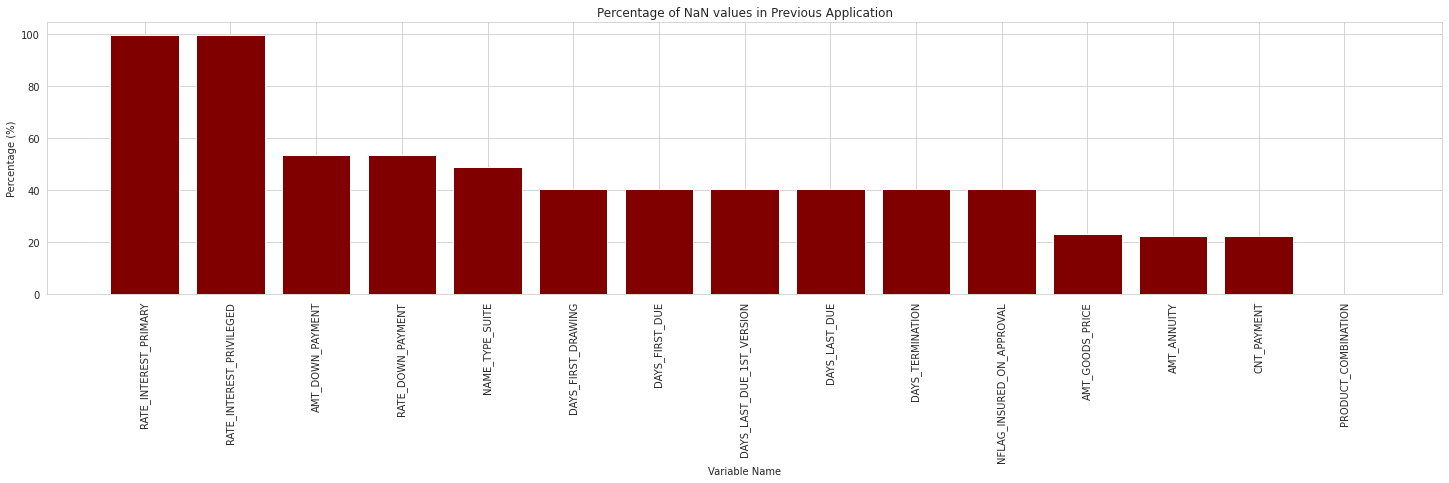

In [ ]:
#NaN variable percentatge in dataframe
plot_nan_pct(previous_application,"Previous Application")

**Observations and Conclusions:**
1. Previous application dataframe has total 37 columns. Out of these, 15 variables have NaN values. 2 variables, RATE_INTEREST_PRIMARY and RATE_INTEREST_PRIVILEDGED has almost all NaN samples. Both of these variables represent the normalized interest rate on the previous applications.
2. Out of the total apllicants present in application train dataframe, 94% of appplicants infromation about previous loan with Home Credit is captured with previous application dataframe.
3. SK_ID_PREV which represents ID of previous credit with Home Credit for applicant is unique for this dataframe.


### Previous Application Dataframe Variable Correlation
Lets assign the "TARGET"variable to each previous application sample. We will use application_train and previous application common ID to assign the Target label. We will remove the dataframe samples for which target label is not assigned.

After merging we will undesrstand the correlation between target variable and categorical variables and between target variable and continuous variables.

In [ ]:
print("Merging TARGET with Previous application dataframe")
previous_application_merged = application_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')
print("Percentage of {} labels for NaN value row is {} %".format(previous_application_merged["TARGET"].value_counts().index.tolist()[0],round(previous_application_merged["TARGET"].value_counts()[0]/previous_application_merged.shape[0]*100,2)))
print("Percentage of {} labels for NaN value row is {} %".format(previous_application_merged["TARGET"].value_counts().index.tolist()[1],round(previous_application_merged["TARGET"].value_counts()[1]/previous_application_merged.shape[0]*100,2)))
print("Applicants labelled 1 are defaulters.")
print("-"*100)
previous_application_merged.head()

Merging TARGET with Previous application dataframe
Percentage of 0 labels for NaN value row is 91.38 %
Percentage of 1 labels for NaN value row is 8.62 %
Applicants labelled 1 are defaulters.
----------------------------------------------------------------------------------------------------


SK_ID_CURR  TARGET  ...  DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL
0      100002       1  ...             -17.0                       0.0
1      100003       0  ...            -527.0                       1.0
2      100003       0  ...            -639.0                       0.0
3      100003       0  ...           -1976.0                       1.0
4      100004       0  ...            -714.0                       0.0

[5 rows x 38 columns]

interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'CNT_PAYMENT', 'NFLAG_INSURED_ON_APPROVAL']


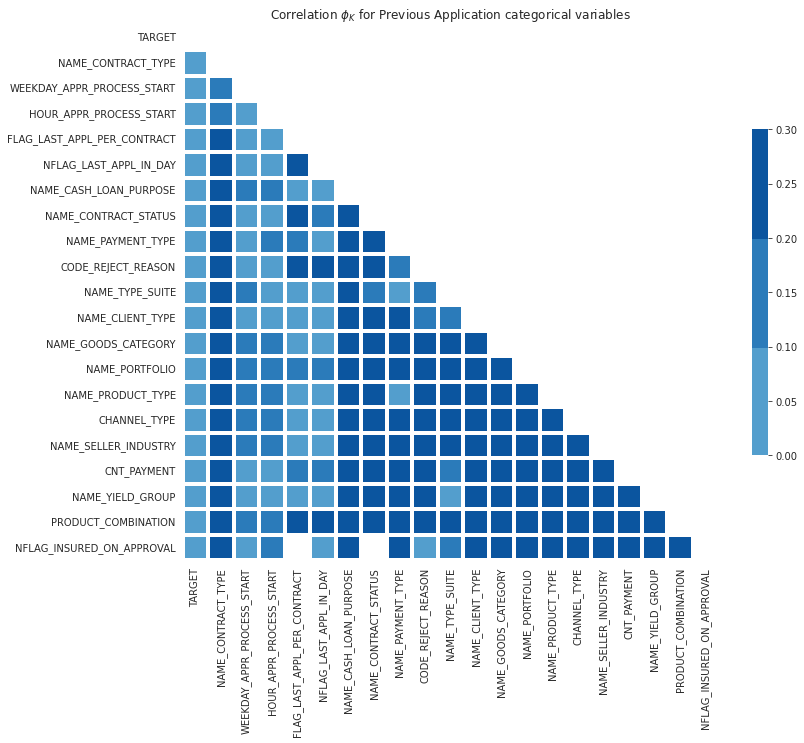

----------------------------------------------------------------------------------------------------
Correlation between categorical variable and Target variable sorted in descending order are :



TARGET                     1.000000
NAME_CONTRACT_STATUS       0.088266
PRODUCT_COMBINATION        0.063839
CODE_REJECT_REASON         0.062771
CNT_PAYMENT                0.056639
NAME_CONTRACT_TYPE         0.050859
CHANNEL_TYPE               0.050302
NAME_GOODS_CATEGORY        0.042951
NAME_CASH_LOAN_PURPOSE     0.040305
NAME_PAYMENT_TYPE          0.039752
HOUR_APPR_PROCESS_START    0.038121
Name: TARGET, dtype: float64

In [ ]:
# Generating Previous Application categorical dataframe
previous_application_categorical_col=["TARGET","NAME_CONTRACT_TYPE","WEEKDAY_APPR_PROCESS_START","HOUR_APPR_PROCESS_START","FLAG_LAST_APPL_PER_CONTRACT","NFLAG_LAST_APPL_IN_DAY",\
                                      "NAME_CASH_LOAN_PURPOSE","NAME_CONTRACT_STATUS","NAME_PAYMENT_TYPE","CODE_REJECT_REASON","NAME_TYPE_SUITE",\
                                      "NAME_CLIENT_TYPE","NAME_GOODS_CATEGORY","NAME_PORTFOLIO","NAME_PRODUCT_TYPE","CHANNEL_TYPE","NAME_SELLER_INDUSTRY",\
                                      "CNT_PAYMENT","NAME_YIELD_GROUP","PRODUCT_COMBINATION","NFLAG_INSURED_ON_APPROVAL"]
previous_application_merged_cat=previous_application_merged[previous_application_categorical_col]

# Phi-k correaltion matrix between categorical variables and target label
phik_overview = previous_application_merged_cat.phik_matrix()
phik_overview.round(2)

# Plotting Phi-k correlation matrix
mask_array = np.ones(phik_overview.shape)
mask_array = np.triu(mask_array)
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.color_palette("Blues")

sns.heatmap(phik_overview, 
            mask=mask_array,
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation $\phi_K$ for Previous Application categorical variables")
plt.show()

print("-"*100)
previous_application_top_categorical_var_lst=phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between categorical variable and Target variable sorted in descending order are :\n")
phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

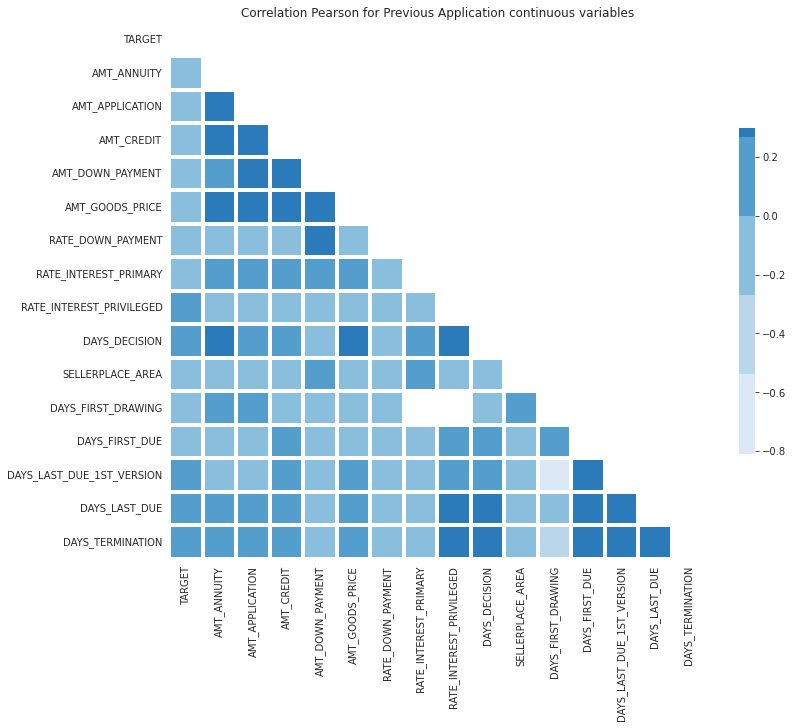

----------------------------------------------------------------------------------------------------
Correlation between continuous variable and Target variable sorted in descending order are :



TARGET                       1.000000
DAYS_DECISION                0.039901
DAYS_FIRST_DRAWING           0.031154
RATE_INTEREST_PRIVILEGED     0.028640
RATE_DOWN_PAYMENT            0.026111
DAYS_LAST_DUE_1ST_VERSION    0.018021
DAYS_LAST_DUE                0.017522
DAYS_TERMINATION             0.016981
AMT_DOWN_PAYMENT             0.016918
AMT_ANNUITY                  0.014922
DAYS_FIRST_DUE               0.006651
Name: TARGET, dtype: float64

In [ ]:
# Lets similarly observe the correlation between continuous variables and Target variable using Pearson correlatino coefficient
previous_application_categorical_col.remove('TARGET')
previous_application_continuous=previous_application_merged.drop(previous_application_categorical_col,axis=1)
previous_application_continuous=previous_application_continuous.drop(["SK_ID_CURR","SK_ID_PREV"],axis=1)

# Computing the Pearson correlation coefficients
corr=previous_application_continuous.corr()

# Plotting the correlation matrix
mask_array = np.ones(corr.shape)
mask_array = np.triu(mask_array)

f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.color_palette("Blues")

sns.heatmap(corr, 
            mask=mask_array, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation Pearson for Previous Application continuous variables")
plt.show()

print("-"*100)
previous_application_top_continuous_var_lst=corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between continuous variable and Target variable sorted in descending order are :\n")
corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

**Observations and Conclusions:**
1. Previous applicaiton dataframe is left merged on the application datafeame for a common SK_ID_CURR to get the Target variable from application dataframe for each row of previous application. Previous applications dataframe rows gets removed for which Target is not present. 
2. In the merged dataframe, 91.38% are non defaulters while 8.62% are defaulters.
3. A week correaltion between the variables and Target label is observed from the categorical and continuous variables correaltions matrix.
4. Amongst all the categorical variable, NAME_CONTRACT_STATUS shows a high correlation wrt Target label.
5. Amongst all continuous variables, DAYS_DECISION shows a high correlation wrt Target label.

## Previous Application categorical variable plots

### Categorical Variable 1: NAME_CONTRACT_STATUS 

Number of unique category values of NAME_CONTRACT_STATUS categorical variable are 4
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for NAME_CONTRACT_STATUS categorical variable are 1.15 %
Percentage of 0 labels for NaN value row is 94.04 %
Percentage of 1 labels for NaN value row is 5.96 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


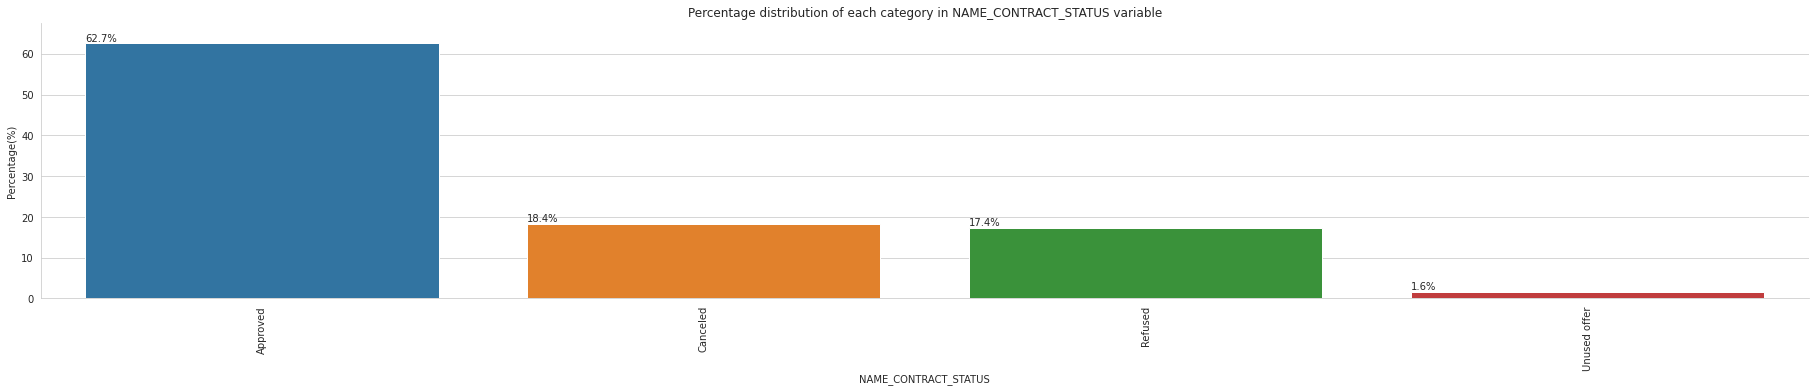

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


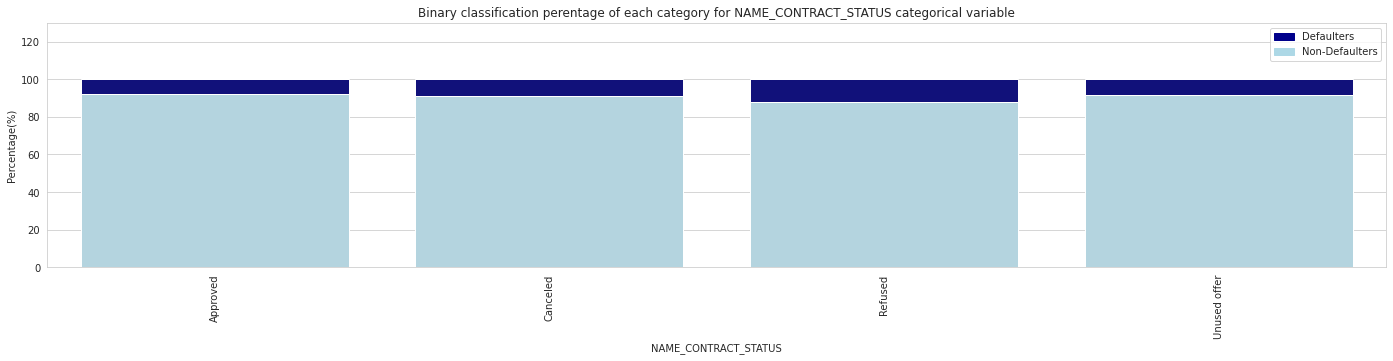

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


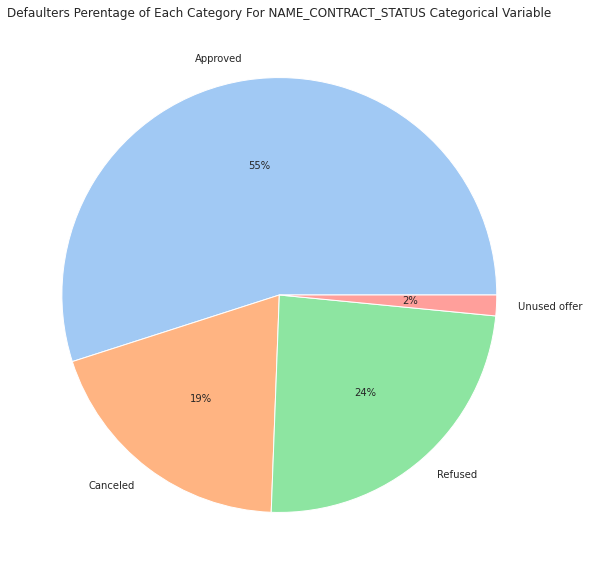

In [ ]:
# NAME_CONTRACT_STATUS  
category_var_plot(previous_application_merged,previous_application_top_categorical_var_lst[1])

**Observations and conclusions :**
1. NAME_CONTRACT_STATUS  represents the status of the previous credit applications with Home Credit and has 4 categories.
2. For around 1.15% of samples, NAME_CONTRACT_STATUS   is not defined. Amongst these NaN values, 94% are non defaulters.
3. For the defined categories, Approved constitute around 62.7% of samples and is the largest contract status type of the previous applications followed by cancelled and refused. Unused offer count is 1.6%.
4. Refused contract type has most percentage of defaulters than Approved if we observe the categoriwise defaulters percentage represented by stacked bar plot.
5. Pie chart shows the defaulters percentage in an entire data follows the similar distribution as observed in the count percentage bar plot. 
6. Approved contract status type has the largest count in the data and also has the overall largest defaulter percentage. Count of Refused contract type in the data is 17.4% however their defaulters are 24% amongst the entire defaulters data. 

### Categorical Variable 2: PRODUCT_COMBINATION  

Number of unique category values of PRODUCT_COMBINATION categorical variable are 17
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for PRODUCT_COMBINATION categorical variable are 1.17 %
Percentage of 0 labels for NaN value row is 93.78 %
Percentage of 1 labels for NaN value row is 6.22 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


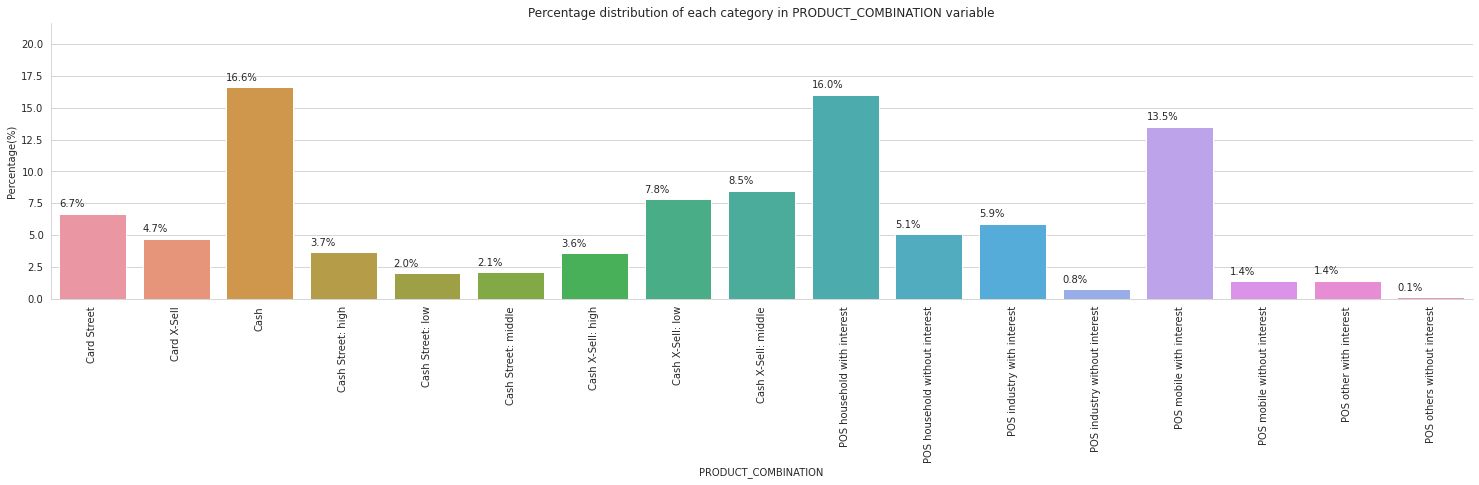

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


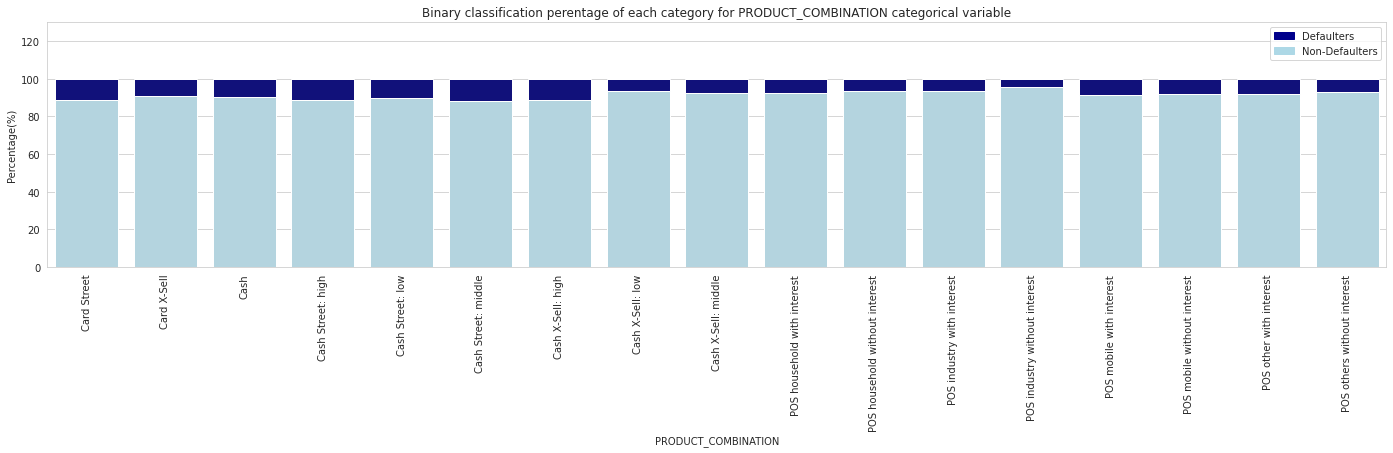

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


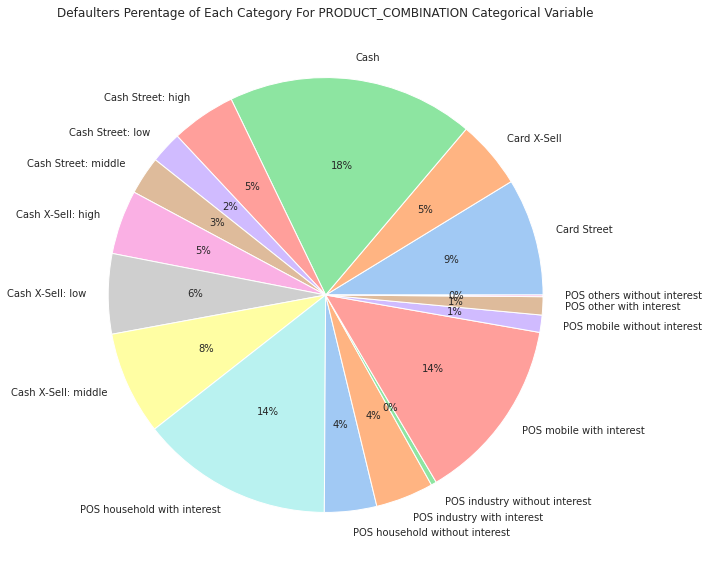

In [ ]:
# PRODUCT_COMBINATION   
category_var_plot(previous_application_merged,previous_application_top_categorical_var_lst[2])

**Observations and conclusions :**
1. PRODUCT_COMBINATION represents the product combination of the previous credit applications with Home Credit and has 17 categories.
2. For around 1.17% of samples, PRODUCT_COMBINATION   is not defined. Amongst these NaN values, 93.78% are non defaulters.
3. For the defined categories, Cash constitute around 16.6% of samples and is the largest product type of the previous applications followed by POS_HOUSEHOLD_WITH_INTEREST and POS_MOBILE_WITH_INTEREST. POS_OTHERS_WITHOUt_INTEREST count is 0.1%.
4. Cash-X-Sell:low and Cash-Street: Middle product types has most percentage of defaulters than Approved if we observe the categoriwise defaulters percentage represented by stacked bar plot.
5. Pie chart shows the defaulters percentage in an entire data follows the similar distribution as observed in the count percentage bar plot. 
6. Cash product type has the largest count in the data and also has the overall largest defaulter percentage. 

### Categorical Variable 3: CODE_REJECT_REASON   

Number of unique category values of CODE_REJECT_REASON categorical variable are 9
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for CODE_REJECT_REASON categorical variable are 1.15 %
Percentage of 0 labels for NaN value row is 94.04 %
Percentage of 1 labels for NaN value row is 5.96 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


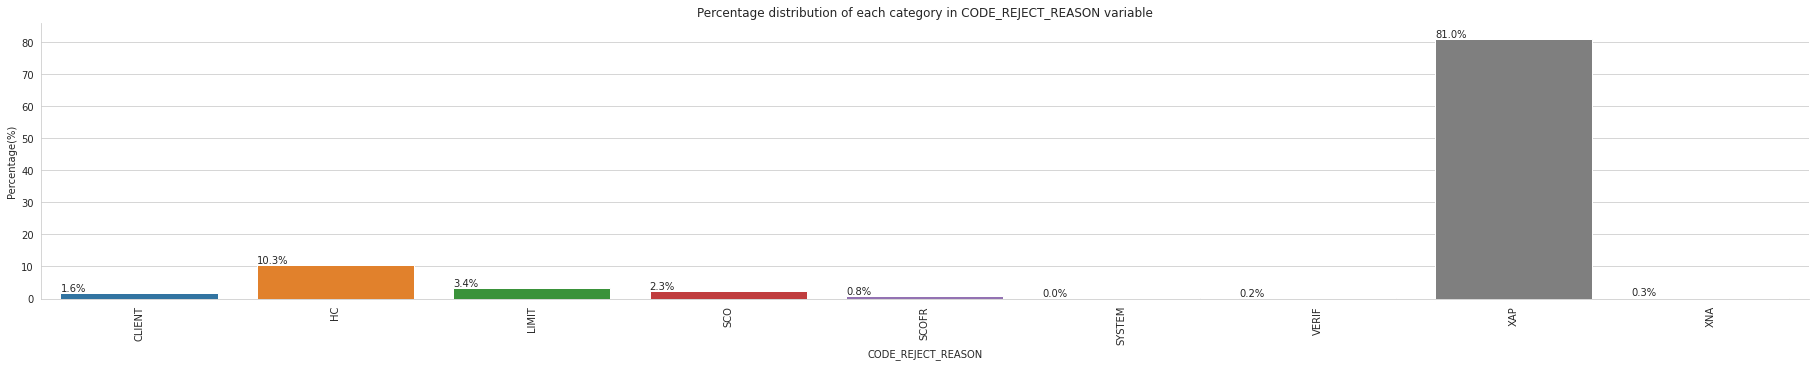

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


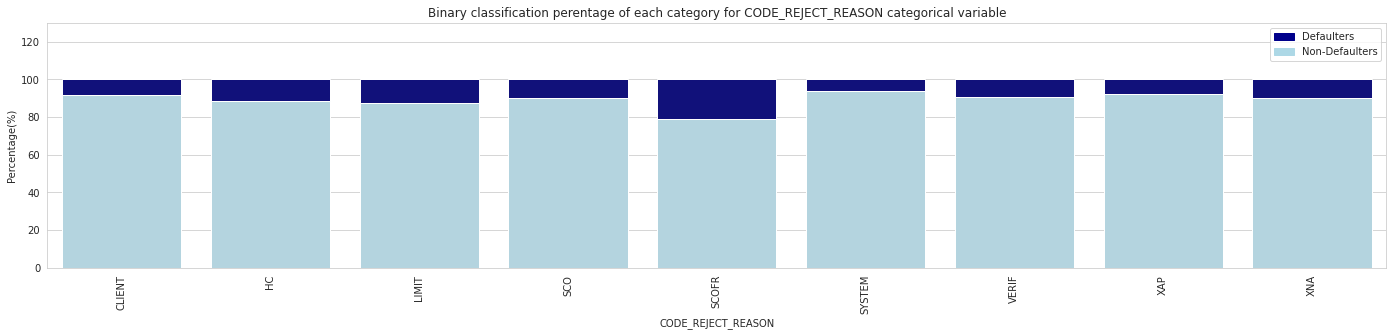

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


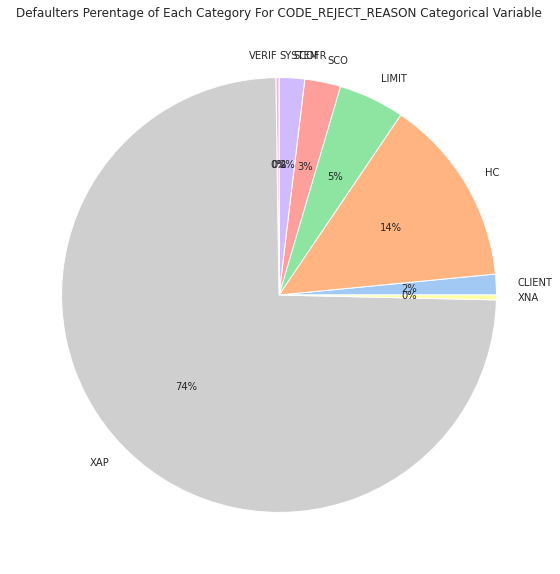

In [ ]:
# CODE_REJECT_REASON    
category_var_plot(previous_application_merged,previous_application_top_categorical_var_lst[3])

**Observations and conclusions :**
1. CODE_REJECT_REASON tells why was the previsous application rejected and has 9 categories.
2. For around 1.15% of samples, PRODUCT_COMBINATION   is not defined. Amongst these NaN values, 94.04% are non defaulters.
3. For the defined categories, XAP constitute around 81% of samples and is the largest reject reason of the previous applications followed by HC and Limit. SCOFR, System, VERF and XNA types has count around 0.1%.
4. SCOFR ref=ject reason types has most percentage of defaulters than Approved if we observe the categoriwise defaulters percentage represented by stacked bar plot however its count is almost 0%.
5. Pie chart shows the defaulters percentage in an entire data follows the similar distribution as observed in the count percentage bar plot. 
6. XAP product type has the largest count in the data and also has the overall largest defaulter percentage followed by HC and Limit.

### Categorical Variable 4: CNT_PAYMENT     

Number of unique category values of CNT_PAYMENT categorical variable are 48
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for CNT_PAYMENT categorical variable are 22.63 %
Percentage of 0 labels for NaN value row is 90.45 %
Percentage of 1 labels for NaN value row is 9.55 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


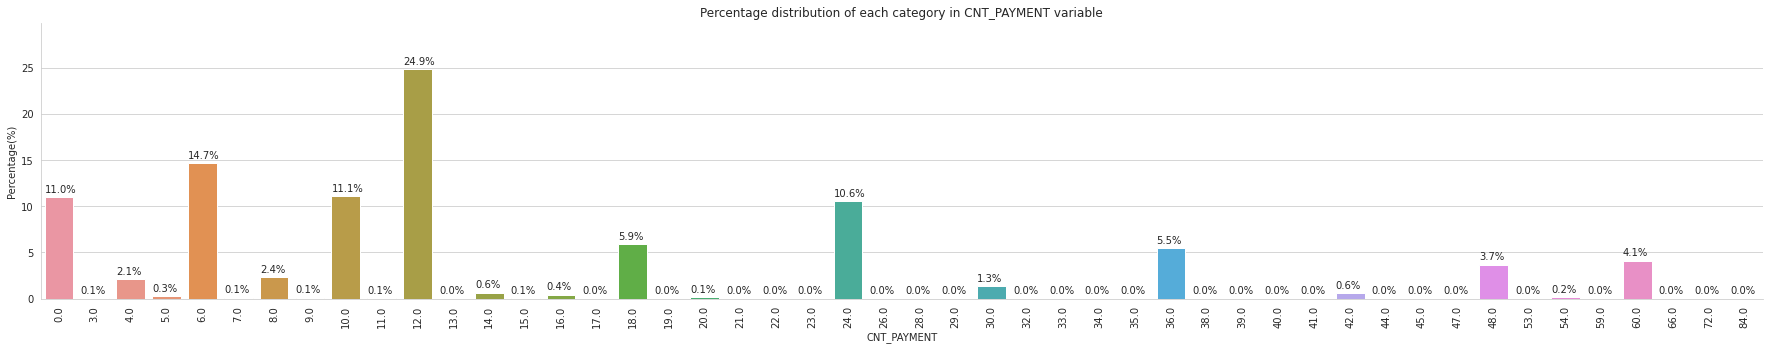

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


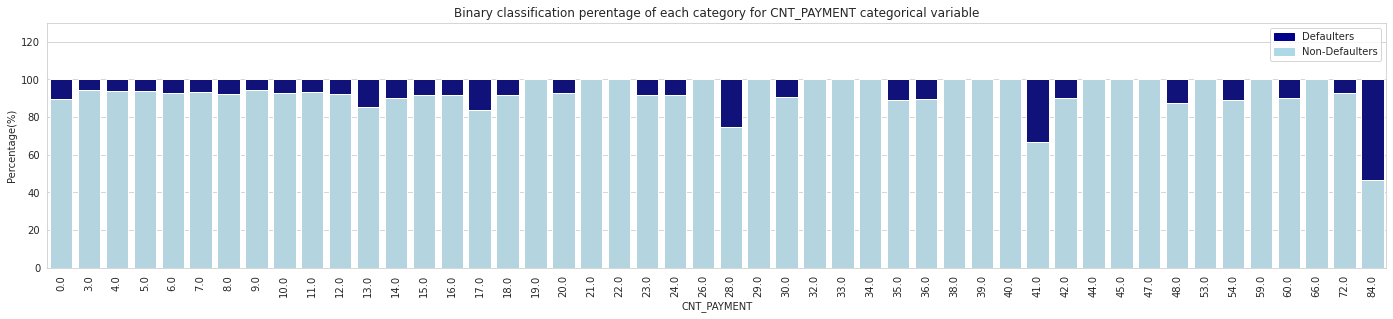

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


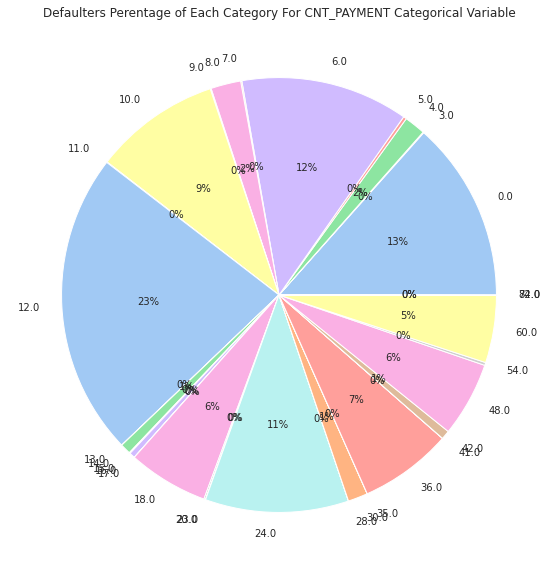

In [ ]:
# CNT_PAYMENT      
category_var_plot(previous_application_merged,previous_application_top_categorical_var_lst[4])

**Observations and conclusions :**
1. CNT_PAYMENT  tells term of previous credit at application of previous applications and has 48 categories.
2. For around 22.63% of samples, PRODUCT_COMBINATION   is not defined. Amongst these NaN values, 90.45% are non defaulters.
3. Term 12 shows the highest count. Most of the count in the CNT_PAYMENT are 0%. While featurization, these category types can be merged together.

### Categorical Variable 5: NAME_CONTRACT_TYPE 




Number of unique category values of NAME_CONTRACT_TYPE categorical variable are 4
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for NAME_CONTRACT_TYPE categorical variable are 1.15 %
Percentage of 0 labels for NaN value row is 94.04 %
Percentage of 1 labels for NaN value row is 5.96 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


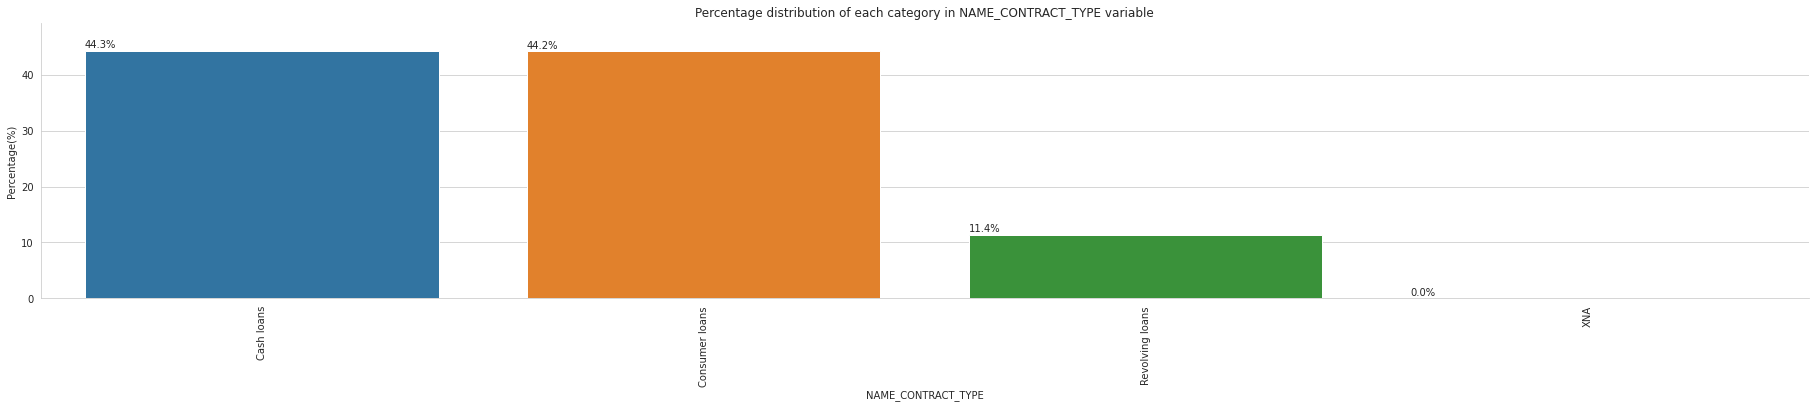

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


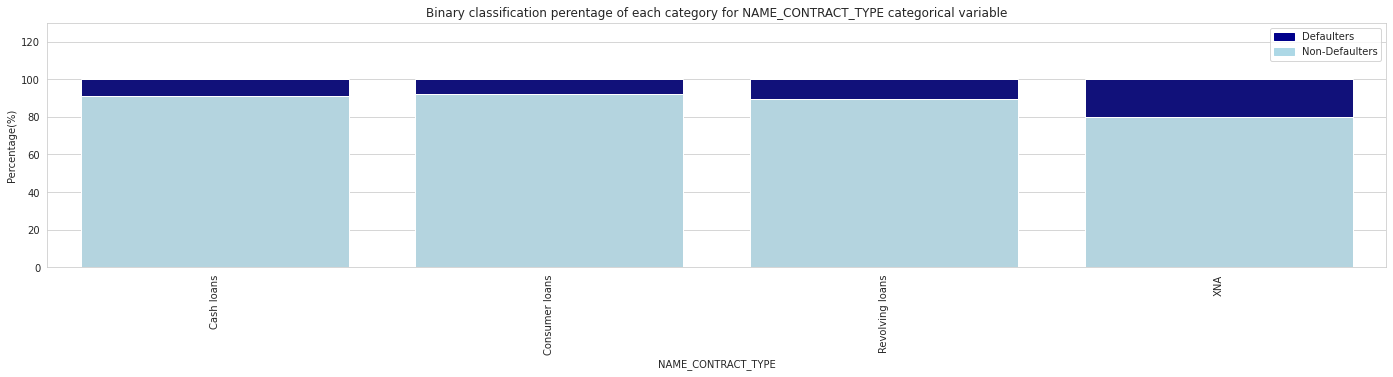

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


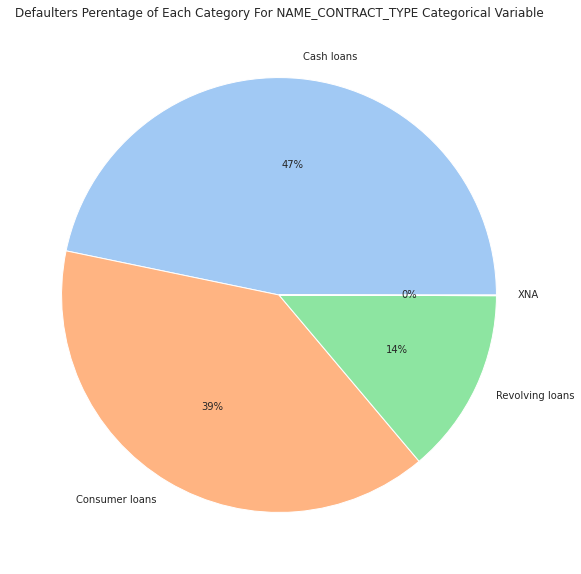

In [ ]:
# NAME_CONTRACT_TYPE       
category_var_plot(previous_application_merged,previous_application_top_categorical_var_lst[5])

**Observations and conclusions :**
1. NAME_CONTRACT_TYPE  represents the contract types of previous applications and has 4 categories. These 4 categories are Cash Loan, Consumer Loan, Revovling Loan and XNA.
2. For around 1.15% of samples, NAME_CONTRACT_TYPE   is not defined. Amongst these NaN values, 94.04% are non defaulters.
3. For the defined categories, Cash loan and consumer loans constitute around 44% of samples each while Revolving loan contract type is 11%. XNA type of contract are 0%.
4. Revolving loan types has most percentage of defaulters than Cash loand and consumer loan if we observe the categoriwise defaulters percentage represented by stacked bar plot.
5. Consumer loans, cash loan and revolving loans have 39%,47% and 14% of total defaulters.

## Previous Application Continuous variable plots

### Continous Variable 1 : DAYS_DECISION to YEARS_DECISION

This variable represents the how many days before current application did the decision about previous application made.

DAYS_DECISION = Previous application decision made date - application date

For interpretation of results we will convert the data in positive year values.

Continuous variable YEARS_DECISION has 16454 NaN rows.
Percentage of NaN rows for YEARS_DECISION continuous variable are 1.15 %
Percentage of 0 labels for NaN value row is 94.04 %
Percentage of 1 labels for NaN value row is 5.96 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


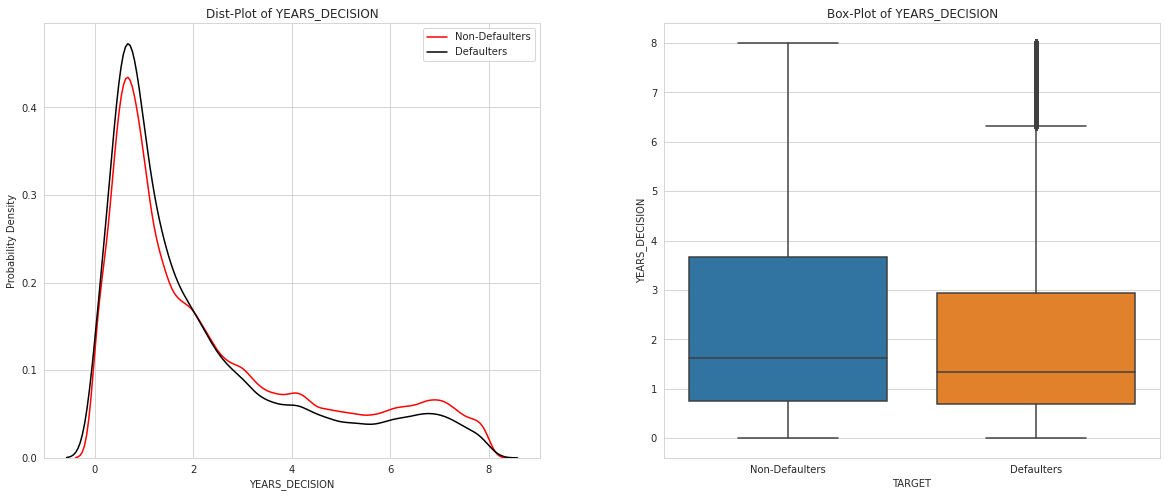

In [ ]:
# DAYS_DECISION to YEARS_DECISION
previous_application_merged["YEARS_DECISION"]=previous_application_merged[previous_application_top_continuous_var_lst[1]]*-1/365
plot_continuous_variables(previous_application_merged,"YEARS_DECISION")
previous_application_merged=previous_application_merged.drop(["YEARS_DECISION"],axis=1)

**Observations and Conclusions :**  
1. For around 1.15% of samples, YEARS_DECISION values is not defined. Amongst these NaN values, 94.04% are non defaulters.
2. Probability density plots of non defaulters and defaulters are right skewed. Defaulter density plot shows peak at lesser year credit value.
3. Intequertile range of non defaulters box plot is from 0.8 to 3.8 years while that of defaulters is from 0.8 to 2.95 years which is shorter than non defaulters.
4. Minimum and maximum values of both the categories of client are same. 
5. Median of defaulters is lesser than non defaulters.

### Continous Variable 2 : DAYS_FIRST_DRAWING  to YEARS_FIRST_DRAWING 

This variable represents the how many days before current application did the first disbursment of previous application happened.

DAYS_FIRST_DRAWING  = Previous application disbursment date - application date

For interpretation of results we will convert the data in year values.

Continuous variable YEARS_FIRST_DRAWING has 577560 NaN rows.
Percentage of NaN rows for YEARS_FIRST_DRAWING continuous variable are 40.38 %
Percentage of 0 labels for NaN value row is 89.85 %
Percentage of 1 labels for NaN value row is 10.15 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


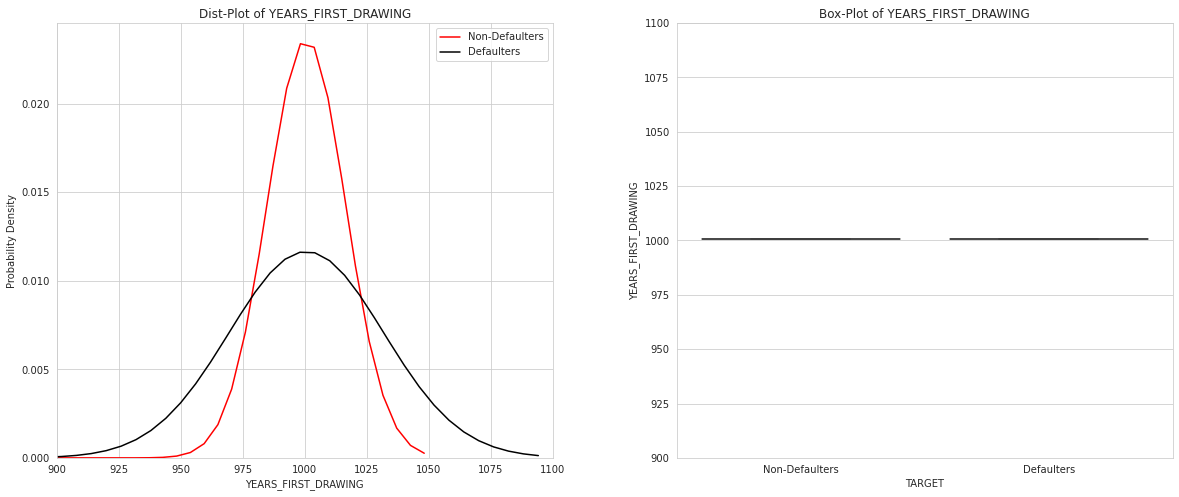

In [ ]:
# DAYS_FIRST_DRAWING  to YEARS_FIRST_DRAWING
previous_application_merged["YEARS_FIRST_DRAWING"]=previous_application_merged[previous_application_top_continuous_var_lst[2]]/365
plot_continuous_variables(previous_application_merged,"YEARS_FIRST_DRAWING","Yes",(900,1100),(900,1100))
previous_application_merged=previous_application_merged.drop(["YEARS_FIRST_DRAWING"],axis=1)

**Observations and Conclusions :**  
1. For around 40.38% of samples, YEARS_FIRST_DRAWING values is not defined. Amongst these NaN values, 89.85% are non defaulters.
2. Probability density plots of non defaulters and defaulters are bell shaped curve around 1000 years values. Non defaulter density plot shows higher peak at 100.
3. Very high number of values for defaulters and non defaulters occur at 1000 year value and hence the interqurtile range is a line. Median and mode also occurs at the same value.

### Continous Variable 3: RATE_INTEREST_PRIVILEGED  

Continuous variable RATE_INTEREST_PRIVILEGED has 1425364 NaN rows.
Percentage of NaN rows for RATE_INTEREST_PRIVILEGED continuous variable are 99.67 %
Percentage of 0 labels for NaN value row is 91.37 %
Percentage of 1 labels for NaN value row is 8.63 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


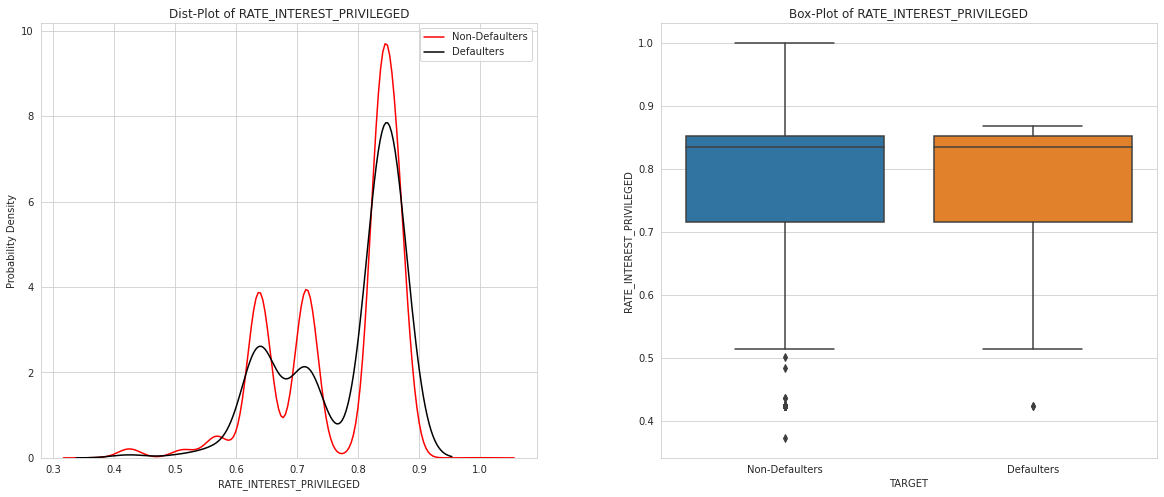

In [ ]:
# RATE_INTEREST_PRIVILEGED 
plot_continuous_variables(previous_application_merged,previous_application_top_continuous_var_lst[3])

**Observations and Conclusions :**  
1. This variable tells the normalized interest rate of previous applications.
2. For around 99.67% of samples, RATE_INTEREST_PRIVILEGED  values is not defined. For very small number of samples the normlized intrest rate is defined. While featurizing this needs to be handeled caerfully. Amongst these NaN values, 91.37% are non defaulters.
3. Probability density plots of non defaulters and defaulters hows multiple peaks.
4. Intequertile range, median of non defaulters and defailters box plot is same.

### Continous Variable 4: RATE_DOWN_PAYMENT   

Continuous variable RATE_DOWN_PAYMENT has 765994 NaN rows.
Percentage of NaN rows for RATE_DOWN_PAYMENT continuous variable are 53.56 %
Percentage of 0 labels for NaN value row is 90.53 %
Percentage of 1 labels for NaN value row is 9.47 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


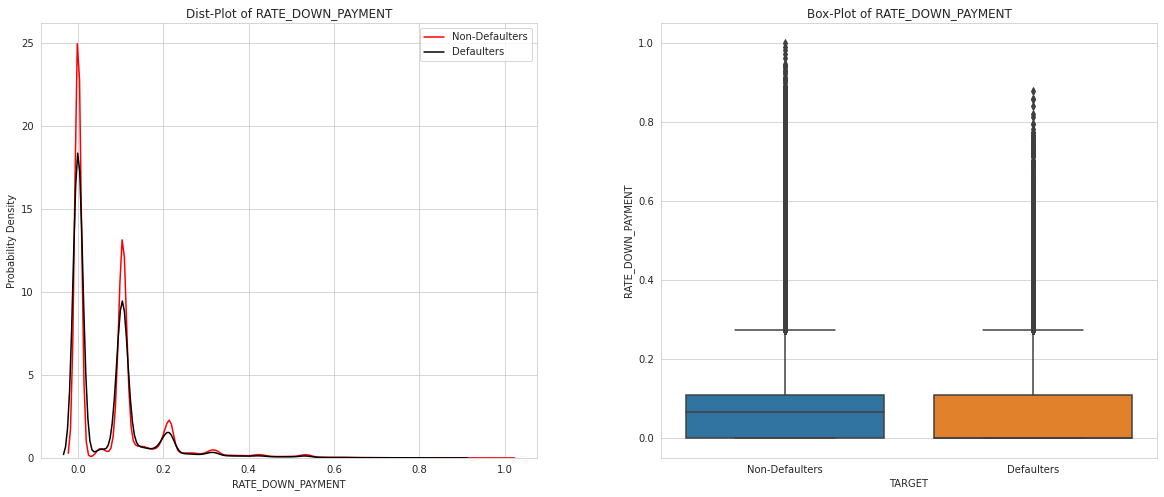

In [ ]:
# RATE_DOWN_PAYMENT 
plot_continuous_variables(previous_application_merged,previous_application_top_continuous_var_lst[4])

**Observations and Conclusions :**  
1. RATE_DOWN_PAYMENT tells the down payment normalized rate on the previous applications.
2. For around 53.56% of samples, YEARS_DECISION values is not defined. Amongst these NaN values, 90.53% are non defaulters.
2. Probability density plots of non defaulters and defaulters are right skewed with multiple peaks. Non defaulter density plot shows peak at lesser year credit value.
3. Intequertile range of non defaulters and non defaulters box plot is same.
4. For both non defaulters and defaulters, most of the values of down payment interest rate lies between 0 to 0.28
5. Median of defaulters is lesser than non defaulters.

### Continous Variable 5 : DAYS_LAST_DUE_1ST_VERSION  to Years_LAST_DUE_1ST_VERSION 

This variable represents the how many days before current application did the first due of the previous application happened.

DAYS_LAST_DUE_1ST_VERSION = Previous applications first due date - application date

For interpretation of results we will convert the data in positive year values.

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The 0th percentile value of Years_LAST_DUE_1ST_VERSION is -1000.6657534246575
The 9th percentile value of Years_LAST_DUE_1ST_VERSION is -1000.6657534246575
The 10th percentile value of Years_LAST_DUE_1ST_VERSION is -3.7643835616438355
The 25th percentile value of Years_LAST_DUE_1ST_VERSION is -0.3698630136986301
The 50th percentile value of Years_LAST_DUE_1ST_VERSION is 0.9808219178082191
The 75th percentile value of Years_LAST_DUE_1ST_VERSION is 3.408219178082192
The 90th percentile value of Years_LAST_DUE_1ST_VERSION is 5.602739726027397
The 100th percentile value of Years_LAST_DUE_1ST_VERSION is 7.673972602739726
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Cont

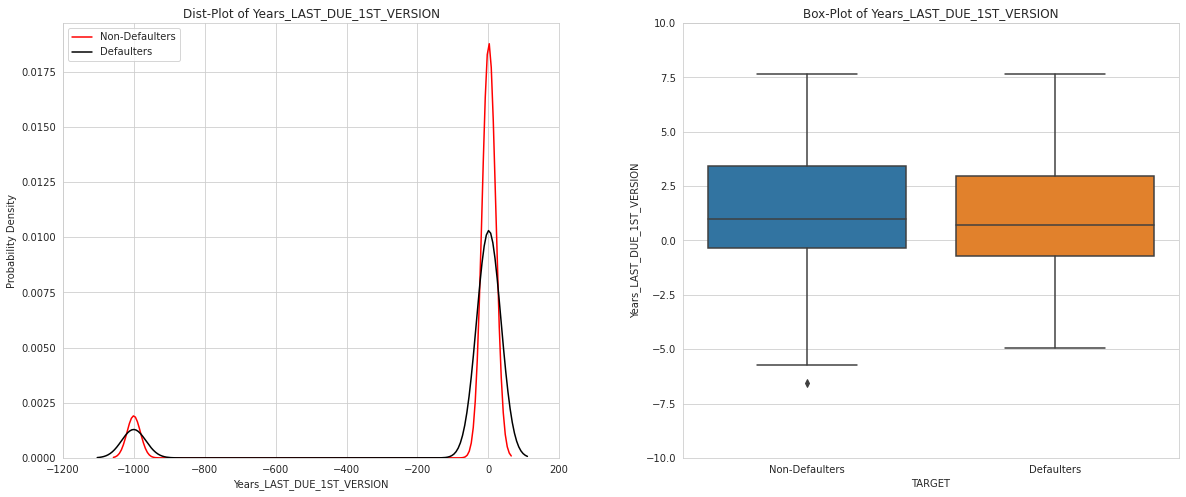

In [ ]:
# DAYS_LAST_DUE_1ST_VERSION  to Years_LAST_DUE_1ST_VERSION 
previous_application_merged["Years_LAST_DUE_1ST_VERSION"]=previous_application_merged[previous_application_top_continuous_var_lst[5]]*-1/365
print_percentiles(previous_application_merged,"Years_LAST_DUE_1ST_VERSION",percentiles=[0,9,10,25,50,75,90,100])
plot_continuous_variables(previous_application_merged,"Years_LAST_DUE_1ST_VERSION","Yes",(-1200,200),(-10,10))
previous_application_merged=previous_application_merged.drop(["Years_LAST_DUE_1ST_VERSION"],axis=1)

**Observations and Conclusions :**  
1. Row samples of Years_LAST_DUE_1ST_VERSION  continuous variable has around 40.38% NaN values out of which 89.85% are non defaulters.
2. 90 percentile of values lies between -3.7 to 6.7 years while 10 percentile value are 1000 years.Most of the applicants have Years_LAST_DUE_1ST_VERSION years between -7.5 to 7.5 years. Few of the outliers with high values such as 1000 years are also observed. These values constitute around 10 percentiles and are clearly the wrong data. This needs to be addressed while doing featurization. One way is to saturate to max 50 years.
3. Values with negative years is also of concern. When the data about the previous applications first due relative to the current application is filled, the years values should be positive. This also needs to be addressed while featurizing. One way is to saturate the negative year values to 0.
2. Probability density plot of non defaulters and defaulters shows a bell shaped curve around 0 year value. Non defaulters density plot has a higher density plot than defaulters.
3. Interquartile range and median of non defaulters and defautlers is similar.

### Top Continuous Variables Pair Plot

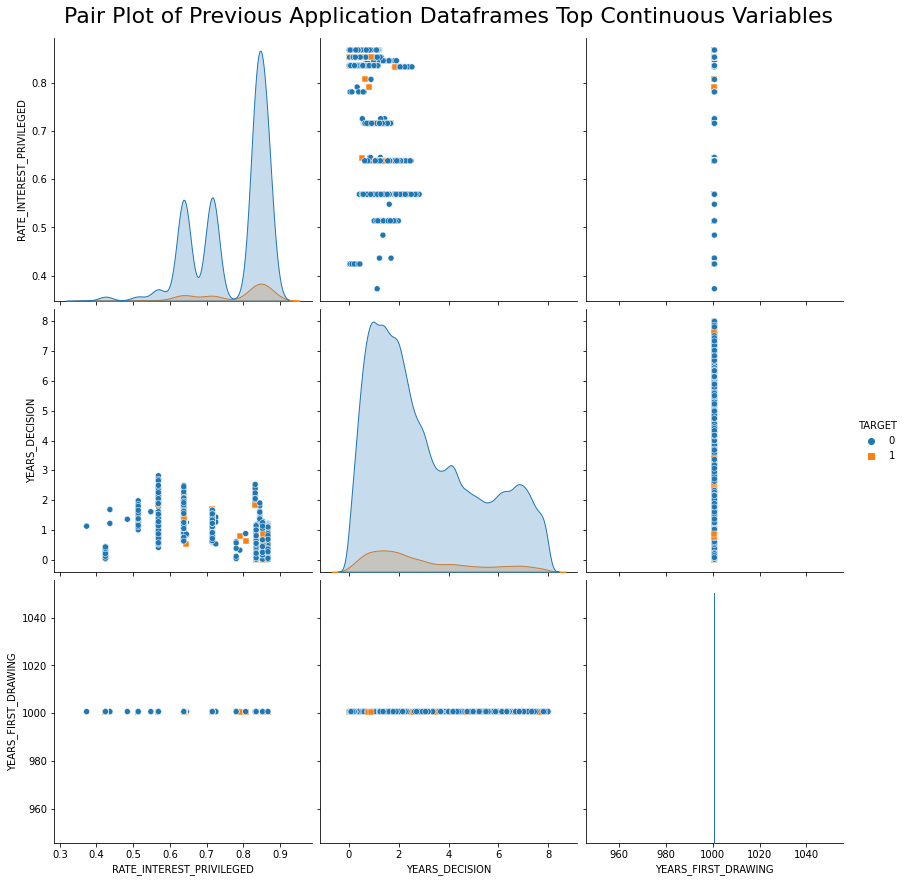

In [ ]:
df=previous_application_merged[["TARGET","DAYS_DECISION","DAYS_FIRST_DRAWING","RATE_INTEREST_PRIVILEGED"]]
df["YEARS_DECISION"]=df["DAYS_DECISION"]*-1/365
df["YEARS_FIRST_DRAWING"]=df["DAYS_FIRST_DRAWING"]/365
df=df.drop(["DAYS_DECISION","DAYS_FIRST_DRAWING"],axis=1)
df = df[df['YEARS_FIRST_DRAWING'] >= 900]
df = df[df['YEARS_FIRST_DRAWING'] <= 1100]
pairPlotFn(df,"Previous Application")

**Observations and Conclusions:** 
1. In this pair plot Previous Application dataframes top 3 continuous variables correlated with Targer variable are plotted.
2. 0 represents the non defaulters while 1 represents the defaulters.
3. Outliers are removed before plotting a pairplot from few of the variables for better visualization. THese outlier values are derived from box plot.
4. None of the subplots of this pair plot shows a clear linear seperation between the Target variables defaulters and non defaulters categoris.


# Installments payments Dataframe Statistics

In [ ]:
installments_payments=pd.read_csv("installments_payments.csv")
installments_payments

SK_ID_PREV  SK_ID_CURR  ...  AMT_INSTALMENT  AMT_PAYMENT
0            1054186      161674  ...        6948.360     6948.360
1            1330831      151639  ...        1716.525     1716.525
2            2085231      193053  ...       25425.000    25425.000
3            2452527      199697  ...       24350.130    24350.130
4            2714724      167756  ...        2165.040     2160.585
...              ...         ...  ...             ...          ...
13605396     2186857      428057  ...          67.500          NaN
13605397     1310347      414406  ...          67.500          NaN
13605398     1308766      402199  ...       43737.435          NaN
13605399     1062206      409297  ...          67.500          NaN
13605400     2448869      434321  ...       11504.250          NaN

[13605401 rows x 8 columns]

In [ ]:
print("Shape of Installments Payments dataframe is ",installments_payments.shape)
print("Number of unique values of SK_ID_PREV in Installments Payments are ",installments_payments["SK_ID_PREV"].nunique())
# lets understand the common id's between application_train.csv and Installments Payments
com_len_train=len(list(set(application_train["SK_ID_CURR"]) & set(installments_payments["SK_ID_CURR"])))
print("Common id's between application_train and installments_payments are ",com_len_train)
print("Corresponding percentage is ",round(com_len_train/len(set(application_train["SK_ID_CURR"]))*100,2))
print("-"*185)
# lets understand the common id's between previous applications and Installments Payments
com_len_train=len(list(set(previous_application["SK_ID_PREV"]) & set(installments_payments["SK_ID_PREV"])))
print("Common id's between previous_application and installments_payments are ",com_len_train)
print("Corresponding percentage is ",round(com_len_train/len(set(previous_application["SK_ID_PREV"]))*100,2))

Shape of Installments Payments dataframe is  (13605401, 8)
Number of unique values of SK_ID_PREV in Installments Payments are  997752
Common id's between application_train and installments_payments are  291643
Corresponding percentage is  94.84
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Common id's between previous_application and installments_payments are  958905
Corresponding percentage is  57.41


Number of variables having NaN samples are  2


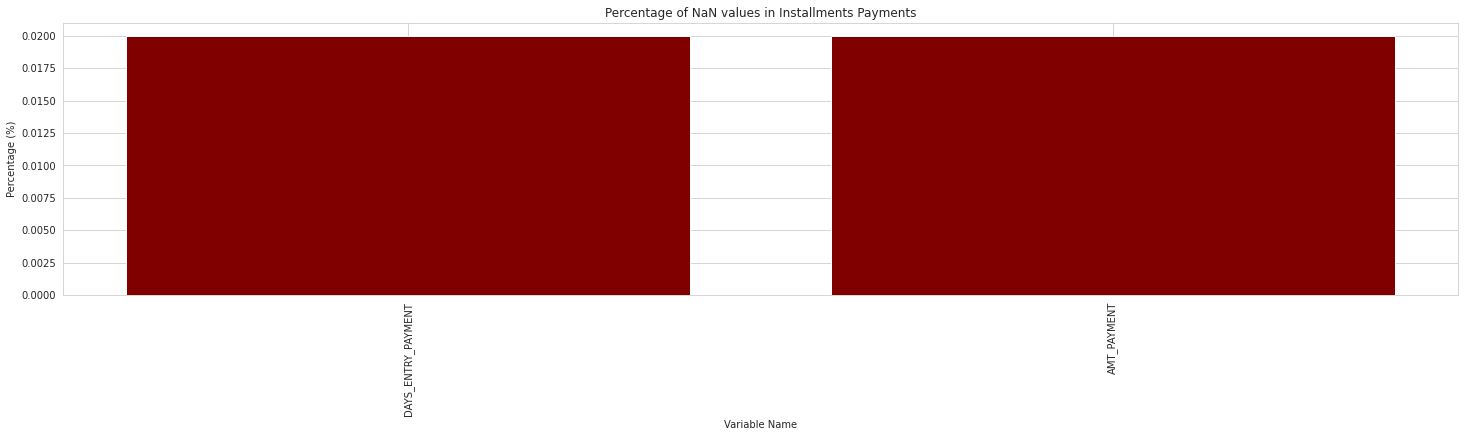

In [ ]:
#NaN variable percentatge in dataframe
plot_nan_pct(installments_payments,"Installments Payments")

**Observations and Conclusions:**
1. Installments Payments dataframe has total 8 columns. Out of these, 2 variables have 0.02% NaN values. 2 variables are DAYS_ENTRY_PAYMENT and AMT_PAYMENT.
2. Out of the total apllicants present in application train dataframe, 94.85% of appplicants infromation about one of the previous applicatns intallment payment with Home Credit is captured with installment payments dataframe. Around 57% of previous apllications intalllment payment information is captured by installment payment dataframe.
3. SK_ID_PREV which represents ID of previous credit with Home Credit for applicant and SK_ID_CURR is the ID of application. Both of these are not unique.
4. All the variables of Installment Payments dataframe are continuous.


### Installment Payments Dataframe Variable Correlation
Lets assign the "TARGET"variable to each installment payment sample. We will use application_train and installment payments common ID to assign the Target label. We will remove the dataframe samples for which target label is not assigned.

After merging we will undesrstand the correlation between target variable and continuous variables.

In [ ]:
print("Merging TARGET with Installment Payments dataframe")
installments_payments_merged = application_train.iloc[:,:2].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')
print("Percentage of {} labels for NaN value row is {} %".format(installments_payments_merged["TARGET"].value_counts().index.tolist()[0],round(installments_payments_merged["TARGET"].value_counts()[0]/installments_payments_merged.shape[0]*100,2)))
print("Percentage of {} labels for NaN value row is {} %".format(installments_payments_merged["TARGET"].value_counts().index.tolist()[1],round(installments_payments_merged["TARGET"].value_counts()[1]/installments_payments_merged.shape[0]*100,2)))
print("Applicants labelled 1 are defaulters.")
print("-"*100)
installments_payments_merged.head()

Merging TARGET with Installment Payments dataframe
Percentage of 0 labels for NaN value row is 92.41 %
Percentage of 1 labels for NaN value row is 7.59 %
Applicants labelled 1 are defaulters.
----------------------------------------------------------------------------------------------------


SK_ID_CURR  TARGET  ...  AMT_INSTALMENT  AMT_PAYMENT
0      100002       1  ...        9251.775     9251.775
1      100002       1  ...        9251.775     9251.775
2      100002       1  ...       53093.745    53093.745
3      100002       1  ...        9251.775     9251.775
4      100002       1  ...        9251.775     9251.775

[5 rows x 9 columns]

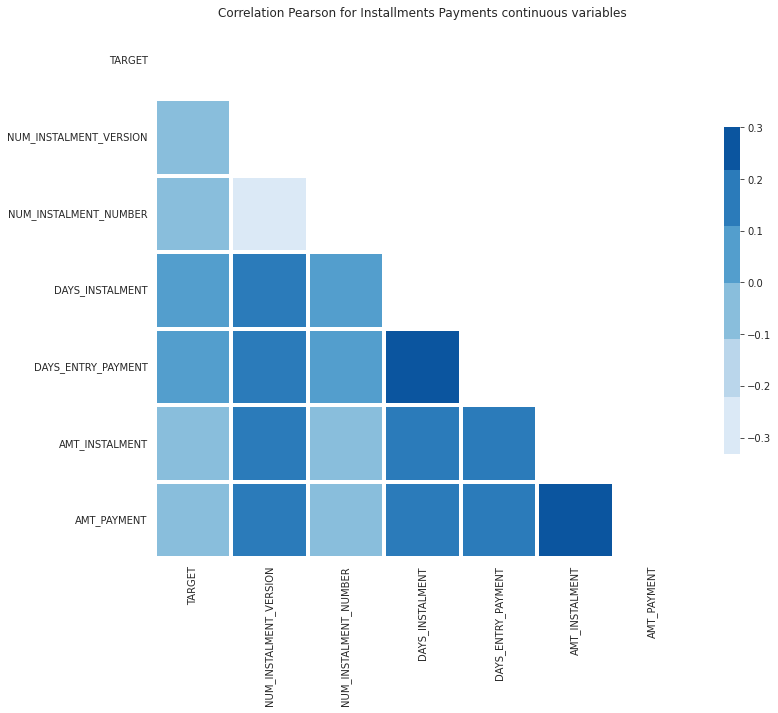

----------------------------------------------------------------------------------------------------
Correlation between continuous variable and Target variable sorted in descending order are :



TARGET                    1.000000
DAYS_ENTRY_PAYMENT        0.035122
DAYS_INSTALMENT           0.034974
NUM_INSTALMENT_NUMBER     0.016190
NUM_INSTALMENT_VERSION    0.009896
AMT_PAYMENT               0.003623
AMT_INSTALMENT            0.001498
Name: TARGET, dtype: float64

In [ ]:
# Lets similarly observe the correlation between continuous variables and Target variable using Pearson correlatino coefficient
installments_payments_continuous=installments_payments_merged.drop(["SK_ID_CURR","SK_ID_PREV"],axis=1)

# Computing the Pearson correlation coefficients
corr=installments_payments_continuous.corr()

# Plotting the correlation matrix
mask_array = np.ones(corr.shape)
mask_array = np.triu(mask_array)

f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.color_palette("Blues")

sns.heatmap(corr, 
            mask=mask_array, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation Pearson for Installments Payments continuous variables")
plt.show()

print("-"*100)
previous_application_top_continuous_var_lst=corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between continuous variable and Target variable sorted in descending order are :\n")
corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

**Observations and Conclusions:**
1. Installment Payments dataframe is left merged on the application datafeame for a common SK_ID_CURR to get the Target variable from application dataframe for each row of Installment Payments. Installment Payments dataframe rows gets removed for which Target is not present. 
2. In the merged dataframe, 92.41% are non defaulters while 7.59% are defaulters.
3. A week correaltion between the variables and Target label is observed from the  continuous variables correaltions matrix. THis describes that there is no linear correaltion amongst the Target variable and continuous variable. 
4. Amongst all continuous variables, DAYS_ENTRY_PAYMENT shows a high correlation wrt Target label.
5. Variables 'DAYS_INSTALMENT' and 'DAYS_ENTRY_PAYMENT' which tells about the time when the installment about the previous credit was supposed to be paid and when it was actually paid, shows a high correlations with each other. Also variables 'AMT_INSTALMENT' and 'AMT_PAYMENT' tells about the amount supposed to be pain and the actual amount paid shows a high correlation with each other.
6. We will plot the first 2 continuous variables plot wrt Target variable.

## Installment Payments Continuous Variable Plots

### Continuous variable 1: DAYS_ENTRY_PAYMENT to YEARS_ENTRY_PAYMENT 
This variable represents the how many days before current application did the actual installment credit payment happened.

DAYS_ENTRY_PAYMENT = Previous credits installment paid date - application date

For interpretation of results we will convert the data in positive year values.        

Continuous variable YEARS_ENTRY_PAYMENT has 18451 NaN rows.
Percentage of NaN rows for YEARS_ENTRY_PAYMENT continuous variable are 0.16 %
Percentage of 0 labels for NaN value row is 91.65 %
Percentage of 1 labels for NaN value row is 8.35 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


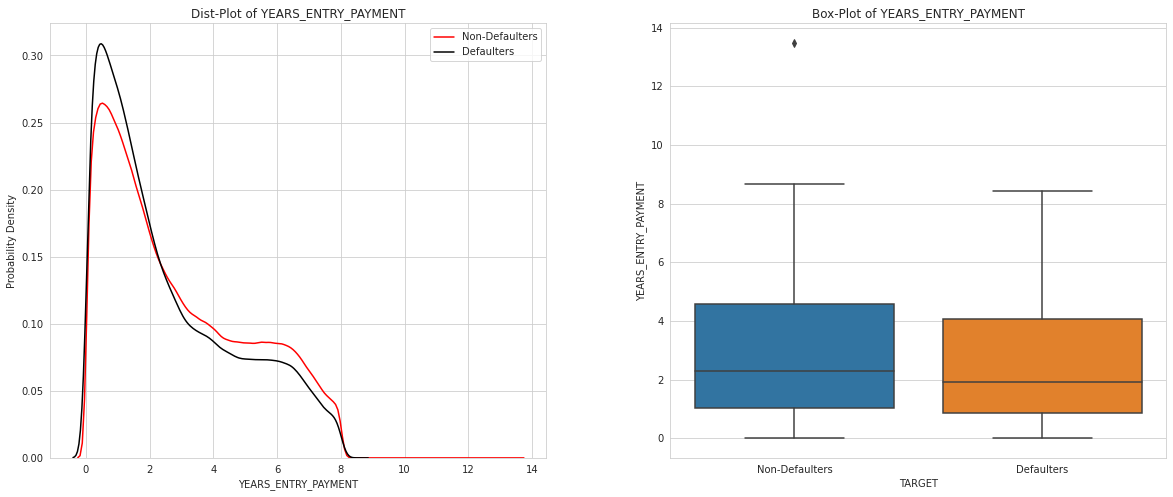

In [ ]:
# DAYS_ENTRY_PAYMENT to YEARS_ENTRY_PAYMENT 
installments_payments_merged["YEARS_ENTRY_PAYMENT"]=installments_payments_merged[previous_application_top_continuous_var_lst[1]]*-1/365
plot_continuous_variables(installments_payments_merged,"YEARS_ENTRY_PAYMENT")
installments_payments_merged=installments_payments_merged.drop(["YEARS_ENTRY_PAYMENT"],axis=1)

**Observations and Conclusions :**  
1. Row samples of YEARS_ENTRY_PAYMENT continuous variable have 0.16% NaN values out of which 91.65% are non defaulters.
2. Probability density plots of non defaulters and defaulters are right skewed. Defaulter density plot shows peak at lesser year credit value.
3. Intequertile range of non defaulters box plot is from 1.1 to 4.4 years while that of defaulters is from 1 to 4.1 years which is shorter than non defaulters.
4. Minimum and maximum values of both the categories of client are same. 
5. Median of defaulters is lesser than non defaulters.

### Continuous variable 2: DAYS_INSTALMENT  to YEARS_INSTALMENT
This variable represents the how many days before current application did the  installment credit payment supposed to happen.

DAYS_INSTALMENT = Previous credits installment payment requested date - application date

For interpretation of results we will convert the data in positive year values.         

Continuous variable YEARS_INSTALMENT has 15868 NaN rows.
Percentage of NaN rows for YEARS_INSTALMENT continuous variable are 0.14 %
Percentage of 0 labels for NaN value row is 94.02 %
Percentage of 1 labels for NaN value row is 5.98 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


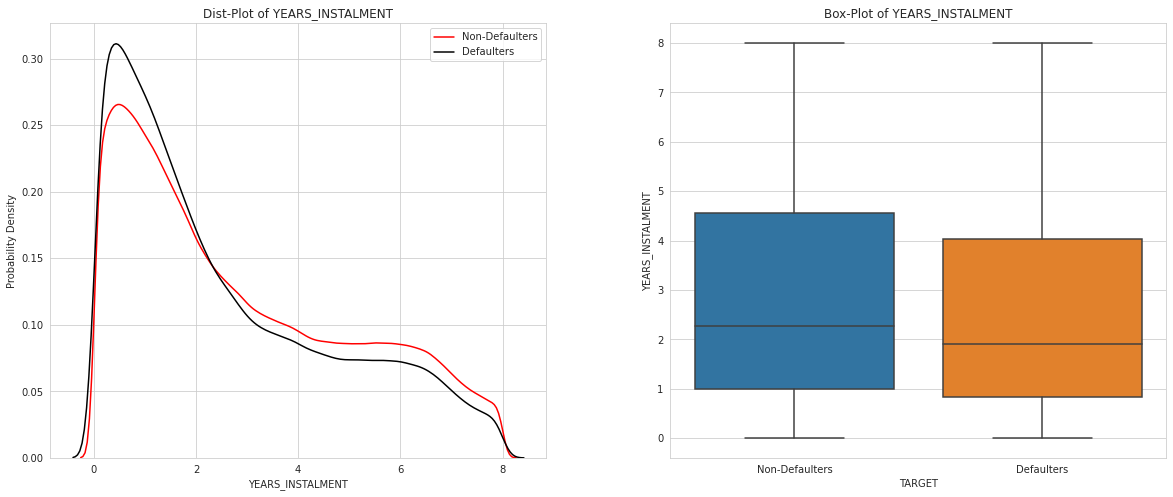

In [ ]:
# DAYS_INSTALMENT  to YEARS_INSTALMENT  
installments_payments_merged["YEARS_INSTALMENT"]=installments_payments_merged[previous_application_top_continuous_var_lst[2]]*-1/365
plot_continuous_variables(installments_payments_merged,"YEARS_INSTALMENT")
installments_payments_merged=installments_payments_merged.drop(["YEARS_INSTALMENT"],axis=1)

**Observations and Conclusions :**  
1. Row samples of YEARS_INSTALMENT continuous variable have 0.14% NaN values out of which 94.02% are non defaulters.
2. Probability density plots of non defaulters and defaulters are right skewed. Defaulter density plot shows peak at lesser year credit value.
3. Intequertile range of non defaulters box plot is from 1 to 46 years while that of defaulters is from 0.9 to 4.05 years which is shorter than non defaulters.
4. Minimum and maximum values of both the categories of client are same. 
5. Median of defaulters is lesser than non defaulters.

### Top Continuous Variables Pair Plot

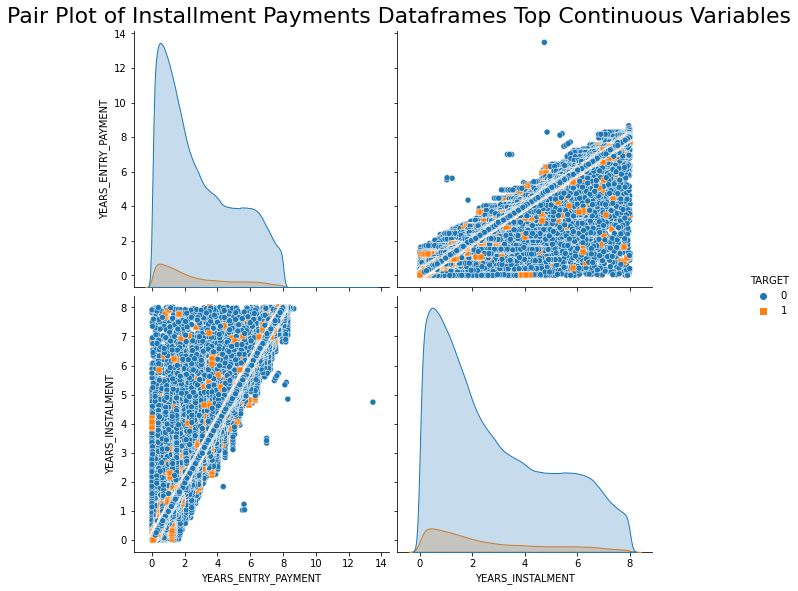

In [ ]:
df=installments_payments_merged[["TARGET","DAYS_ENTRY_PAYMENT","DAYS_INSTALMENT"]]
df["YEARS_ENTRY_PAYMENT"]=df["DAYS_ENTRY_PAYMENT"]*-1/365
df["YEARS_INSTALMENT"]=df["DAYS_INSTALMENT"]*-1/365
df=df.drop(["DAYS_ENTRY_PAYMENT","DAYS_INSTALMENT"],axis=1)
pairPlotFn(df,"Installment Payments")

**Observations and Conclusions:** 
1. In this pair plot Previous Application dataframes top 2 continuous variables correlated with Targer variable are plotted.
2. 0 represents the non defaulters while 1 represents the defaulters.
4. None of the subplots of this pair plot shows a clear linear seperation between the Target variables defaulters and non defaulters categoris.


# Pos_Cash_Balance Dataframe Statistics

In [ ]:
POS_CASH_balance=pd.read_csv("POS_CASH_balance.csv")
POS_CASH_balance

SK_ID_PREV  SK_ID_CURR  ...  SK_DPD  SK_DPD_DEF
0            1803195      182943  ...       0           0
1            1715348      367990  ...       0           0
2            1784872      397406  ...       0           0
3            1903291      269225  ...       0           0
4            2341044      334279  ...       0           0
...              ...         ...  ...     ...         ...
10001353     2448283      226558  ...     843           0
10001354     1717234      141565  ...     602           0
10001355     1283126      315695  ...     609           0
10001356     1082516      450255  ...     614           0
10001357     1259607      174278  ...       0           0

[10001358 rows x 8 columns]

In [ ]:
print("Shape of POS_CASH_balance dataframe is ",POS_CASH_balance.shape)
print("Number of unique values of SK_ID_PREV in POS_CASH_balance are ",POS_CASH_balance["SK_ID_PREV"].nunique())
# lets understand the common id's between application_train.csv and POS_CASH_balance
com_len_train=len(list(set(application_train["SK_ID_CURR"]) & set(POS_CASH_balance["SK_ID_CURR"])))
print("Common id's between application_train and POS_CASH_balance are ",com_len_train)
print("Corresponding percentage is ",round(com_len_train/len(set(application_train["SK_ID_CURR"]))*100,2))
print("-"*100)
# lets understand the common id's between previous applications and POS_CASH_balance
com_len_train=len(list(set(previous_application["SK_ID_PREV"]) & set(POS_CASH_balance["SK_ID_PREV"])))
print("Common id's between previous_application and POS_CASH_balance are ",com_len_train)
print("Corresponding percentage is ",round(com_len_train/len(set(previous_application["SK_ID_PREV"]))*100,2))

Shape of POS_CASH_balance dataframe is  (10001358, 8)
Number of unique values of SK_ID_PREV in POS_CASH_balance are  936325
Common id's between application_train and POS_CASH_balance are  289444
Corresponding percentage is  94.12
----------------------------------------------------------------------------------------------------
Common id's between previous_application and POS_CASH_balance are  898903
Corresponding percentage is  53.82


Number of variables having NaN samples are  2


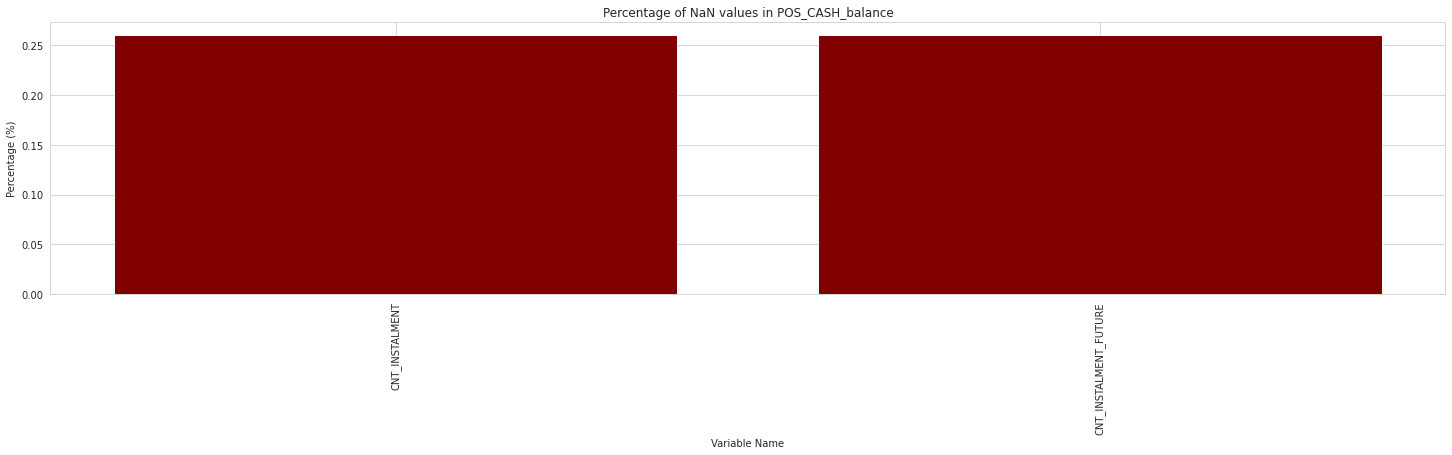

In [ ]:
#NaN variable percentatge in dataframe
plot_nan_pct(POS_CASH_balance,"POS_CASH_balance")

**Observations and Conclusions:**
1. POS_CASH_balance dataframe has total 8 columns. Out of these, 2 variables have 0.25% NaN values. 2 variables are CNT_INSTALMENT and CNT_INSTALMENT_FUTURE.
2. Out of the total apllicants present in application train dataframe, 94.12% of appplicants infromation about atleast one of the credits monthly balance information with Home Credit is captured with POS_CASH_balance dataframe. Around 53.82% of clients previous credits monthly balance information is captured by POS_CASH_balance dataframe.
3. SK_ID_PREV which represents ID of previous credit with Home Credit for applicant and SK_ID_CURR is the ID of application. Both of these are not unique.
4. All the variables of Installment Payments dataframe are continuous.


## POS_CASH_balance Dataframe Variable Correlation
Lets assign the "TARGET"variable to each POS_CASH_balance sample. We will use application_train and POS_CASH_balance common ID to assign the Target label. We will remove the dataframe samples for which target label is not assigned.

After merging we will undesrstand the correlation between target variable and continuous variables.

In [ ]:
print("Merging TARGET with POS_CASH_balance dataframe")
POS_CASH_balance_merged = application_train.iloc[:,:2].merge(POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')
print("Percentage of {} labels for NaN value row is {} %".format(POS_CASH_balance_merged["TARGET"].value_counts().index.tolist()[0],round(POS_CASH_balance_merged["TARGET"].value_counts()[0]/POS_CASH_balance_merged.shape[0]*100,2)))
print("Percentage of {} labels for NaN value row is {} %".format(POS_CASH_balance_merged["TARGET"].value_counts().index.tolist()[1],round(POS_CASH_balance_merged["TARGET"].value_counts()[1]/POS_CASH_balance_merged.shape[0]*100,2)))
print("Applicants labelled 1 are defaulters.")
print("-"*100)
POS_CASH_balance_merged.head()

Merging TARGET with POS_CASH_balance dataframe
Percentage of 0 labels for NaN value row is 92.64 %
Percentage of 1 labels for NaN value row is 7.36 %
Applicants labelled 1 are defaulters.
----------------------------------------------------------------------------------------------------


SK_ID_CURR  TARGET  SK_ID_PREV  ...  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
0      100002       1   1038818.0  ...                Active     0.0         0.0
1      100002       1   1038818.0  ...                Active     0.0         0.0
2      100002       1   1038818.0  ...                Active     0.0         0.0
3      100002       1   1038818.0  ...                Active     0.0         0.0
4      100002       1   1038818.0  ...                Active     0.0         0.0

[5 rows x 9 columns]

In [ ]:
# Generating POS_CASH_balance categorical dataframe
POS_CASH_balance_categorical_col=["TARGET","NAME_CONTRACT_STATUS"]
POS_CASH_balance_merged_cat=POS_CASH_balance_merged[POS_CASH_balance_categorical_col]

# Phi-k correaltion matrix between categorical variables and target label
phik_overview = POS_CASH_balance_merged_cat.phik_matrix()
phik_overview.round(2)

POS_CASH_balance_top_categorical_var_lst=phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between categorical variable and Target variable sorted in descending order are :\n")
phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

interval columns not set, guessing: ['TARGET']
Correlation between categorical variable and Target variable sorted in descending order are :



TARGET                  1.000000
NAME_CONTRACT_STATUS    0.009566
Name: TARGET, dtype: float64

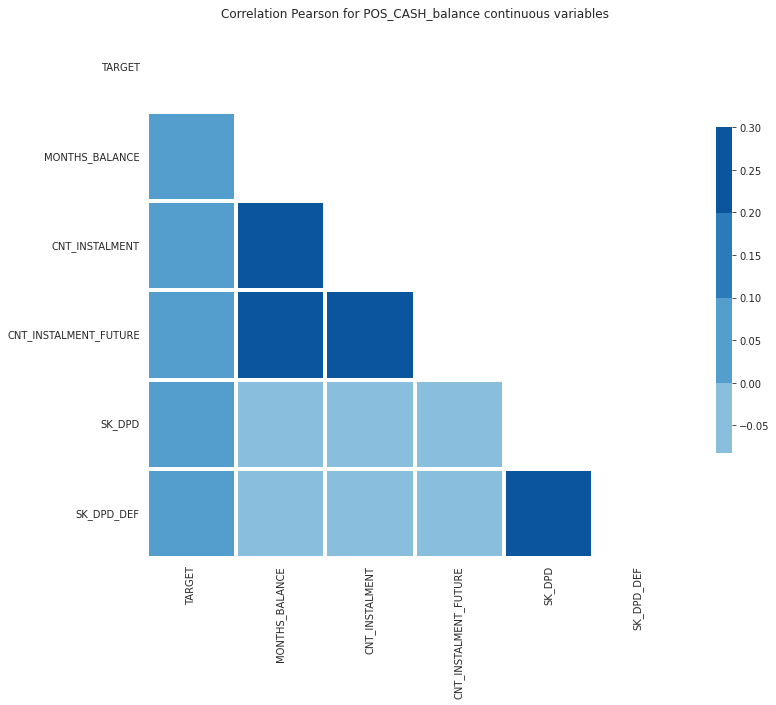

----------------------------------------------------------------------------------------------------
Correlation between continuous variable and Target variable sorted in descending order are :



TARGET                   1.000000
CNT_INSTALMENT_FUTURE    0.021972
MONTHS_BALANCE           0.020147
CNT_INSTALMENT           0.018506
SK_DPD                   0.009866
SK_DPD_DEF               0.008594
Name: TARGET, dtype: float64

In [ ]:
# Lets similarly observe the correlation between continuous variables and Target variable using Pearson correlatino coefficient
POS_CASH_balance_continuous=POS_CASH_balance_merged.drop(["SK_ID_CURR","SK_ID_PREV","NAME_CONTRACT_STATUS"],axis=1)

# Computing the Pearson correlation coefficients
corr=POS_CASH_balance_continuous.corr()

# Plotting the correlation matrix
mask_array = np.ones(corr.shape)
mask_array = np.triu(mask_array)

f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.color_palette("Blues")

sns.heatmap(corr, 
            mask=mask_array, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation Pearson for POS_CASH_balance continuous variables")
plt.show()

print("-"*100)
previous_application_top_continuous_var_lst=corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between continuous variable and Target variable sorted in descending order are :\n")
corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

**Observations and Conclusions:**
1. POS_CASH_balance dataframe is left merged on the application datafeame for a common SK_ID_CURR to get the Target variable from application dataframe for each row of POS_CASH_balance. POS_CASH_balance dataframe rows gets removed for which Target is not present. 
2. In the merged dataframe, 92.64% are non defaulters while 7.36% are defaulters.
3. A week correaltion between the variables and Target label is observed from the  categorical and continuous variables correaltions matrix. THis describes that there is no linear correaltion amongst the Target variable and continuous variable. 
4. Amongst all continuous variables, CNT_INSTALMENT_FUTURE shows a high correlation wrt Target label.

6. We will plot the categorical variable plot and first 2 continuous variables plot wrt Target variable.

## POS_CASH_balance Categorical Variable Plots

### Categorical variable 1: NAME_CONTRACT_STATUS 

Number of unique category values of NAME_CONTRACT_STATUS categorical variable are 9
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dataframe has NaN rows.
Percentage of NaN rows for NAME_CONTRACT_STATUS categorical variable are 0.21 %
Percentage of 0 labels for NaN value row is 93.34 %
Percentage of 1 labels for NaN value row is 6.66 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


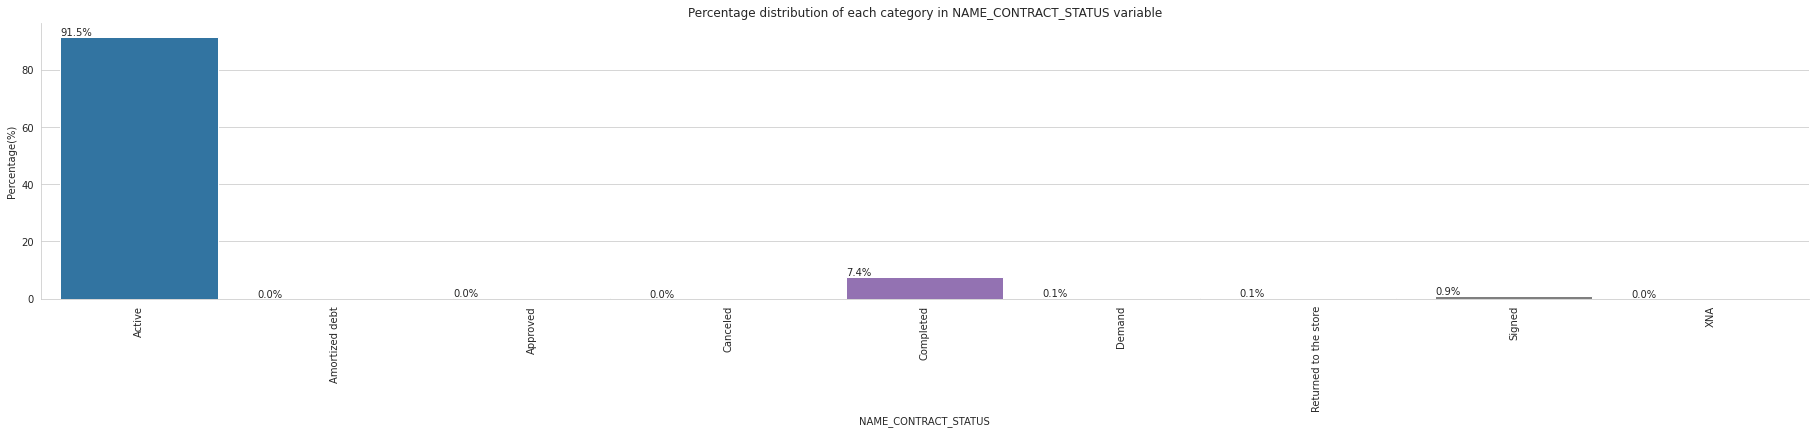

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


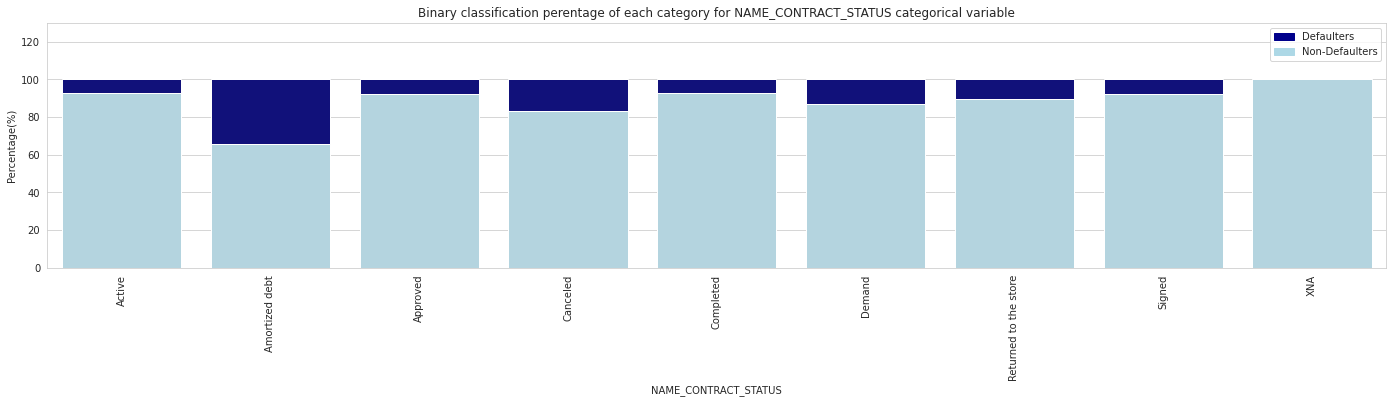

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


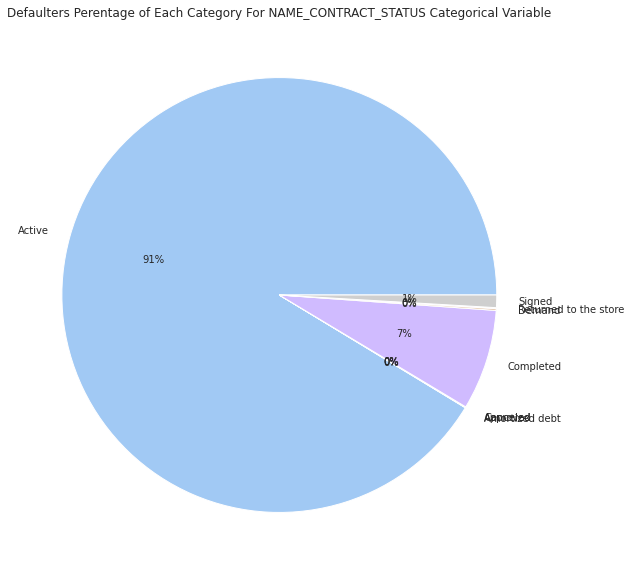

In [ ]:
# NAME_CONTRACT_STATUS   
category_var_plot(POS_CASH_balance_merged,POS_CASH_balance_top_categorical_var_lst[1])

**Observations and conclusions :**
1. NAME_CONTRACT_STATUS  represents the  contract status during the month.
2. For around 0.21% of samples, NAME_CONTRACT_STATUS   is not defined. Amongst these NaN values, 93.34% are non defaulters.
3. For the defined categories, Active constitute around 91.5% of samples and is the largest contract status type of the previous applications followed by completed status. Other types count is less than 1%.
5. Pie chart shows the defaulters percentage in an entire data follows the similar distribution as observed in the count percentage bar plot. 
6. Active contract status type has the largest count in the data and also has the overall largest defaulter percentage. 

## POS_CASH_balance Continuous Variable Plot

### Continuous variable 1: CNT_INSTALMENT_FUTURE  

Continuous variable CNT_INSTALMENT_FUTURE has 39945 NaN rows.
Percentage of NaN rows for CNT_INSTALMENT_FUTURE continuous variable are 0.47 %
Percentage of 0 labels for NaN value row is 91.7 %
Percentage of 1 labels for NaN value row is 8.3 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


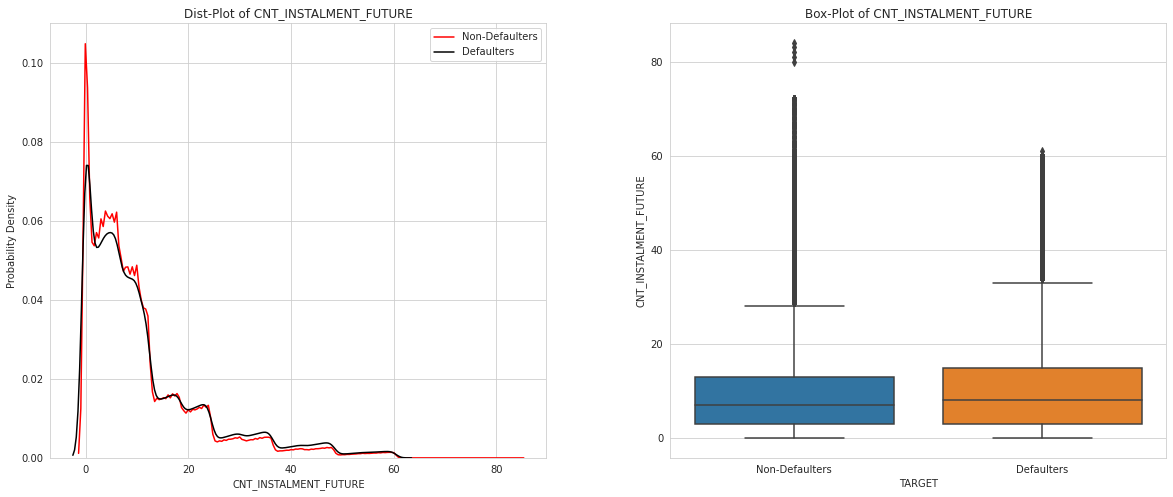

In [ ]:
plot_continuous_variables(POS_CASH_balance_merged,previous_application_top_continuous_var_lst[1])

**Observations and Conclusions :**  
1. CNT_INSTALMENT_FUTURE tells about installments remaining to pay on the previous credit.
1. Row samples of CNT_INSTALMENT_FUTURE  continuous variable have 0.47% NaN values out of which 91.7% are non defaulters.
2. Probability density plots of non defaulters and defaulters are right skewed. Non defaulter density plot shows peak at lesser installment number. This is an evident that, clients with lesser number of installments to pay at the time of application are more probable to be non defaulters than defaulters.
3. Intequertile range of non defaulters box plot is from 4 to 16 installments while that of defaulters is from 4 to 18 installments.

### Continuous variable 2: MONTHS_BALANCE   

Continuous variable MONTHS_BALANCE has 18067 NaN rows.
Percentage of NaN rows for MONTHS_BALANCE continuous variable are 0.21 %
Percentage of 0 labels for NaN value row is 93.34 %
Percentage of 1 labels for NaN value row is 6.66 %
Applicants labelled 1 are defaulters.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


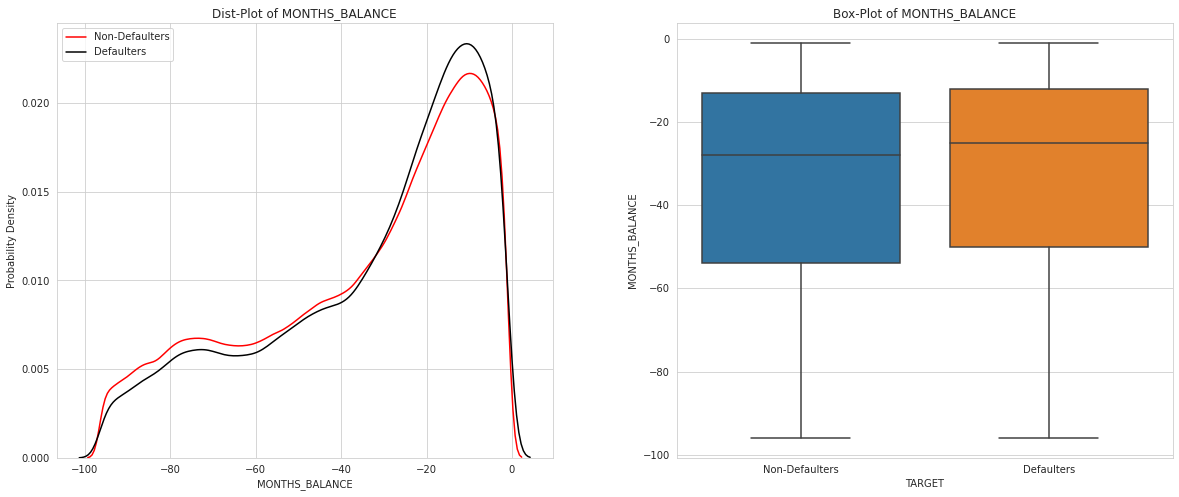

In [ ]:
plot_continuous_variables(POS_CASH_balance_merged,previous_application_top_continuous_var_lst[2])

**Observations and Conclusions :**  
1. MONTHS_BALANCE tells about months information available of client raltive to the application date.
1. Row samples of MONTHS_BALANCE  continuous variable have 0.21% NaN values out of which 93.34% are non defaulters.
2. Probability density plots of non defaulters and defaulters are left skewed. Defaulter density plot shows peak at the months near to the application data. 
3. Intequertile range of non defaulters box plot is from -16 to -56 months while that of defaulters is from -15 to -48 months.
4. Minimum and maximum values of both the categories of client are same. 
5. Median of defaulters is higher than non defaulters meaning defaulters information available is from near past than the non defaulters.

### Top Continuous Variables Pair Plot

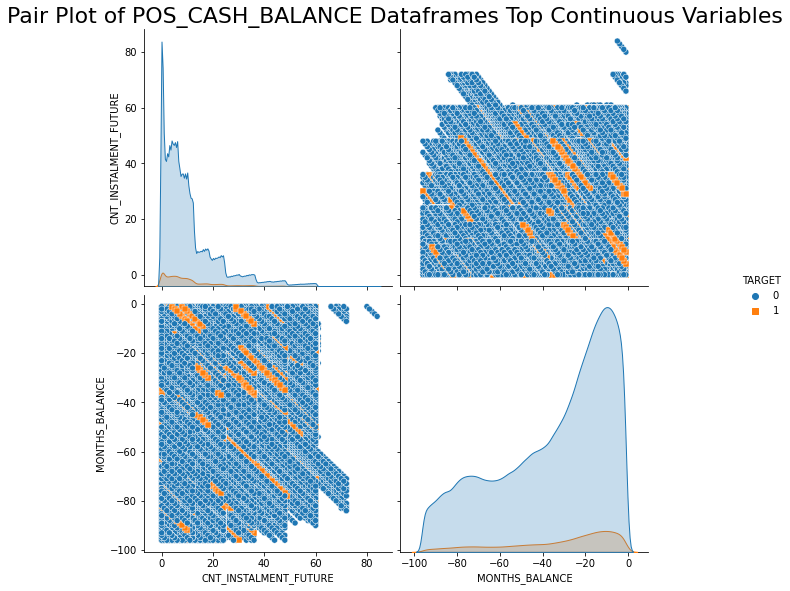

In [ ]:
df=POS_CASH_balance_merged[["TARGET","CNT_INSTALMENT_FUTURE","MONTHS_BALANCE"]]
pairPlotFn(df,"POS_CASH_BALANCE")

**Observations and Conclusions:** 
1. In this pair plot POS_CASH_BALANCE dataframes top 2 continuous variables correlated with Targer variable are plotted.
2. 0 represents the non defaulters while 1 represents the defaulters.
4. None of the subplots of this pair plot shows a clear linear seperation between the Target variables defaulters and non defaulters categoris.


# Credit card balance Dataframe Statistics

In [ ]:
credit_card_balance=pd.read_csv("credit_card_balance.csv")
credit_card_balance

SK_ID_PREV  SK_ID_CURR  ...  SK_DPD  SK_DPD_DEF
0           2562384      378907  ...       0           0
1           2582071      363914  ...       0           0
2           1740877      371185  ...       0           0
3           1389973      337855  ...       0           0
4           1891521      126868  ...       0           0
...             ...         ...  ...     ...         ...
3840307     1036507      328243  ...       0           0
3840308     1714892      347207  ...       0           0
3840309     1302323      215757  ...       0           0
3840310     1624872      430337  ...       0           0
3840311     2411345      236760  ...       0           0

[3840312 rows x 23 columns]

In [ ]:
print("Shape of Credit card balance dataframe is ",credit_card_balance.shape)
print("Number of unique values of SK_ID_PREV in Credit card balance are ",credit_card_balance["SK_ID_PREV"].nunique())
# lets understand the common id's between application_train.csv and Credit card balance
com_len_train=len(list(set(application_train["SK_ID_CURR"]) & set(credit_card_balance["SK_ID_CURR"])))
print("Common id's between application_train and Credit card balance are ",com_len_train)
print("Corresponding percentage is ",round(com_len_train/len(set(application_train["SK_ID_CURR"]))*100,2))
print("-"*100)
# lets understand the common id's between previous applications and Credit card balance
com_len_train=len(list(set(previous_application["SK_ID_PREV"]) & set(credit_card_balance["SK_ID_PREV"])))
print("Common id's between previous_application and Credit card balance are ",com_len_train)
print("Corresponding percentage is ",round(com_len_train/len(set(previous_application["SK_ID_PREV"]))*100,2))

Shape of Credit card balance dataframe is  (3840312, 23)
Number of unique values of SK_ID_PREV in Credit card balance are  104307
Common id's between application_train and Credit card balance are  86905
Corresponding percentage is  28.26
----------------------------------------------------------------------------------------------------
Common id's between previous_application and Credit card balance are  92935
Corresponding percentage is  5.56


Number of variables having NaN samples are  9


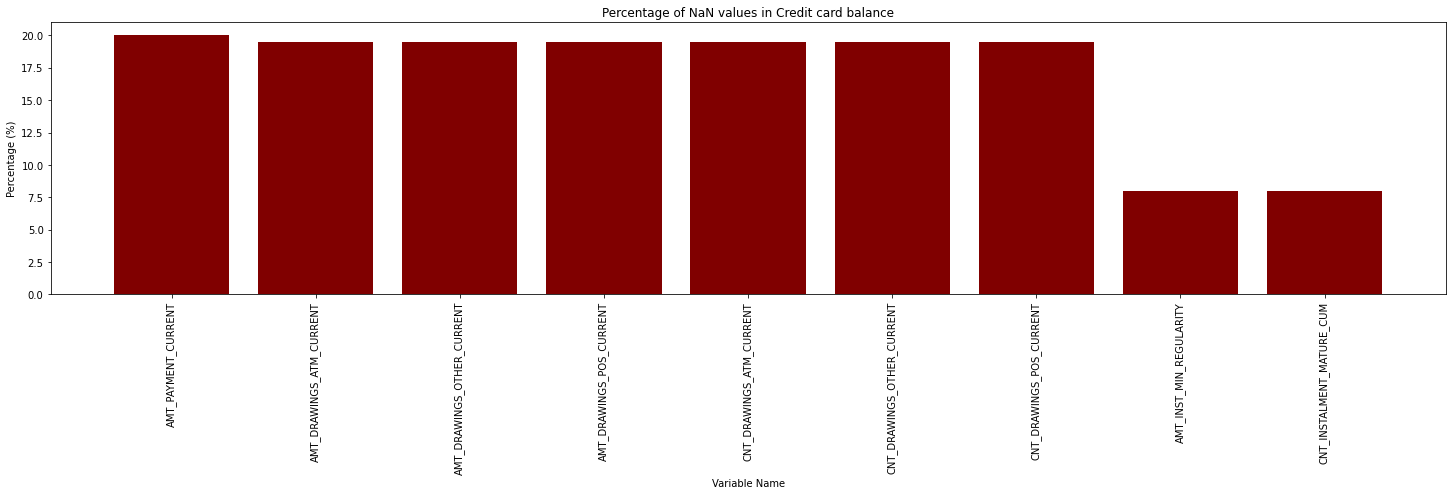

In [ ]:
#NaN variable percentatge in dataframe
plot_nan_pct(credit_card_balance,"Credit card balance")

**Observations and Conclusions:**
1. Credit card balance  dataframe has total 23 columns. Out of these, 9 variables have NaN values.
2. Out of the total apllicants present in application train dataframe, 25.26% of appplicants infromation about credit catd balance with Home Credit is captured with Credit card balance  dataframe. Around 5.56% of clients credit balance information who appeared in previous balance dataframe credit balance information is captured by Credit card balance dataframe.
3. SK_ID_PREV which represents ID of previous credit with Home Credit for applicant and SK_ID_CURR is the ID of application. Both of these are not unique.



## Credit Card Balance Dataframe Correlation Coefficient
Lets assign the "TARGET"variable to each Credit card balance sample. We will use application_train and Credit card balance common ID to assign the Target label. We will remove the dataframe samples for which target label is not assigned.

After merging we will undesrstand the correlation between target variable and continuous variables.

In [ ]:
print("Merging TARGET with Credit card balance dataframe")
credit_card_balance_merged = application_train.iloc[:,:2].merge(credit_card_balance, on = 'SK_ID_CURR', how = 'left')
print("Percentage of {} labeled rows is {} %".format(credit_card_balance_merged["TARGET"].value_counts().index.tolist()[0],round(credit_card_balance_merged["TARGET"].value_counts()[0]/credit_card_balance_merged.shape[0]*100,2)))
print("Percentage of {} labeled rows is {} %".format(credit_card_balance_merged["TARGET"].value_counts().index.tolist()[1],round(credit_card_balance_merged["TARGET"].value_counts()[1]/credit_card_balance_merged.shape[0]*100,2)))
print("Applicants labelled 1 are defaulters.")
print("-"*100)
credit_card_balance_merged.head()

Merging TARGET with Credit card balance dataframe
Percentage of 0 labeled rows is 92.83 %
Percentage of 1 labeled rows is 7.17 %
Applicants labelled 1 are defaulters.
----------------------------------------------------------------------------------------------------


SK_ID_CURR  TARGET  SK_ID_PREV  ...  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
0      100002       1         NaN  ...                   NaN     NaN         NaN
1      100003       0         NaN  ...                   NaN     NaN         NaN
2      100004       0         NaN  ...                   NaN     NaN         NaN
3      100006       0   1489396.0  ...                Active     0.0         0.0
4      100006       0   1489396.0  ...                Active     0.0         0.0

[5 rows x 24 columns]

In [ ]:
# Generating POS_CASH_balance categorical dataframe
credit_card_balance_merged_categorical_col=["TARGET","NAME_CONTRACT_STATUS"]
credit_card_balance_merged_merged_cat=credit_card_balance_merged[credit_card_balance_merged_categorical_col]

# Phi-k correaltion matrix between categorical variables and target label
phik_overview = credit_card_balance_merged_merged_cat.phik_matrix()
phik_overview.round(2)

POS_CASH_balance_top_categorical_var_lst=phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between categorical variable and Target variable sorted in descending order are :\n")
phik_overview.sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

interval columns not set, guessing: ['TARGET']
Correlation between categorical variable and Target variable sorted in descending order are :



TARGET                  1.000000
NAME_CONTRACT_STATUS    0.008896
Name: TARGET, dtype: float64

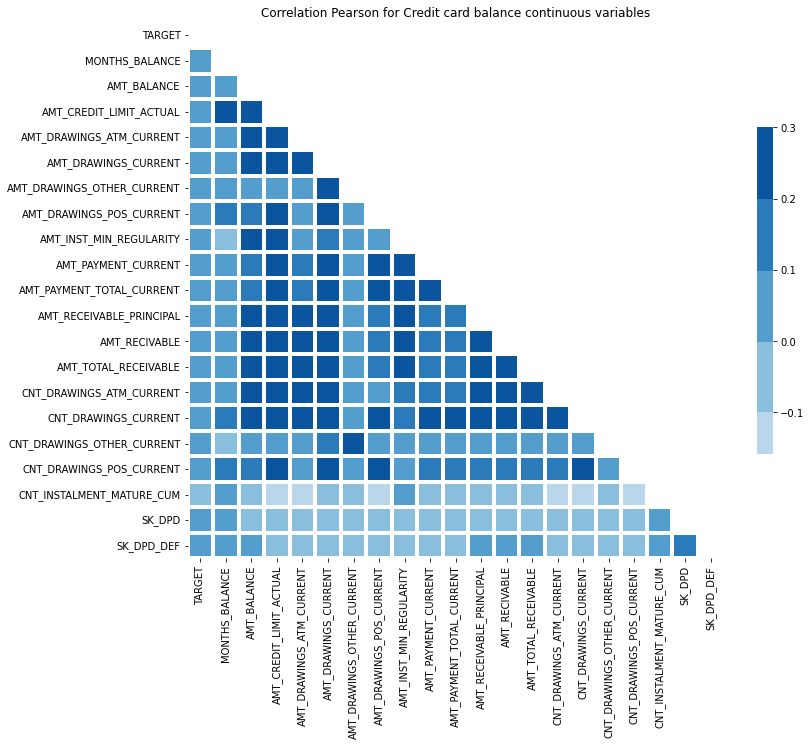

----------------------------------------------------------------------------------------------------
Correlation between continuous variable and Target variable sorted in descending order are :



TARGET                      1.000000
AMT_BALANCE                 0.050098
AMT_TOTAL_RECEIVABLE        0.049839
AMT_RECIVABLE               0.049803
AMT_RECEIVABLE_PRINCIPAL    0.049692
AMT_INST_MIN_REGULARITY     0.039798
CNT_DRAWINGS_ATM_CURRENT    0.038437
CNT_DRAWINGS_CURRENT        0.037793
MONTHS_BALANCE              0.035695
CNT_DRAWINGS_POS_CURRENT    0.029536
AMT_DRAWINGS_ATM_CURRENT    0.024700
Name: TARGET, dtype: float64

In [ ]:
# Lets similarly observe the correlation between continuous variables and Target variable using Pearson correlatino coefficient
credit_card_balance_continuous=credit_card_balance_merged.drop(["SK_ID_CURR","SK_ID_PREV","NAME_CONTRACT_STATUS"],axis=1)

# Computing the Pearson correlation coefficients
corr=credit_card_balance_continuous.corr()

# Plotting the correlation matrix
mask_array = np.ones(corr.shape)
mask_array = np.triu(mask_array)

f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.color_palette("Blues")

sns.heatmap(corr, 
            mask=mask_array, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )
plt.title("Correlation Pearson for Credit card balance continuous variables")
plt.show()

print("-"*100)
credit_card_balance_top_continuous_var_lst=corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11).index.tolist()
print("Correlation between continuous variable and Target variable sorted in descending order are :\n")
corr.abs().sort_values(["TARGET"], ascending=False)['TARGET'].head(11)

**Observations and Conclusions:**
1. Credit card balance dataframe is left merged on the application datafeame for a common SK_ID_CURR to get the Target variable from application dataframe for each row of Credit card balance. Credit card balance dataframe rows gets removed for which Target is not present. 
2. In the merged dataframe, 92.83% are non defaulters while 7.17% are defaulters.
3. A week correaltion between the variables and Target label is observed from the  categorical and continuous variables correaltions matrix. THis describes that there is no linear correaltion amongst the Target variable and continuous variable. 
4. Amongst all continuous variables, AMT_BALANCE shows a high correlation wrt Target label.
5. We will plot first 2 continuous variables plot wrt Target variable.

## Credit card balance Continuous Variable Plots

### Continuous variable 1: AMT_BALANCE   

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_BALANCE is -420250.185
The 10th percentile value of AMT_BALANCE is 0.0
The 25th percentile value of AMT_BALANCE is 0.0
The 50th percentile value of AMT_BALANCE is 0.0
The 75th percentile value of AMT_BALANCE is 90405.54
The 90th percentile value of AMT_BALANCE is 180226.14300000004
The 100th percentile value of AMT_BALANCE is 1354829.265
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Continuous variable AMT_BALANCE has 220606 NaN rows.
Percentage of NaN rows for AMT_BALANCE continuous variable are 6.4 %
Percentage of 0 labels for NaN value row is 92.16 %
Percentage of 1 labels for NaN value row is 7.84 %
Applicants labelled 1 are defau

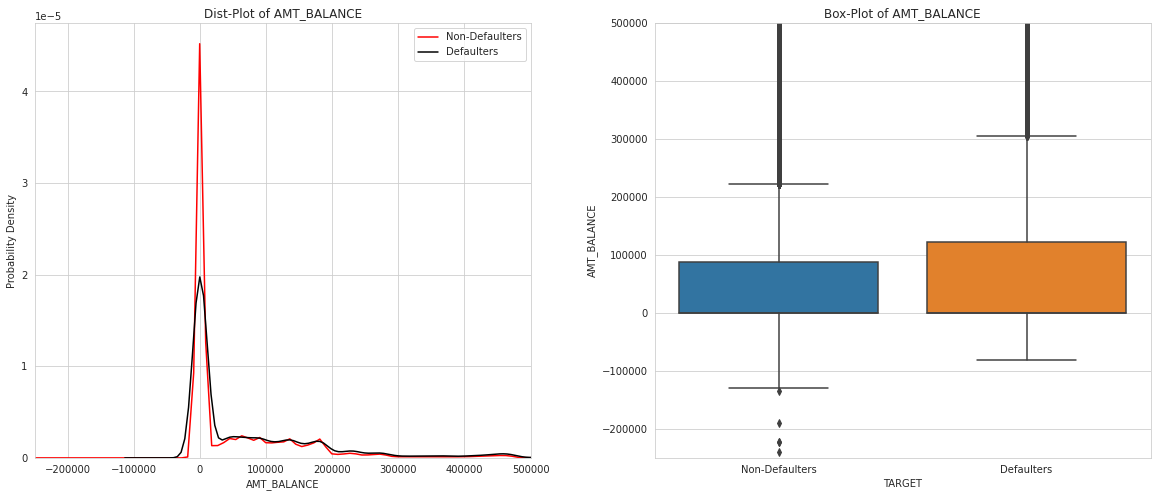

In [ ]:
# AMT_BALANCE
print_percentiles(credit_card_balance_merged,credit_card_balance_top_continuous_var_lst[1],percentiles=[0,10,25,50,75,90,100])
plot_continuous_variables(credit_card_balance_merged,credit_card_balance_top_continuous_var_lst[1],"Yes",(-250000,500000),(-250000,500000))

**Observations and Conclusions :**  
1. AMT_BALANCE  tells about balance during the month of previous credit.
1. Row samples of AMT_BALANCE   continuous variable have 6.4% NaN values out of which 92.16% are non defaulters.
2. Probability density plots of non defaulters and defaulters are right skewed. Non defaulter density plot shows peak at lesser amount balance value. This is an evident that, clients with lesser amount balnce are more probable to be non defaulters than defaulters.
3. Intequertile range of non defaulters box plot is shorter than defaulters.
5. 10 Percentile value are negative. 0 is the most occuring month balance amount. It covers from 10 to 50 percentile. 
6. Medians of non defaulters and defaulters is 0.

### Continuous variable 2: AMT_TOTAL_RECEIVABLE    

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The 0th percentile value of AMT_TOTAL_RECEIVABLE is -420250.185
The 10th percentile value of AMT_TOTAL_RECEIVABLE is 0.0
The 25th percentile value of AMT_TOTAL_RECEIVABLE is 0.0
The 50th percentile value of AMT_TOTAL_RECEIVABLE is 0.0
The 75th percentile value of AMT_TOTAL_RECEIVABLE is 90226.35
The 90th percentile value of AMT_TOTAL_RECEIVABLE is 180051.597
The 100th percentile value of AMT_TOTAL_RECEIVABLE is 1354829.265
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Continuous variable AMT_TOTAL_RECEIVABLE has 220606 NaN rows.
Percentage of NaN rows for AMT_TOTAL_RECEIVABLE continuous variable are 6.4 %
Percentage of 0 labels for NaN value row is 92.16 %
Percentag

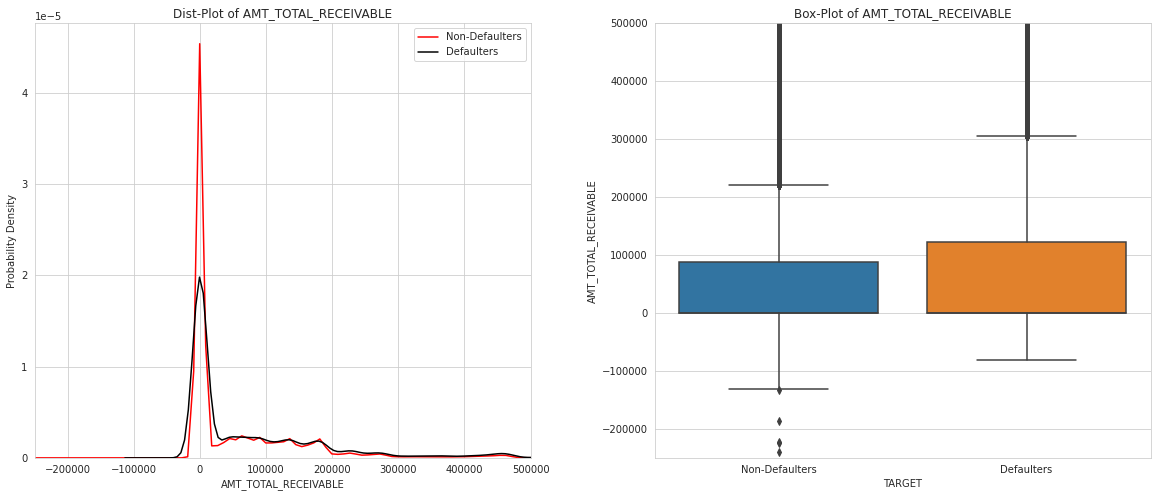

In [ ]:
# AMT_TOTAL_RECEIVABLE
print_percentiles(credit_card_balance_merged,credit_card_balance_top_continuous_var_lst[2],percentiles=[0,10,25,50,75,90,100])
plot_continuous_variables(credit_card_balance_merged,credit_card_balance_top_continuous_var_lst[2],"Yes",(-250000,500000),(-250000,500000))

**Observations and Conclusions :**  
1. AMT_TOTAL_RECEIVABLE   tells about amount receivable on previous credit.
1. Row samples of AMT_TOTAL_RECEIVABLE    continuous variable have 6.4% NaN values out of which 92.16% are non defaulters.
2. Probability density plots of non defaulters and defaulters are right skewed. Non defaulter density plot shows peak at lesser amount balance value. This is an evident that, clients with lesser amount receivable are more probable to be non defaulters than defaulters.
3. Intequertile range of non defaulters box plot is shorter than defaulters.
5. 10 Percentile value are negative. 0 is the most occuring month balance amount. It covers from 10 to 50 percentile. 
6. Medians of non defaulters and defaulters is 0.

### Top Continuous Variables Pair Plot

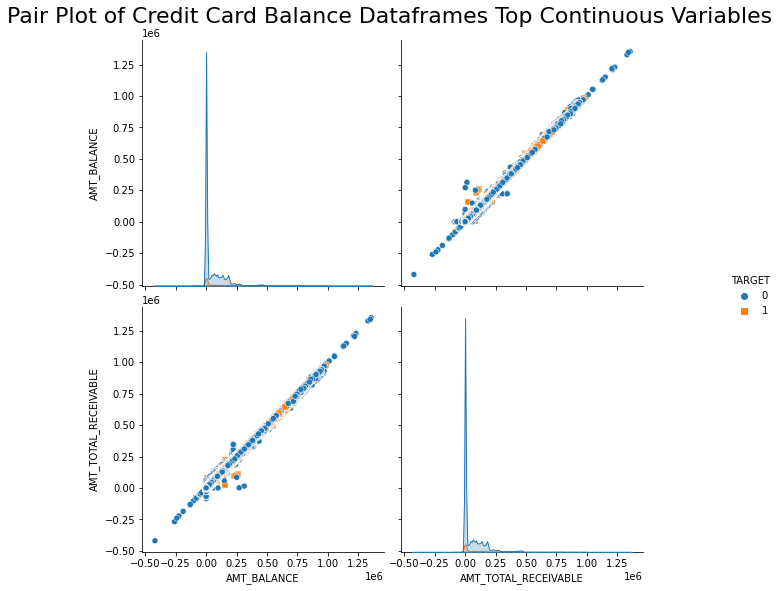

In [ ]:
df=credit_card_balance_merged[["TARGET","AMT_BALANCE","AMT_TOTAL_RECEIVABLE"]]
pairPlotFn(df,"Credit Card Balance")

**Observations and Conclusions:** 
1. In this pair plot Credit Card Balance dataframes top 2 continuous variables correlated with Targer variable are plotted.
2. 0 represents the non defaulters while 1 represents the defaulters.
4. None of the subplots of this pair plot shows a clear linear seperation between the Target variables defaulters and non defaulters categoris.
4. AMT_BALANCE and AMT_TOTAL_RECEIVABLE are linearly correlated.


# Defining The Performance metrics
Based on the EDA observations and problem statement requirements, following performance metrics are choosen to understand the model performance:

1. Confusion matrix, Precision matrix and Recall matrix

  The confusion matrix provides more insight into not only the performance of a predictive model but also which classes are being predicted correctly, which incorrectly, and what type of errors are being made. Precision matrix defines whther the predicted class belongs to the correct class or not and Recall matrix defines whther a true class is being correctly predicted or not.

  As the data is imbalanced it is important to understand the classification of defaulters and nondefaulters into the correct classes. This is understood by confusion, precision and recall matrix. 

2. F1 Score 

  F1 Score is the harmoninc mean of precision and recall. It is the important metrics for model performance understanding in case of an imbalanced data.

3. Area under the ROC curve

  ROC AUC defines how effective an algorithm at seperating the classes. A ROC AUC curve is a diagnostic plot for summarizing the behavior of a model by calculating the false positive rate and true positive rate for a set of predictions by the model under different thresholds. This metric is also useful for understanding the model performance in case of class imbalance.

# CONCLUSIONS FROM EDA
EDA of data gave a good insight into the available data. Conclusions from the descriptive statistics, correlation coefficients and variable plots observations are as follows:
1. Data is imbalanced. There are almost 90% of non defaulters and 10% defaulters. We will have to come up with sampling techniques while building the model.
2. Week correlation is observed for most of the variables and target label. This represent that the data is not linearly correlated. High order featurization can be used to improve model performance for classification.
3. Few of the variables have shown a good linear correlation wrt target label data. These features will be important for the classification task.
4. Few of the variables have number of days samples. Value range of these samples is high.(Eg. 0 to 1,00,000). Such variables can be transformed into years or month data for efficient computation. This transformation is also used in EDA for better visualization and observations.
5. Few of the continuous variables shows anamolies. (Eg. Count of days wrt application date should be negative, however few percentile of data has these values as positive. Also for some samples count of days does not make sense.) These anamolies should be dealt either by saturating the values to the nearest possible values or by imputation.
6. It is also been onserved that, for some single categorical variables, there are multiple categories with 0% count. Such categories can be grouped together for dimensionality reduction.
7. For variables where we observ a different median values of defaulter and non defaulter categoris, NaN values of such variables can be imputed by corresponding median values.
8. Observations from percentile statistics has shown anomolies in data for small percentile value. Such data can be saturated or imputed.
9. There are few variables which have almost 99% NaN values. Such variables can be discarded. A threshold of percentage of NaN values can be decided to discard the variables from the dataframe.
10. As the data is relational, data needs to be merged in an smart way. For visualization in this EDA study left merge on the Application Train dataframe is used.